In [2]:
#We will use IPython.display.Audio to play the audio files so we can inspect aurally. 

import IPython.display as ipd

ipd.Audio('./examples/audio/100032-3-0-0.wav')


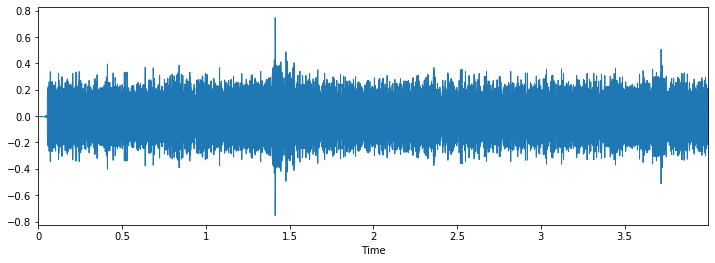

In [3]:
#We will load a sample from each class and visually inspect the data for any patterns. 
#We will use librosa to load the audio file into an array then librosa.display 
#and matplotlib to display the waveform. 

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Class: Air Conditioner

filename = './examples/audio/100852-0-0-0.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

# Class: Street music
#filename = '../UrbanSound Dataset sample/audio/101848-9-0-0.wav'
#plt.figure(figsize=(12,4))
#data,sample_rate = librosa.load(filename)
#_ = librosa.display.waveplot(data,sr=sample_rate)
#ipd.Audio(filename)

In [4]:
#Here we will load the UrbanSound metadata .csv file into a Panda dataframe. 

import pandas as pd
metadata = pd.read_csv('./examples/metadata/UrbanSound8K.csv')
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

         class_name  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [5]:
#class distributions
print(metadata.class_name.value_counts())

street_music        1000
jackhammer          1000
engine_idling       1000
air_conditioner     1000
dog_bark            1000
children_playing    1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class_name, dtype: int64


In [7]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

#Next we will iterate through each of the audio sample files and extract, 
#number of audio channels, sample rate and bit-depth. 

import pandas as pd
import os
import librosa
import librosa.display

wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('./audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [8]:
#Most of the samples have two audio channels (meaning stereo) with a few with just the one channel (mono).
#The easiest option here to make them uniform will be to merge the two channels in the stero samples 
#into one by averaging the values of the two channels. 

# num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


In [9]:
#There is a wide range of Sample rates that have been used across all the samples which is a concern 
#(ranging from 96k to 8k).
#This likley means that we will have to apply a sample-rate conversion technique 
#(either up-conversion or down-conversion) so we can see an agnostic representation of their waveform 
#which will allow us to do a fair comparison. 

# sample rates 
print(audiodf.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [10]:
#There is also a wide range of bit-depths. It's likely that we may need to normalise them by 
#taking the maximum and minimum amplitude values for a given bit-depth. 

# bit depth
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


In [13]:
#By default, Librosa’s load function converts the sampling rate to 22.05 KHz 
#which we can use as our comparison level. 

import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = './examples/audio/100852-0-0-0.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 44100
Librosa sample rate: 22050


In [14]:
#Librosa’s load function will also normalise the data so it's values range between -1 and 1. 
#This removes the complication of the dataset having a wide range of bit-depths. 

print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -23628 to 27507
Librosa audio file min~max range: -0.50266445 to 0.74983937


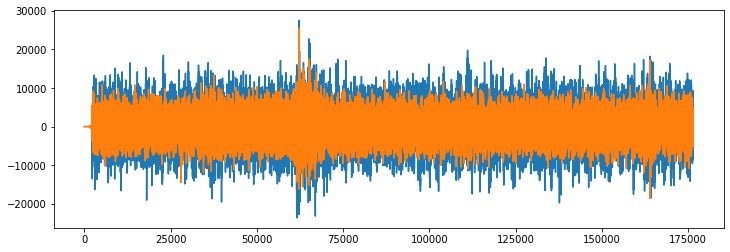

In [15]:
#Librosa will also convert the signal to mono, meaning the number of channels will always be 1. 

import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

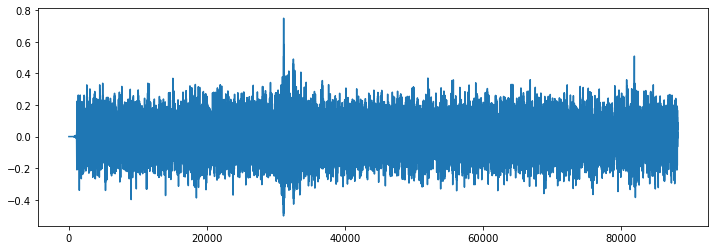

In [16]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [17]:
#For this we will use Librosa's mfcc() function which generates an MFCC from time series audio data. 

mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


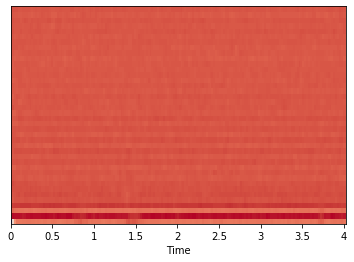

In [18]:
#This shows librosa calculated a series of 40 MFCCs over 173 frames.

import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [19]:
#We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe 
#along with it's classification label. 

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [21]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = './audio/'

metadata = pd.read_csv('./examples/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  8732  files


In [23]:
#We will use sklearn.preprocessing.LabelEncoder to encode the categorical text data into 
#model-understandable numerical data. 

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [24]:
#Here we will use sklearn.model_selection.train_test_split to split the dataset into training and testing sets. 
#The testing set size will be 20% and we will set a random state. 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [25]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [26]:
#We will start with constructing a Multilayer Perceptron (MLP) Neural Network using Keras and a Tensorflow backend.

#Starting with a sequential model so we can build the model layer by layer.

#We will begin with a simple model architecture, consisting of three layers, an input layer, a hidden layer and
#an output layer. All three layers will be of the dense layer type which is a standard layer type that is used 
#in many cases for neural networks.

#The first layer will receive the input shape. As each sample contains 40 MFCCs (or columns) we have a shape of 
#(1x40) this means we will start with an input shape of 40.

#The first two layers will have 256 nodes. The activation function we will be using for our first 2 layers is 
#the ReLU, or Rectified Linear Activation. This activation function has been proven to work well in neural 
#networks.

#We will also apply a Dropout value of 50% on our first two layers. This will randomly exclude nodes from each 
#update cycle which in turn results in a network that is capable of better generalisation and is less likely 
#to overfit the training data.

#Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The 
#activation is for our output layer is softmax. Softmax makes the output sum up to 1 so the output can be 
#interpreted as probabilities. The model will then make its prediction based on which option has the highest 
#probability.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [27]:
#For compiling our model, we will use the following three parameters:
#Loss function - we will use categorical_crossentropy. This is the most common choice for classification. A lower score indicates that the model is performing better.
#Metrics - we will use the accuracy metric which will allow us to view the accuracy score on the validation data when we train the model.
#Optimizer - here we will use adam which is a generally good optimizer for many use cases.

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [28]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [29]:
#Here we will train the model.

#We will start with 100 epochs which is the number of times the model will cycle through the data. The model 
#will improve on each cycle until it reaches a certain point.

#We will also start with a low batch size, as having a large batch size can reduce the generalisation ability of 
#the model. 

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
196/219 [=========================>....] - ETA: 0s - loss: 9.0056 - accuracy: 0.1940 
Epoch 00001: val_loss improved from inf to 2.17829, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 8.3445 - accuracy: 0.1940 - val_loss: 2.1783 - val_accuracy: 0.1843
Epoch 2/100
207/219 [===========================>..] - ETA: 0s - loss: 2.2786 - accuracy: 0.2385
Epoch 00002: val_loss improved from 2.17829 to 2.00209, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.2719 - accuracy: 0.2392 - val_loss: 2.0021 - val_accuracy: 0.3423
Epoch 3/100
188/219 [========================>.....] - ETA: 0s - loss: 2.0229 - accuracy: 0.3004
Epoch 00003: val_loss improved from 2.00209 to 1.81214, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.0201 - accuracy: 0.3014 - val_loss: 1.8121 - v

Epoch 25/100
219/219 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.7061
Epoch 00025: val_loss improved from 0.66820 to 0.66365, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8561 - accuracy: 0.7061 - val_loss: 0.6637 - val_accuracy: 0.7934
Epoch 26/100
182/219 [=======================>......] - ETA: 0s - loss: 0.8437 - accuracy: 0.7151
Epoch 00026: val_loss improved from 0.66365 to 0.60812, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 0.8306 - accuracy: 0.7205 - val_loss: 0.6081 - val_accuracy: 0.8163
Epoch 27/100
209/219 [===========================>..] - ETA: 0s - loss: 0.8210 - accuracy: 0.7202
Epoch 00027: val_loss did not improve from 0.60812
219/219 [==============================] - 0s 2ms/step - loss: 0.8290 - accuracy: 0.7180 - val_loss: 0.6341 - val_accuracy: 0.7985
Epoch 28/100
199/219 [==============

200/219 [==========================>...] - ETA: 0s - loss: 0.6247 - accuracy: 0.7881
Epoch 00051: val_loss did not improve from 0.50137
219/219 [==============================] - 1s 2ms/step - loss: 0.6345 - accuracy: 0.7845 - val_loss: 0.5067 - val_accuracy: 0.8523
Epoch 52/100
197/219 [=========================>....] - ETA: 0s - loss: 0.6216 - accuracy: 0.7874
Epoch 00052: val_loss improved from 0.50137 to 0.49356, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 0.6254 - accuracy: 0.7863 - val_loss: 0.4936 - val_accuracy: 0.8540
Epoch 53/100
198/219 [==========================>...] - ETA: 0s - loss: 0.6242 - accuracy: 0.7854
Epoch 00053: val_loss did not improve from 0.49356
219/219 [==============================] - 0s 2ms/step - loss: 0.6283 - accuracy: 0.7845 - val_loss: 0.4980 - val_accuracy: 0.8575
Epoch 54/100
186/219 [========================>.....] - ETA: 0s - loss: 0.6022 - accuracy: 0.7994
Epoch 00054: 

Epoch 79/100
194/219 [=========================>....] - ETA: 0s - loss: 0.5238 - accuracy: 0.8244
Epoch 00079: val_loss improved from 0.45067 to 0.44322, saving model to saved_models/weights.best.basic_mlp.hdf5
219/219 [==============================] - 0s 1ms/step - loss: 0.5308 - accuracy: 0.8230 - val_loss: 0.4432 - val_accuracy: 0.8809
Epoch 80/100
194/219 [=========================>....] - ETA: 0s - loss: 0.5256 - accuracy: 0.8236
Epoch 00080: val_loss did not improve from 0.44322
219/219 [==============================] - 0s 1ms/step - loss: 0.5344 - accuracy: 0.8202 - val_loss: 0.4602 - val_accuracy: 0.8695
Epoch 81/100
198/219 [==========================>...] - ETA: 0s - loss: 0.5428 - accuracy: 0.8169
Epoch 00081: val_loss did not improve from 0.44322
219/219 [==============================] - 0s 1ms/step - loss: 0.5424 - accuracy: 0.8186 - val_loss: 0.4533 - val_accuracy: 0.8735
Epoch 82/100
199/219 [==========================>...] - ETA: 0s - loss: 0.5496 - accuracy: 0.8213


In [30]:
#Here we will review the accuracy of the model on both the training and test data sets. 

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

#The initial Training and Testing accuracy scores are quite high. As there is not a great difference between 
#the Training and Test scores (~5%) this suggests that the model has not suffered from overfitting. 

Training Accuracy:  0.9311381578445435
Testing Accuracy:  0.8700629472732544


In [34]:
#Here we will build a method which will allow us to test the models predictions on a specified audio .wav file. 

import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [35]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [37]:
#Test with sample data¶
#Initial sainity check to verify the predictions using a subsection of the sample audio files we explored 
#in the first notebook. We expect the bulk of these to be classified correctly. 

# Class: Air Conditioner

filename = './examples/audio/100852-0-0-0.wav' 
print_prediction(filename) 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The predicted class is: air_conditioner 

Instructions for updating:
Please use `model.predict()` instead.
air_conditioner 		 :  0.99780708551406860351562500000000
car_horn 		 :  0.00000991475826594978570938110352
children_playing 		 :  0.00095121964113786816596984863281
dog_bark 		 :  0.00008725249062990769743919372559
drilling 		 :  0.00047878702753223478794097900391
engine_idling 		 :  0.00029931426979601383209228515625
gun_shot 		 :  0.00000260522347161895595490932465
jackhammer 		 :  0.00002287109964527189731597900391
siren 		 :  0.00000064015063117039971984922886
street_music 		 :  0.00034026528010144829750061035156


In [41]:
# Class: Drilling

filename = './examples/audio/103199-4-0-0.wav'
print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.00000000028315202960094154605031
car_horn 		 :  0.00000028113629468862200155854225
children_playing 		 :  0.00001262973728444194421172142029
dog_bark 		 :  0.00000137086317408829927444458008
drilling 		 :  0.98945087194442749023437500000000
engine_idling 		 :  0.00000000028644001059952017840260
gun_shot 		 :  0.00000001363241608487442135810852
jackhammer 		 :  0.00000000209504147363759329891764
siren 		 :  0.00000000002318431037429125041172
street_music 		 :  0.01053489930927753448486328125000


In [42]:
#Here we will use a sample of various copyright free sounds that we not part of either our test or training 
#data to further validate our model.

filename = './examples/other-audio/dog_bark_1.wav'
print_prediction(filename) 

The predicted class is: dog_bark 

air_conditioner 		 :  0.00866602547466754913330078125000
car_horn 		 :  0.00148448219988495111465454101562
children_playing 		 :  0.01299251616001129150390625000000
dog_bark 		 :  0.39538881182670593261718750000000
drilling 		 :  0.01664772070944309234619140625000
engine_idling 		 :  0.00016692050849087536334991455078
gun_shot 		 :  0.21046343445777893066406250000000
jackhammer 		 :  0.00103730999398976564407348632812
siren 		 :  0.00162960751913487911224365234375
street_music 		 :  0.35152316093444824218750000000000


In [44]:
filename = './examples/other-audio/drilling_1.wav'

print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.28756976127624511718750000000000
car_horn 		 :  0.00006195204332470893859863281250
children_playing 		 :  0.04265521466732025146484375000000
dog_bark 		 :  0.00777717400342226028442382812500
drilling 		 :  0.57831746339797973632812500000000
engine_idling 		 :  0.00860194489359855651855468750000
gun_shot 		 :  0.02474085427820682525634765625000
jackhammer 		 :  0.04671885073184967041015625000000
siren 		 :  0.00009384824807057157158851623535
street_music 		 :  0.00346287968568503856658935546875


In [45]:
#feature Extraction refinement
#In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files 
#(depending on the samples duration).
#However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make 
#them all the same size. 

import numpy as np
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [48]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
#fulldatasetpath = '/audio/'
fulldatasetpath = '/examples/audio/'

metadata = pd.read_csv('./examples/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Error encountered while parsing file:  /audio/fold5/100032-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100263-2-0-117.wav
Error encountered while parsing file:  /audio/fold5/100263-2-0-121.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100263-2-0-126.wav
Error encountered while parsing file:  /audio/fold5/100263-2-0-137.wav
Error encountered while parsing file:  /audio/fold5/100263-2-0-143.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100263-2-0-161.wav
Error encountered while parsing file:  /audio/fold5/100263-2-0-3.wav
Error encountered while parsing file:  /audio/fold5/100263-2-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/100648-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/100648-1-1-0.wav
Error encountered while parsing file:  /audio/fold10/100648-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/100648-1-3-0.wav
Error encountered while parsing file:  /audio/fold10/100648-1-4-0.wav
Error encountered while parsing file:  /audio/fold2/100652-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/100652-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/100652-3-0-2.wav
Error encountered while parsing file:  /audio/fold2/100652-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/100795-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/100795-3-1-0.wav
Error encountered while parsing file:  /audio/fold10/100795-3-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/100795-3-1-2.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-0.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-10.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-11.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-13.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-14.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-16.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-17.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-19.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-2.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-21.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-22.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-24.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-25.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-27.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-28.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-3.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-30.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-5.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-6.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/100852-0-0-8.wav
Error encountered while parsing file:  /audio/fold5/100852-0-0-9.wav
Error encountered while parsing file:  /audio/fold6/101281-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/101281-3-0-14.wav
Error encountered while parsing file:  /audio/fold6/101281-3-0-5.wav
Error encountered while parsing file:  /audio/fold10/101382-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/101382-2-0-12.wav
Error encountered while parsing file:  /audio/fold10/101382-2-0-20.wav
Error encountered while parsing file:  /audio/fold10/101382-2-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/101382-2-0-29.wav
Error encountered while parsing file:  /audio/fold10/101382-2-0-33.wav
Error encountered while parsing file:  /audio/fold10/101382-2-0-42.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/101382-2-0-45.wav
Error encountered while parsing file:  /audio/fold1/101415-3-0-2.wav
Error encountered while parsing file:  /audio/fold1/101415-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/101415-3-0-8.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-1.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-12.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-13.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-16.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-17.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-19.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-21.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-23.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-24.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-28.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-29.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-32.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-33.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-37.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-38.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-4.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-40.wav
Error encountered while parsing file:  /audio/fold9/101729-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/101729-0-0-9.wav
Error encountered while parsing file:  /audio/fold7/101848-9-0-0.wav
Error encountered while parsing file:  /audio/fold7/101848-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/101848-9-0-2.wav
Error encountered while parsing file:  /audio/fold7/101848-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/101848-9-0-8.wav
Error encountered while parsing file:  /audio/fold7/101848-9-0-9.wav
Error encountered while parsing file:  /audio/fold4/102102-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102103-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/102103-3-1-0.wav
Error encountered while parsing file:  /audio/fold2/102104-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/102105-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/102106-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/102305-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/102547-3-0-2.wav
Error encountered while parsing file:  /audio/fold5/102547-3-0-7.wav
Error encountered while parsing file:  /audio/fold5/102547-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/102842-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/102842-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/102842-3-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/102842-3-1-6.wav
Error encountered while parsing file:  /audio/fold7/102853-8-0-0.wav
Error encountered while parsing file:  /audio/fold7/102853-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/102853-8-0-2.wav
Error encountered while parsing file:  /audio/fold7/102853-8-0-3.wav
Error encountered while parsing file:  /audio/fold7/102853-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/102853-8-0-5.wav
Error encountered while parsing file:  /audio/fold7/102853-8-0-6.wav
Error encountered while parsing file:  /audio/fold7/102853-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-0.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-1.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-11.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-12.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-14.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-15.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-17.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-18.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-2.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-20.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-22.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-23.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-25.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-26.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-28.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-29.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-30.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-4.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-6.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-7.wav
Error encountered while parsing file:  /audio/fold10/102857-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/102857-5-0-9.wav
Error encountered while parsing file:  /audio/fold2/102858-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/102858-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-1.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-11.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-12.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-14.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-15.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-3.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-4.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-6.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-7.wav
Error encountered while parsing file:  /audio/fold2/102871-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/102871-8-0-9.wav
Error encountered while parsing file:  /audio/fold1/103074-7-0-0.wav
Error encountered while parsing file:  /audio/fold1/103074-7-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-0-2.wav
Error encountered while parsing file:  /audio/fold1/103074-7-1-0.wav
Error encountered while parsing file:  /audio/fold1/103074-7-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-1-2.wav
Error encountered while parsing file:  /audio/fold1/103074-7-1-3.wav
Error encountered while parsing file:  /audio/fold1/103074-7-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-1-5.wav
Error encountered while parsing file:  /audio/fold1/103074-7-1-6.wav
Error encountered while parsing file:  /audio/fold1/103074-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-3-0.wav
Error encountered while parsing file:  /audio/fold1/103074-7-3-1.wav
Error encountered while parsing file:  /audio/fold1/103074-7-3-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-3-3.wav
Error encountered while parsing file:  /audio/fold1/103074-7-4-0.wav
Error encountered while parsing file:  /audio/fold1/103074-7-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-4-2.wav
Error encountered while parsing file:  /audio/fold1/103074-7-4-3.wav
Error encountered while parsing file:  /audio/fold1/103074-7-4-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103074-7-4-5.wav
Error encountered while parsing file:  /audio/fold1/103074-7-4-6.wav
Error encountered while parsing file:  /audio/fold8/103076-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/103076-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/103076-3-2-0.wav
Error encountered while parsing file:  /audio/fold3/103199-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-0-3.wav
Error encountered while parsing file:  /audio/fold3/103199-4-0-4.wav
Error encountered while parsing file:  /audio/fold3/103199-4-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-0-6.wav
Error encountered while parsing file:  /audio/fold3/103199-4-1-0.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-2-1.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-10.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-2-2.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-3.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-2-5.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-6.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-2-8.wav
Error encountered while parsing file:  /audio/fold3/103199-4-2-9.wav
Error encountered while parsing file:  /audio/fold3/103199-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103199-4-6-0.wav
Error encountered while parsing file:  /audio/fold3/103199-4-7-2.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-10.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-12.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-13.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-15.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-16.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-18.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-19.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-3.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-4.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-6.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-7.wav
Error encountered while parsing file:  /audio/fold9/103249-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/103249-5-0-9.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-10.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-11.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-13.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-14.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-16.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-17.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-19.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-2.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-4.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-5.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/103258-5-0-7.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-8.wav
Error encountered while parsing file:  /audio/fold1/103258-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/103357-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/103357-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/103438-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/103438-5-0-1.wav
Error encountered while parsing file:  /audio/fold10/103438-5-0-2.wav
Error encountered while parsing file:  /audio/fold6/104327-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/104327-2-0-19.wav
Error encountered while parsing file:  /audio/fold6/104327-2-0-26.wav
Error encountered while parsing file:  /audio/fold6/104327-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/104327-2-0-3.wav
Error encountered while parsing file:  /audio/fold6/104327-2-0-30.wav
Error encountered while parsing file:  /audio/fold6/104327-2-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/104327-2-0-4.wav
Error encountered while parsing file:  /audio/fold5/104421-2-0-1.wav
Error encountered while parsing file:  /audio/fold5/104421-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104421-2-0-20.wav
Error encountered while parsing file:  /audio/fold5/104421-2-0-29.wav
Error encountered while parsing file:  /audio/fold5/104421-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104421-2-0-5.wav
Error encountered while parsing file:  /audio/fold5/104421-2-0-7.wav
Error encountered while parsing file:  /audio/fold5/104421-2-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-15.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-21.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-29.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-3.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-40.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-41.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-48.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-51.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-52.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-53.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-55.wav
Error encountered while parsing file:  /audio/fold7/104625-4-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/104625-4-0-66.wav
Error encountered while parsing file:  /audio/fold7/104625-4-1-20.wav
Error encountered while parsing file:  /audio/fold7/104625-4-1-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/104817-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-1.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/104817-4-0-11.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-2.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/104817-4-0-4.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-5.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/104817-4-0-7.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-8.wav
Error encountered while parsing file:  /audio/fold2/104817-4-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-0-5.wav
Error encountered while parsing file:  /audio/fold5/104998-7-10-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-10-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-10-13.wav
Error encountered while parsing file:  /audio/fold5/104998-7-10-15.wav
Error encountered while parsing file:  /audio/fold5/104998-7-10-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-10-9.wav
Error encountered while parsing file:  /audio/fold5/104998-7-11-0.wav
Error encountered while parsing file:  /audio/fold5/104998-7-11-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-12-2.wav
Error encountered while parsing file:  /audio/fold5/104998-7-14-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-14-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-14-6.wav
Error encountered while parsing file:  /audio/fold5/104998-7-15-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-15-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-15-5.wav
Error encountered while parsing file:  /audio/fold5/104998-7-15-9.wav
Error encountered while parsing file:  /audio/fold5/104998-7-16-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-16-10.wav
Error encountered while parsing file:  /audio/fold5/104998-7-16-11.wav
Error encountered while parsing file:  /audio/fold5/104998-7-16-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-16-6.wav
Error encountered while parsing file:  /audio/fold5/104998-7-16-7.wav
Error encountered while parsing file:  /audio/fold5/104998-7-17-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-17-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-17-12.wav
Error encountered while parsing file:  /audio/fold5/104998-7-17-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-17-4.wav
Error encountered while parsing file:  /audio/fold5/104998-7-17-7.wav
Error encountered while parsing file:  /audio/fold5/104998-7-17-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-18-12.wav
Error encountered while parsing file:  /audio/fold5/104998-7-18-13.wav
Error encountered while parsing file:  /audio/fold5/104998-7-18-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-18-9.wav
Error encountered while parsing file:  /audio/fold5/104998-7-19-0.wav
Error encountered while parsing file:  /audio/fold5/104998-7-19-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-19-6.wav
Error encountered while parsing file:  /audio/fold5/104998-7-19-7.wav
Error encountered while parsing file:  /audio/fold5/104998-7-19-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-19-9.wav
Error encountered while parsing file:  /audio/fold5/104998-7-2-4.wav
Error encountered while parsing file:  /audio/fold5/104998-7-2-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-2-6.wav
Error encountered while parsing file:  /audio/fold5/104998-7-3-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-7-1.wav
Error encountered while parsing file:  /audio/fold5/104998-7-7-4.wav
Error encountered while parsing file:  /audio/fold5/104998-7-7-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-7-9.wav
Error encountered while parsing file:  /audio/fold5/104998-7-8-13.wav
Error encountered while parsing file:  /audio/fold5/104998-7-8-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-8-15.wav
Error encountered while parsing file:  /audio/fold5/104998-7-8-17.wav
Error encountered while parsing file:  /audio/fold5/104998-7-8-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-8-6.wav
Error encountered while parsing file:  /audio/fold5/104998-7-8-7.wav
Error encountered while parsing file:  /audio/fold5/104998-7-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/104998-7-9-13.wav
Error encountered while parsing file:  /audio/fold5/104998-7-9-9.wav
Error encountered while parsing file:  /audio/fold9/105029-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-0-1.wav
Error encountered while parsing file:  /audio/fold9/105029-7-0-2.wav
Error encountered while parsing file:  /audio/fold9/105029-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-0-4.wav
Error encountered while parsing file:  /audio/fold9/105029-7-0-5.wav
Error encountered while parsing file:  /audio/fold9/105029-7-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-1-0.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-1.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-1-11.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-12.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-1-2.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-1-4.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-5.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-6.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-1-8.wav
Error encountered while parsing file:  /audio/fold9/105029-7-1-9.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-1.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-10.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-12.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-13.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-15.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-16.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-3.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-4.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-6.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-7.wav
Error encountered while parsing file:  /audio/fold9/105029-7-2-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-2-9.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-0.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-3-2.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-3.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-3-5.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-6.wav
Error encountered while parsing file:  /audio/fold9/105029-7-3-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-4-0.wav
Error encountered while parsing file:  /audio/fold9/105029-7-4-1.wav
Error encountered while parsing file:  /audio/fold9/105029-7-4-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105029-7-4-3.wav
Error encountered while parsing file:  /audio/fold9/105088-3-0-10.wav
Error encountered while parsing file:  /audio/fold9/105088-3-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/105088-3-0-19.wav
Error encountered while parsing file:  /audio/fold9/105088-3-0-8.wav
Error encountered while parsing file:  /audio/fold7/105289-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-0-1.wav
Error encountered while parsing file:  /audio/fold7/105289-8-0-2.wav
Error encountered while parsing file:  /audio/fold7/105289-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-0-4.wav
Error encountered while parsing file:  /audio/fold7/105289-8-0-5.wav
Error encountered while parsing file:  /audio/fold7/105289-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-1-1.wav
Error encountered while parsing file:  /audio/fold7/105289-8-1-2.wav
Error encountered while parsing file:  /audio/fold7/105289-8-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-1-4.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-0.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-2-2.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-3.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/105289-8-2-5.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-6.wav
Error encountered while parsing file:  /audio/fold7/105289-8-2-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/105319-3-0-22.wav
Error encountered while parsing file:  /audio/fold6/105319-3-0-29.wav
Error encountered while parsing file:  /audio/fold6/105319-3-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/105415-2-0-1.wav
Error encountered while parsing file:  /audio/fold1/105415-2-0-15.wav
Error encountered while parsing file:  /audio/fold1/105415-2-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/105415-2-0-21.wav
Error encountered while parsing file:  /audio/fold1/105415-2-0-24.wav
Error encountered while parsing file:  /audio/fold1/105415-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/105415-2-0-6.wav
Error encountered while parsing file:  /audio/fold1/105415-2-0-8.wav
Error encountered while parsing file:  /audio/fold5/105425-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/105425-9-0-10.wav
Error encountered while parsing file:  /audio/fold5/105425-9-0-12.wav
Error encountered while parsing file:  /audio/fold5/105425-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/105425-9-0-14.wav
Error encountered while parsing file:  /audio/fold5/105425-9-0-23.wav
Error encountered while parsing file:  /audio/fold10/106014-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/106014-5-0-1.wav
Error encountered while parsing file:  /audio/fold10/106014-5-0-2.wav
Error encountered while parsing file:  /audio/fold10/106014-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/106014-5-0-4.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-10.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-11.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-13.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-14.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-16.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-18.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-3.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-4.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-6.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/106015-5-0-8.wav
Error encountered while parsing file:  /audio/fold2/106015-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/106486-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/106486-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/106486-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/106487-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/106487-5-0-1.wav
Error encountered while parsing file:  /audio/fold5/106487-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/106905-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/106905-5-0-1.wav
Error encountered while parsing file:  /audio/fold8/106905-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/106905-8-0-0.wav
Error encountered while parsing file:  /audio/fold1/106905-8-0-1.wav
Error encountered while parsing file:  /audio/fold1/106905-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/106905-8-0-3.wav
Error encountered while parsing file:  /audio/fold9/106955-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/107090-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/107090-1-1-0.wav
Error encountered while parsing file:  /audio/fold8/107190-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/107228-5-0-1.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/107228-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-5.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-6.wav
Error encountered while parsing file:  /audio/fold3/107228-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-0-0.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-1.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-2.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-3.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-0-5.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-6.wav
Error encountered while parsing file:  /audio/fold7/107357-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-0-8.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-0.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-1.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-11.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-12.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-13.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-15.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-17.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-18.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-3.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-5.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-6.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/107357-8-1-8.wav
Error encountered while parsing file:  /audio/fold7/107357-8-1-9.wav
Error encountered while parsing file:  /audio/fold4/107653-9-0-12.wav
Error encountered while parsing file:  /audio/fold4/107653-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/107653-9-0-18.wav
Error encountered while parsing file:  /audio/fold4/107653-9-0-3.wav
Error encountered while parsing file:  /audio/fold4/107653-9-0-5.wav
Error encountered while parsing file:  /audio/fold4/107653-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/107842-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/107842-4-0-1.wav
Error encountered while parsing file:  /audio/fold6/107842-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/107842-4-1-0.wav
Error encountered while parsing file:  /audio/fold6/107842-4-2-0.wav
Error encountered while parsing file:  /audio/fold6/107842-4-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/107842-4-2-2.wav
Error encountered while parsing file:  /audio/fold6/107842-4-2-3.wav
Error encountered while parsing file:  /audio/fold6/107842-4-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/107842-4-3-0.wav
Error encountered while parsing file:  /audio/fold1/108041-9-0-11.wav
Error encountered while parsing file:  /audio/fold1/108041-9-0-2.wav
Error encountered while parsing file:  /audio/fold1/108041-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/108041-9-0-5.wav
Error encountered while parsing file:  /audio/fold1/108041-9-0-6.wav
Error encountered while parsing file:  /audio/fold1/108041-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/108041-9-0-9.wav
Error encountered while parsing file:  /audio/fold2/108187-3-2-0.wav
Error encountered while parsing file:  /audio/fold2/108187-3-3-0.wav
Error encountered while parsing file:  /audio/fold2/108187-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/108187-3-6-0.wav
Error encountered while parsing file:  /audio/fold5/108357-9-0-15.wav
Error encountered while parsing file:  /audio/fold5/108357-9-0-2.wav
Error encountered while parsing file:  /audio/fold5/108357-9-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/108357-9-0-30.wav
Error encountered while parsing file:  /audio/fold5/108357-9-0-44.wav
Error encountered while parsing file:  /audio/fold5/108357-9-0-49.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/108362-2-0-11.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-12.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-21.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/108362-2-0-29.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-30.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-7.wav
Error encountered while parsing file:  /audio/fold1/108362-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/108638-9-0-0.wav
Error encountered while parsing file:  /audio/fold6/108638-9-0-1.wav
Error encountered while parsing file:  /audio/fold6/108638-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/108638-9-0-4.wav
Error encountered while parsing file:  /audio/fold6/108638-9-0-5.wav
Error encountered while parsing file:  /audio/fold6/108638-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/109233-3-0-3.wav
Error encountered while parsing file:  /audio/fold6/109233-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/109233-3-0-5.wav
Error encountered while parsing file:  /audio/fold6/109233-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/109263-9-0-34.wav
Error encountered while parsing file:  /audio/fold5/109263-9-0-39.wav
Error encountered while parsing file:  /audio/fold5/109263-9-0-54.wav
Error encountered while parsing file:  /audio/fold5/109263-9-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/109263-9-0-78.wav
Error encountered while parsing file:  /audio/fold2/109703-2-0-134.wav
Error encountered while parsing file:  /audio/fold2/109703-2-0-14.wav
Error encountered while parsing file:  /audio/fold2/109703-2-0-153.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/109703-2-0-29.wav
Error encountered while parsing file:  /audio/fold2/109703-2-0-32.wav
Error encountered while parsing file:  /audio/fold2/109703-2-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/109703-2-0-50.wav
Error encountered while parsing file:  /audio/fold4/109711-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/109711-3-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/109711-3-2-6.wav
Error encountered while parsing file:  /audio/fold8/110134-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/110371-3-0-1.wav
Error encountered while parsing file:  /audio/fold5/110371-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/110371-3-1-1.wav
Error encountered while parsing file:  /audio/fold9/110389-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/110621-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/110621-7-0-1.wav
Error encountered while parsing file:  /audio/fold4/110621-7-0-2.wav
Error encountered while parsing file:  /audio/fold4/110621-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/110622-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/110688-3-0-11.wav
Error encountered while parsing file:  /audio/fold8/110688-3-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/110688-3-0-2.wav
Error encountered while parsing file:  /audio/fold8/110688-3-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/110868-9-0-11.wav
Error encountered while parsing file:  /audio/fold6/110868-9-0-13.wav
Error encountered while parsing file:  /audio/fold6/110868-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/110868-9-0-15.wav
Error encountered while parsing file:  /audio/fold6/110868-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/110868-9-0-8.wav
Error encountered while parsing file:  /audio/fold7/110918-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/110918-3-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/110918-3-0-40.wav
Error encountered while parsing file:  /audio/fold7/110918-3-0-9.wav
Error encountered while parsing file:  /audio/fold6/111048-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/111386-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-0-1.wav
Error encountered while parsing file:  /audio/fold6/111386-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-0-3.wav
Error encountered while parsing file:  /audio/fold6/111386-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-0-5.wav
Error encountered while parsing file:  /audio/fold6/111386-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-0-7.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-0.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-1-10.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-11.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-1-13.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-1-2.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-1-4.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-5.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/111386-5-1-7.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-8.wav
Error encountered while parsing file:  /audio/fold6/111386-5-1-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-0.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-10.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-11.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-12.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-14.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-15.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-16.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-18.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-2.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-21.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-22.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-4.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-5.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-6.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/111671-8-0-8.wav
Error encountered while parsing file:  /audio/fold5/111671-8-0-9.wav
Error encountered while parsing file:  /audio/fold3/112075-5-0-0.wav
Error encountered while parsing file:  /audio/fold3/112075-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/112075-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/112195-3-0-38.wav
Error encountered while parsing file:  /audio/fold2/112195-3-0-48.wav
Error encountered while parsing file:  /audio/fold2/112195-3-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/112195-3-0-80.wav
Error encountered while parsing file:  /audio/fold4/113160-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/113201-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-3.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-4.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/113201-5-0-6.wav
Error encountered while parsing file:  /audio/fold2/113201-5-0-7.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-10.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-11.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-12.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-14.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-15.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-16.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-18.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-19.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-2.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-21.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-22.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-23.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-25.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-26.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-28.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-3.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-4.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113202-5-0-6.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-7.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-8.wav
Error encountered while parsing file:  /audio/fold8/113202-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113203-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-1.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-2.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113203-5-0-4.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-5.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-6.wav
Error encountered while parsing file:  /audio/fold8/113203-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113203-5-0-8.wav
Error encountered while parsing file:  /audio/fold8/113203-5-1-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-1-1.wav
Error encountered while parsing file:  /audio/fold8/113203-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113203-5-2-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-3-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-3-1.wav
Error encountered while parsing file:  /audio/fold8/113203-5-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113203-5-5-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-6-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-7-0.wav
Error encountered while parsing file:  /audio/fold8/113203-5-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/113205-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-0.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-1.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/113205-5-1-3.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-4.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-5.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/113205-5-1-7.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-8.wav
Error encountered while parsing file:  /audio/fold1/113205-5-1-9.wav
Error encountered while parsing file:  /audio/fold8/113216-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/113216-5-0-1.wav
Error encountered while parsing file:  /audio/fold8/113216-5-0-2.wav
Error encountered while parsing file:  /audio/fold8/113216-5-0-3.wav
Error encountered while parsing file:  /audio/fold8/113216-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/113601-9-0-22.wav
Error encountered while parsing file:  /audio/fold5/113601-9-0-3.wav
Error encountered while parsing file:  /audio/fold5/113601-9-0-33.wav
Error encountered while parsing file:  /audio/fold5/113601-9-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/113601-9-0-35.wav
Error encountered while parsing file:  /audio/fold5/113601-9-0-42.wav
Error encountered while parsing file:  /audio/fold2/113785-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/113785-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/114280-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/114280-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/114587-3-0-2.wav
Error encountered while parsing file:  /audio/fold1/114587-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/114587-3-0-5.wav
Error encountered while parsing file:  /audio/fold1/114587-3-0-7.wav
Error encountered while parsing file:  /audio/fold5/115239-9-0-0.wav
Error encountered while parsing file:  /audio/fold5/115239-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/115239-9-0-2.wav
Error encountered while parsing file:  /audio/fold5/115239-9-0-3.wav
Error encountered while parsing file:  /audio/fold5/115239-9-0-4.wav
Error encountered while parsing file:  /audio/fold5/115239-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/115240-9-0-1.wav
Error encountered while parsing file:  /audio/fold8/115240-9-0-16.wav
Error encountered while parsing file:  /audio/fold8/115240-9-0-28.wav
Error encountered while parsing file:  /audio/fold8/115240-9-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/115240-9-0-36.wav
Error encountered while parsing file:  /audio/fold8/115240-9-0-4.wav
Error encountered while parsing file:  /audio/fold10/115241-9-0-1.wav
Error encountered while parsing file:  /audio/fold10/115241-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/115241-9-0-2.wav
Error encountered while parsing file:  /audio/fold10/115241-9-0-20.wav
Error encountered while parsing file:  /audio/fold10/115241-9-0-6.wav
Error encountered while parsing file:  /audio/fold10/115241-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/115241-9-0-9.wav
Error encountered while parsing file:  /audio/fold7/115242-9-0-14.wav
Error encountered while parsing file:  /audio/fold7/115242-9-0-44.wav
Error encountered while parsing file:  /audio/fold7/115242-9-0-55.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/115242-9-0-68.wav
Error encountered while parsing file:  /audio/fold7/115242-9-0-70.wav
Error encountered while parsing file:  /audio/fold7/115242-9-0-83.wav
Error encountered while parsing file:  /audio/fold6/115243-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/115243-9-0-16.wav
Error encountered while parsing file:  /audio/fold6/115243-9-0-4.wav
Error encountered while parsing file:  /audio/fold6/115243-9-0-46.wav
Error encountered while parsing file:  /audio/fold6/115243-9-0-81.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/115243-9-0-94.wav
Error encountered while parsing file:  /audio/fold7/115411-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/115411-3-2-0.wav
Error encountered while parsing file:  /audio/fold7/115411-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/115415-9-0-0.wav
Error encountered while parsing file:  /audio/fold4/115415-9-0-1.wav
Error encountered while parsing file:  /audio/fold4/115415-9-0-4.wav
Error encountered while parsing file:  /audio/fold4/115415-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/115415-9-0-6.wav
Error encountered while parsing file:  /audio/fold4/115415-9-0-7.wav
Error encountered while parsing file:  /audio/fold10/115418-9-0-11.wav
Error encountered while parsing file:  /audio/fold10/115418-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/115418-9-0-15.wav
Error encountered while parsing file:  /audio/fold10/115418-9-0-20.wav
Error encountered while parsing file:  /audio/fold10/115418-9-0-29.wav
Error encountered while parsing file:  /audio/fold10/115418-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/115535-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/115536-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/115537-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/116163-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/116163-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/116163-3-2-0.wav
Error encountered while parsing file:  /audio/fold3/116400-3-0-2.wav
Error encountered while parsing file:  /audio/fold3/116400-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/116400-3-1-1.wav
Error encountered while parsing file:  /audio/fold3/116400-3-1-2.wav
Error encountered while parsing file:  /audio/fold6/116423-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/116423-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/116423-2-0-2.wav
Error encountered while parsing file:  /audio/fold6/116423-2-0-3.wav
Error encountered while parsing file:  /audio/fold6/116423-2-0-4.wav
Error encountered while parsing file:  /audio/fold9/116483-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/116483-3-0-2.wav
Error encountered while parsing file:  /audio/fold9/116483-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/116483-3-1-2.wav
Error encountered while parsing file:  /audio/fold4/116484-3-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/116484-3-0-16.wav
Error encountered while parsing file:  /audio/fold4/116484-3-0-6.wav
Error encountered while parsing file:  /audio/fold4/116484-3-0-8.wav
Error encountered while parsing file:  /audio/fold7/116485-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/116485-3-0-6.wav
Error encountered while parsing file:  /audio/fold7/116485-3-2-0.wav
Error encountered while parsing file:  /audio/fold7/116485-3-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/117048-3-0-17.wav
Error encountered while parsing file:  /audio/fold3/117048-3-0-23.wav
Error encountered while parsing file:  /audio/fold3/117048-3-0-25.wav
Error encountered while parsing file:  /audio/fold3/117048-3-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/117072-3-0-11.wav
Error encountered while parsing file:  /audio/fold3/117072-3-0-14.wav
Error encountered while parsing file:  /audio/fold3/117072-3-0-19.wav
Error encountered while parsing file:  /audio/fold3/117072-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/117181-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-1.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-10.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/117181-8-0-12.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-2.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-3.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/117181-8-0-5.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-6.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-7.wav
Error encountered while parsing file:  /audio/fold8/117181-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/117181-8-0-9.wav
Error encountered while parsing file:  /audio/fold10/11722-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/11722-3-1-0.wav
Error encountered while parsing file:  /audio/fold6/117271-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/117271-3-0-1.wav
Error encountered while parsing file:  /audio/fold6/117271-3-0-2.wav
Error encountered while parsing file:  /audio/fold6/117271-3-0-3.wav
Error encountered while parsing file:  /audio/fold4/117536-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/117889-9-0-12.wav
Error encountered while parsing file:  /audio/fold10/117889-9-0-20.wav
Error encountered while parsing file:  /audio/fold10/117889-9-0-30.wav
Error encountered while parsing file:  /audio/fold10/117889-9-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/117889-9-0-39.wav
Error encountered while parsing file:  /audio/fold10/117889-9-0-40.wav
Error encountered while parsing file:  /audio/fold3/118070-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/118072-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/118101-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/118101-3-0-3.wav
Error encountered while parsing file:  /audio/fold1/118101-3-0-4.wav
Error encountered while parsing file:  /audio/fold1/118101-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118278-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-10.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118278-4-0-12.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-13.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-2.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118278-4-0-4.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-5.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-6.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118278-4-0-8.wav
Error encountered while parsing file:  /audio/fold10/118278-4-0-9.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-0.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/118279-8-0-10.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-11.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-12.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/118279-8-0-14.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-2.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-3.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/118279-8-0-5.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/118279-8-0-8.wav
Error encountered while parsing file:  /audio/fold1/118279-8-0-9.wav
Error encountered while parsing file:  /audio/fold5/118440-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/118440-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-2-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-3-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/118440-4-5-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-6-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-7-0.wav
Error encountered while parsing file:  /audio/fold5/118440-4-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/118496-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/118496-1-1-0.wav
Error encountered while parsing file:  /audio/fold10/118558-5-0-0.wav
Error encountered while parsing file:  /audio/fold10/118558-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118558-5-0-2.wav
Error encountered while parsing file:  /audio/fold10/118558-5-1-0.wav
Error encountered while parsing file:  /audio/fold10/118558-5-1-1.wav
Error encountered while parsing file:  /audio/fold10/118558-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/118558-5-2-0.wav
Error encountered while parsing file:  /audio/fold10/118558-5-2-1.wav
Error encountered while parsing file:  /audio/fold10/118558-5-2-2.wav
Error encountered while parsing file:  /audio/fold10/118558-5-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/118587-3-0-2.wav
Error encountered while parsing file:  /audio/fold7/118587-3-0-21.wav
Error encountered while parsing file:  /audio/fold7/118587-3-0-6.wav
Error encountered while parsing file:  /audio/fold2/118723-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/118961-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/118962-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/118963-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/118964-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/119067-0-0-0.wav
Error encountered while parsing file:  /audio/fold10/119067-0-0-1.wav
Error encountered while parsing file:  /audio/fold10/119067-0-0-2.wav
Error encountered while parsing file:  /audio/fold9/119420-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/119420-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/119449-5-0-3.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-4.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-5.wav
Error encountered while parsing file:  /audio/fold9/119449-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/119455-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-1.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-2.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/119455-5-0-4.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-5.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-6.wav
Error encountered while parsing file:  /audio/fold1/119455-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/119809-7-0-0.wav
Error encountered while parsing file:  /audio/fold9/119809-7-0-1.wav
Error encountered while parsing file:  /audio/fold9/119809-7-0-2.wav
Error encountered while parsing file:  /audio/fold9/119809-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/119809-7-0-4.wav
Error encountered while parsing file:  /audio/fold9/119809-7-0-5.wav
Error encountered while parsing file:  /audio/fold9/119809-7-0-6.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/121285-0-0-1.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-2.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-3.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/121285-0-0-5.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-6.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-7.wav
Error encountered while parsing file:  /audio/fold6/121285-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/121285-0-0-9.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-0.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-1.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/121286-0-0-11.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-12.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-13.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/121286-0-0-15.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-2.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-3.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/121286-0-0-5.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-6.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-7.wav
Error encountered while parsing file:  /audio/fold5/121286-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/121286-0-0-9.wav
Error encountered while parsing file:  /audio/fold5/121299-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/121528-8-1-0.wav
Error encountered while parsing file:  /audio/fold3/121528-8-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/121888-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/122199-3-1-1.wav
Error encountered while parsing file:  /audio/fold8/122199-3-1-2.wav
Error encountered while parsing file:  /audio/fold8/122199-3-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/122199-3-1-6.wav
Error encountered while parsing file:  /audio/fold1/122690-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/122738-9-0-11.wav
Error encountered while parsing file:  /audio/fold6/122738-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/122738-9-0-2.wav
Error encountered while parsing file:  /audio/fold6/122738-9-0-3.wav
Error encountered while parsing file:  /audio/fold6/122738-9-0-5.wav
Error encountered while parsing file:  /audio/fold6/122738-9-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/123399-2-0-13.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-19.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-22.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/123399-2-0-54.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-74.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-83.wav
Error encountered while parsing file:  /audio/fold3/123399-2-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/123685-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-2.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/123685-5-0-4.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-5.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-6.wav
Error encountered while parsing file:  /audio/fold7/123685-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/123685-5-0-8.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-1.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-0-11.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-12.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-13.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-0-15.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-16.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-17.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-0-2.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-3.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-4.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-0-6.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-7.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-8.wav
Error encountered while parsing file:  /audio/fold2/123688-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-1-0.wav
Error encountered while parsing file:  /audio/fold2/123688-8-1-1.wav
Error encountered while parsing file:  /audio/fold2/123688-8-1-2.wav
Error encountered while parsing file:  /audio/fold2/123688-8-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-1-4.wav
Error encountered while parsing file:  /audio/fold2/123688-8-1-5.wav
Error encountered while parsing file:  /audio/fold2/123688-8-2-0.wav
Error encountered while parsing file:  /audio/fold2/123688-8-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/123688-8-2-2.wav
Error encountered while parsing file:  /audio/fold2/123688-8-2-3.wav
Error encountered while parsing file:  /audio/fold2/123688-8-2-4.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/124389-8-1-1.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-10.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-11.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/124389-8-1-13.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-14.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-15.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/124389-8-1-17.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-18.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-2.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/124389-8-1-4.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-5.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-6.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/124389-8-1-8.wav
Error encountered while parsing file:  /audio/fold6/124389-8-1-9.wav
Error encountered while parsing file:  /audio/fold1/124489-9-0-12.wav
Error encountered while parsing file:  /audio/fold1/124489-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/124489-9-0-16.wav
Error encountered while parsing file:  /audio/fold1/124489-9-0-17.wav
Error encountered while parsing file:  /audio/fold1/124489-9-0-18.wav
Error encountered while parsing file:  /audio/fold1/124489-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125520-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/125520-1-1-0.wav
Error encountered while parsing file:  /audio/fold8/125520-1-2-0.wav
Error encountered while parsing file:  /audio/fold8/125520-1-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125520-1-4-0.wav
Error encountered while parsing file:  /audio/fold3/125523-3-0-1.wav
Error encountered while parsing file:  /audio/fold3/125523-3-0-11.wav
Error encountered while parsing file:  /audio/fold3/125523-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/125554-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/125574-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-0-2.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-3.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-4.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-0-6.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-7.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-8.wav
Error encountered while parsing file:  /audio/fold8/125678-7-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-1-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-1.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-2.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-1-4.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-5.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-6.wav
Error encountered while parsing file:  /audio/fold8/125678-7-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-1-8.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-1.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-2-3.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-4.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-5.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-2-7.wav
Error encountered while parsing file:  /audio/fold8/125678-7-2-8.wav
Error encountered while parsing file:  /audio/fold8/125678-7-3-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-3-2.wav
Error encountered while parsing file:  /audio/fold8/125678-7-3-3.wav
Error encountered while parsing file:  /audio/fold8/125678-7-3-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-3-5.wav
Error encountered while parsing file:  /audio/fold8/125678-7-3-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-3-7.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-0.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-4-2.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-3.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-4.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/125678-7-4-6.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-7.wav
Error encountered while parsing file:  /audio/fold8/125678-7-4-8.wav
Error encountered while parsing file:  /audio/fold1/125791-3-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/125791-3-0-13.wav
Error encountered while parsing file:  /audio/fold1/125791-3-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/125791-3-0-9.wav
Error encountered while parsing file:  /audio/fold8/126153-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/126153-9-0-1.wav
Error encountered while parsing file:  /audio/fold8/126153-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/126153-9-0-4.wav
Error encountered while parsing file:  /audio/fold8/126153-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/126153-9-0-6.wav
Error encountered while parsing file:  /audio/fold8/126153-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/12647-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/12647-3-1-0.wav
Error encountered while parsing file:  /audio/fold3/12647-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/12647-3-3-0.wav
Error encountered while parsing file:  /audio/fold5/126521-3-0-12.wav
Error encountered while parsing file:  /audio/fold5/126521-3-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/126521-3-0-18.wav
Error encountered while parsing file:  /audio/fold5/126521-3-0-2.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/127443-4-0-10.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-11.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-12.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/127443-4-0-3.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-4.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-5.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/127443-4-0-7.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-8.wav
Error encountered while parsing file:  /audio/fold7/127443-4-0-9.wav
Error encountered while parsing file:  /audio/fold9/127538-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/127538-4-1-0.wav
Error encountered while parsing file:  /audio/fold9/127538-4-2-0.wav
Error encountered while parsing file:  /audio/fold2/127872-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/127873-0-0-0.wav
Error encountered while parsing file:  /audio/fold3/128030-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/128030-3-1-0.wav
Error encountered while parsing file:  /audio/fold3/128030-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/12812-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/12812-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/12812-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/128152-9-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/128152-9-0-126.wav
Error encountered while parsing file:  /audio/fold5/128152-9-0-167.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/128152-9-0-48.wav
Error encountered while parsing file:  /audio/fold5/128152-9-0-49.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/128152-9-0-67.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-11.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-13.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-15.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-3.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-5.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-7.wav
Error encountered while parsing file:  /audio/fold4/128160-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128160-5-0-9.wav
Error encountered while parsing file:  /audio/fold10/128240-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/128240-3-0-20.wav
Error encountered while parsing file:  /audio/fold10/128240-3-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/128240-3-0-42.wav
Error encountered while parsing file:  /audio/fold6/128465-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/128465-1-0-1.wav
Error encountered while parsing file:  /audio/fold6/128465-1-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/128465-1-0-3.wav
Error encountered while parsing file:  /audio/fold6/128465-1-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/128465-1-0-5.wav
Error encountered while parsing file:  /audio/fold6/128465-1-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/128465-1-0-7.wav
Error encountered while parsing file:  /audio/fold6/128465-1-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/128470-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/128470-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/128470-3-0-5.wav
Error encountered while parsing file:  /audio/fold10/128470-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128607-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/128607-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128607-4-0-2.wav
Error encountered while parsing file:  /audio/fold4/128607-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128607-4-0-4.wav
Error encountered while parsing file:  /audio/fold4/128607-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128607-4-1-1.wav
Error encountered while parsing file:  /audio/fold4/128607-4-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/128607-4-1-3.wav
Error encountered while parsing file:  /audio/fold6/128891-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/128891-3-0-4.wav
Error encountered while parsing file:  /audio/fold6/128891-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/129356-2-0-101.wav
Error encountered while parsing file:  /audio/fold6/129356-2-0-115.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/129356-2-0-118.wav
Error encountered while parsing file:  /audio/fold6/129356-2-0-129.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/129356-2-0-199.wav
Error encountered while parsing file:  /audio/fold6/129356-2-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/129356-2-0-98.wav
Error encountered while parsing file:  /audio/fold10/129750-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/129750-2-0-34.wav
Error encountered while parsing file:  /audio/fold10/129750-2-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/129750-2-0-37.wav
Error encountered while parsing file:  /audio/fold10/129750-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/129750-2-0-45.wav
Error encountered while parsing file:  /audio/fold10/129750-2-0-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/129750-2-0-48.wav
Error encountered while parsing file:  /audio/fold1/130030-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/130961-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-1-2.wav
Error encountered while parsing file:  /audio/fold7/130961-4-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-1-4.wav
Error encountered while parsing file:  /audio/fold7/130961-4-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-2-2.wav
Error encountered while parsing file:  /audio/fold7/130961-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-3-1.wav
Error encountered while parsing file:  /audio/fold7/130961-4-3-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-4-0.wav
Error encountered while parsing file:  /audio/fold7/130961-4-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-5-1.wav
Error encountered while parsing file:  /audio/fold7/130961-4-5-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-5-3.wav
Error encountered while parsing file:  /audio/fold7/130961-4-5-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/130961-4-5-5.wav
Error encountered while parsing file:  /audio/fold5/131199-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/131428-9-0-3.wav
Error encountered while parsing file:  /audio/fold4/131428-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/131428-9-1-0.wav
Error encountered while parsing file:  /audio/fold4/131428-9-1-19.wav
Error encountered while parsing file:  /audio/fold4/131428-9-1-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/131428-9-1-9.wav
Error encountered while parsing file:  /audio/fold8/131571-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/131918-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/131918-7-0-1.wav
Error encountered while parsing file:  /audio/fold6/131918-7-0-2.wav
Error encountered while parsing file:  /audio/fold6/131918-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/131918-7-0-4.wav
Error encountered while parsing file:  /audio/fold6/131918-7-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/131918-7-0-6.wav
Error encountered while parsing file:  /audio/fold6/131918-7-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/131918-7-0-8.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-0.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-1.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-2.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/132016-7-0-4.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-5.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-6.wav
Error encountered while parsing file:  /audio/fold4/132016-7-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/132016-7-0-8.wav
Error encountered while parsing file:  /audio/fold1/132016-9-0-0.wav
Error encountered while parsing file:  /audio/fold1/132016-9-0-11.wav
Error encountered while parsing file:  /audio/fold1/132016-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/132016-9-0-16.wav
Error encountered while parsing file:  /audio/fold1/132016-9-0-20.wav
Error encountered while parsing file:  /audio/fold1/132016-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/132021-7-0-0.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-1.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-10.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/132021-7-0-12.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-2.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/132021-7-0-4.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-5.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/132021-7-0-7.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-8.wav
Error encountered while parsing file:  /audio/fold6/132021-7-0-9.wav
Error encountered while parsing file:  /audio/fold6/132021-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/132073-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/132073-1-1-0.wav
Error encountered while parsing file:  /audio/fold2/132073-1-2-0.wav
Error encountered while parsing file:  /audio/fold2/132073-1-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/132073-1-4-0.wav
Error encountered while parsing file:  /audio/fold2/132073-1-5-0.wav
Error encountered while parsing file:  /audio/fold2/132073-1-6-0.wav
Error encountered while parsing file:  /audio/fold4/132108-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/132108-9-0-21.wav
Error encountered while parsing file:  /audio/fold4/132108-9-1-1.wav
Error encountered while parsing file:  /audio/fold4/132108-9-1-24.wav
Error encountered while parsing file:  /audio/fold4/132108-9-1-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/132108-9-1-27.wav
Error encountered while parsing file:  /audio/fold6/132162-9-1-3.wav
Error encountered while parsing file:  /audio/fold6/132162-9-1-58.wav
Error encountered while parsing file:  /audio/fold6/132162-9-1-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/132162-9-1-67.wav
Error encountered while parsing file:  /audio/fold6/132162-9-1-68.wav
Error encountered while parsing file:  /audio/fold6/132162-9-1-73.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-10.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-11.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-12.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-14.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-16.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-17.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-19.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-20.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-22.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-24.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-25.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-27.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-3.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-6.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/13230-0-0-8.wav
Error encountered while parsing file:  /audio/fold3/13230-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/132855-2-0-113.wav
Error encountered while parsing file:  /audio/fold3/132855-2-0-41.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/132855-2-0-58.wav
Error encountered while parsing file:  /audio/fold3/132855-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/132855-2-0-77.wav
Error encountered while parsing file:  /audio/fold3/132855-2-0-88.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/132855-2-0-90.wav
Error encountered while parsing file:  /audio/fold3/132855-2-0-99.wav
Error encountered while parsing file:  /audio/fold8/133090-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/133090-2-0-20.wav
Error encountered while parsing file:  /audio/fold8/133090-2-0-28.wav
Error encountered while parsing file:  /audio/fold8/133090-2-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/133090-2-0-38.wav
Error encountered while parsing file:  /audio/fold8/133090-2-0-64.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/133090-2-0-70.wav
Error encountered while parsing file:  /audio/fold8/133090-2-0-76.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/133473-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/133473-8-0-1.wav
Error encountered while parsing file:  /audio/fold8/133473-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/133473-8-0-3.wav
Error encountered while parsing file:  /audio/fold8/133473-8-0-4.wav
Error encountered while parsing file:  /audio/fold8/133473-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/133494-2-0-18.wav
Error encountered while parsing file:  /audio/fold6/133494-2-0-19.wav
Error encountered while parsing file:  /audio/fold6/133494-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/133494-2-0-25.wav
Error encountered while parsing file:  /audio/fold6/133494-2-0-26.wav
Error encountered while parsing file:  /audio/fold6/133494-2-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/133494-2-0-37.wav
Error encountered while parsing file:  /audio/fold6/133494-2-0-45.wav
Error encountered while parsing file:  /audio/fold6/133797-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/133797-6-1-0.wav
Error encountered while parsing file:  /audio/fold6/133797-6-2-0.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-1.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-12.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-14.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-16.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-19.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-2.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-21.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-22.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-24.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-25.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-26.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-28.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-4.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-6.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-7.wav
Error encountered while parsing file:  /audio/fold1/134717-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/134717-0-0-9.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135160-8-0-1.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135160-8-0-11.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-2.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135160-8-0-4.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-5.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135160-8-0-7.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-8.wav
Error encountered while parsing file:  /audio/fold6/135160-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-1-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-11-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-12-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-2-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-3-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-5-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-7-0.wav
Error encountered while parsing file:  /audio/fold3/135526-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/135526-6-9-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-1-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-11-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-12-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-14-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-10.wav
Error encountered while parsing file:  /audio/fold7/135527-6-14-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-3.wav
Error encountered while parsing file:  /audio/fold7/135527-6-14-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-5.wav
Error encountered while parsing file:  /audio/fold7/135527-6-14-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-7.wav
Error encountered while parsing file:  /audio/fold7/135527-6-14-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-14-9.wav
Error encountered while parsing file:  /audio/fold7/135527-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-3-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-5-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-7-0.wav
Error encountered while parsing file:  /audio/fold7/135527-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135527-6-9-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-1-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-11-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-2-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-4-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-4-2.wav
Error encountered while parsing file:  /audio/fold4/135528-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-6-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/135528-6-8-0.wav
Error encountered while parsing file:  /audio/fold4/135528-6-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-10-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-12-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-14-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-15-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-16-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-17-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-18-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-19-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-2-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-4-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-6-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/135544-6-8-0.wav
Error encountered while parsing file:  /audio/fold6/135544-6-9-0.wav
Error encountered while parsing file:  /audio/fold5/13577-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/13577-3-0-2.wav
Error encountered while parsing file:  /audio/fold5/13577-3-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/135776-2-0-32.wav
Error encountered while parsing file:  /audio/fold1/135776-2-0-37.wav
Error encountered while parsing file:  /audio/fold1/135776-2-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/135776-2-0-49.wav
Error encountered while parsing file:  /audio/fold1/135776-2-0-50.wav
Error encountered while parsing file:  /audio/fold1/135776-2-0-65.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/135776-2-0-85.wav
Error encountered while parsing file:  /audio/fold1/135776-2-0-90.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/13579-2-0-15.wav
Error encountered while parsing file:  /audio/fold9/13579-2-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/13579-2-0-17.wav
Error encountered while parsing file:  /audio/fold9/13579-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/13579-2-0-38.wav
Error encountered while parsing file:  /audio/fold9/13579-2-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/13579-2-0-53.wav
Error encountered while parsing file:  /audio/fold9/13579-2-0-62.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/135849-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/136399-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/136399-6-1-0.wav
Error encountered while parsing file:  /audio/fold9/136399-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/136399-6-3-0.wav
Error encountered while parsing file:  /audio/fold9/136399-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/136399-6-5-0.wav
Error encountered while parsing file:  /audio/fold9/136399-6-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/136399-6-7-0.wav
Error encountered while parsing file:  /audio/fold9/136399-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/136399-6-9-0.wav
Error encountered while parsing file:  /audio/fold10/136558-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/136558-9-0-2.wav
Error encountered while parsing file:  /audio/fold10/136558-9-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/136558-9-1-21.wav
Error encountered while parsing file:  /audio/fold10/136558-9-1-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/136558-9-1-39.wav
Error encountered while parsing file:  /audio/fold1/137156-9-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/137156-9-0-30.wav
Error encountered while parsing file:  /audio/fold1/137156-9-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/137156-9-0-5.wav
Error encountered while parsing file:  /audio/fold1/137156-9-0-73.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/137156-9-0-79.wav
Error encountered while parsing file:  /audio/fold9/137803-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137803-3-0-1.wav
Error encountered while parsing file:  /audio/fold9/137803-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137815-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137815-4-0-10.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137815-4-0-3.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137815-4-0-5.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/137815-4-0-7.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-8.wav
Error encountered while parsing file:  /audio/fold9/137815-4-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/137969-2-0-18.wav
Error encountered while parsing file:  /audio/fold6/137969-2-0-20.wav
Error encountered while parsing file:  /audio/fold6/137969-2-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/137969-2-0-4.wav
Error encountered while parsing file:  /audio/fold6/137969-2-0-41.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/137969-2-0-55.wav
Error encountered while parsing file:  /audio/fold6/137969-2-0-56.wav
Error encountered while parsing file:  /audio/fold4/137971-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/137971-2-0-2.wav
Error encountered while parsing file:  /audio/fold4/137971-2-0-3.wav
Error encountered while parsing file:  /audio/fold4/137971-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/137971-2-0-5.wav
Error encountered while parsing file:  /audio/fold4/137971-2-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/137971-2-0-8.wav
Error encountered while parsing file:  /audio/fold1/138015-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/138015-3-0-5.wav
Error encountered while parsing file:  /audio/fold1/138015-3-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/138017-9-0-2.wav
Error encountered while parsing file:  /audio/fold10/138017-9-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/138017-9-1-10.wav
Error encountered while parsing file:  /audio/fold10/138017-9-1-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/138017-9-1-4.wav
Error encountered while parsing file:  /audio/fold10/138017-9-1-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/138031-2-0-13.wav
Error encountered while parsing file:  /audio/fold1/138031-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/138031-2-0-22.wav
Error encountered while parsing file:  /audio/fold1/138031-2-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/138031-2-0-28.wav
Error encountered while parsing file:  /audio/fold1/138031-2-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/138031-2-0-47.wav
Error encountered while parsing file:  /audio/fold1/138031-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/138465-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/138468-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/138473-9-0-12.wav
Error encountered while parsing file:  /audio/fold3/138473-9-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/138473-9-0-35.wav
Error encountered while parsing file:  /audio/fold3/138473-9-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/138473-9-0-5.wav
Error encountered while parsing file:  /audio/fold3/138473-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/139000-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/139000-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/139000-4-0-2.wav
Error encountered while parsing file:  /audio/fold5/139665-9-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/139665-9-0-23.wav
Error encountered while parsing file:  /audio/fold5/139665-9-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/139665-9-0-32.wav
Error encountered while parsing file:  /audio/fold5/139665-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/139665-9-0-9.wav
Error encountered while parsing file:  /audio/fold5/139948-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/139948-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/139948-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/139948-3-4-0.wav
Error encountered while parsing file:  /audio/fold1/139951-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/139951-9-0-17.wav
Error encountered while parsing file:  /audio/fold1/139951-9-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/139951-9-0-33.wav
Error encountered while parsing file:  /audio/fold1/139951-9-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/139951-9-0-9.wav
Error encountered while parsing file:  /audio/fold4/140824-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/14110-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/14110-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/14110-4-0-2.wav
Error encountered while parsing file:  /audio/fold9/14111-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14111-4-0-1.wav
Error encountered while parsing file:  /audio/fold9/14111-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14111-4-0-3.wav
Error encountered while parsing file:  /audio/fold9/14111-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14111-4-0-5.wav
Error encountered while parsing file:  /audio/fold9/14111-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14111-4-0-7.wav
Error encountered while parsing file:  /audio/fold1/14113-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/14113-4-0-1.wav
Error encountered while parsing file:  /audio/fold6/14114-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/14114-4-0-1.wav
Error encountered while parsing file:  /audio/fold6/14114-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/14114-4-0-3.wav
Error encountered while parsing file:  /audio/fold3/14115-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/141240-5-0-0.wav
Error encountered while parsing file:  /audio/fold10/141240-5-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/142003-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/142003-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/142003-2-0-19.wav
Error encountered while parsing file:  /audio/fold8/142003-2-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/142003-2-0-21.wav
Error encountered while parsing file:  /audio/fold8/142003-2-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/142003-2-0-30.wav
Error encountered while parsing file:  /audio/fold8/142003-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/142641-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/143115-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/143115-1-1-0.wav
Error encountered while parsing file:  /audio/fold6/143115-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/143115-1-3-0.wav
Error encountered while parsing file:  /audio/fold6/143115-1-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/14358-3-0-26.wav
Error encountered while parsing file:  /audio/fold6/14358-3-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/14358-3-0-85.wav
Error encountered while parsing file:  /audio/fold6/14358-3-0-90.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/143604-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/143651-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/143651-2-0-16.wav
Error encountered while parsing file:  /audio/fold1/143651-2-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/143651-2-0-22.wav
Error encountered while parsing file:  /audio/fold1/143651-2-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/143651-2-0-55.wav
Error encountered while parsing file:  /audio/fold1/143651-2-0-59.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/143651-2-0-63.wav
Error encountered while parsing file:  /audio/fold9/14385-9-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14385-9-0-11.wav
Error encountered while parsing file:  /audio/fold9/14385-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14385-9-0-14.wav
Error encountered while parsing file:  /audio/fold9/14385-9-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14385-9-0-21.wav
Error encountered while parsing file:  /audio/fold8/14386-9-0-11.wav
Error encountered while parsing file:  /audio/fold8/14386-9-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/14386-9-0-17.wav
Error encountered while parsing file:  /audio/fold8/14386-9-0-2.wav
Error encountered while parsing file:  /audio/fold8/14386-9-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/14386-9-0-6.wav
Error encountered while parsing file:  /audio/fold2/14387-9-0-11.wav
Error encountered while parsing file:  /audio/fold2/14387-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/14387-9-0-15.wav
Error encountered while parsing file:  /audio/fold2/14387-9-0-16.wav
Error encountered while parsing file:  /audio/fold2/14387-9-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/14387-9-0-7.wav
Error encountered while parsing file:  /audio/fold2/143970-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/143970-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/143970-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/143970-5-0-3.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-10.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-12.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-13.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-15.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-16.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-18.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-19.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-20.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-21.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-4.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-5.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-0-7.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-8.wav
Error encountered while parsing file:  /audio/fold4/144007-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-1-0.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-1.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-1-11.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-2.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-1-4.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-1-6.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-7.wav
Error encountered while parsing file:  /audio/fold4/144007-5-1-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144007-5-1-9.wav
Error encountered while parsing file:  /audio/fold8/144028-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/144028-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/144028-3-1-1.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-0.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-10.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-11.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-13.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-15.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-17.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-6.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-0-8.wav
Error encountered while parsing file:  /audio/fold3/144068-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-1-0.wav
Error encountered while parsing file:  /audio/fold3/144068-5-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-3-0.wav
Error encountered while parsing file:  /audio/fold3/144068-5-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-4-1.wav
Error encountered while parsing file:  /audio/fold3/144068-5-4-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-4-3.wav
Error encountered while parsing file:  /audio/fold3/144068-5-4-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-4-5.wav
Error encountered while parsing file:  /audio/fold3/144068-5-4-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-4-7.wav
Error encountered while parsing file:  /audio/fold3/144068-5-4-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-5-0.wav
Error encountered while parsing file:  /audio/fold3/144068-5-5-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/144068-5-5-2.wav
Error encountered while parsing file:  /audio/fold4/144351-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-0-1.wav
Error encountered while parsing file:  /audio/fold4/144351-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-1-1.wav
Error encountered while parsing file:  /audio/fold4/144351-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-2-2.wav
Error encountered while parsing file:  /audio/fold4/144351-4-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-2-5.wav
Error encountered while parsing file:  /audio/fold4/144351-4-2-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-1.wav
Error encountered while parsing file:  /audio/fold4/144351-4-3-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-11.wav
Error encountered while parsing file:  /audio/fold4/144351-4-3-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-14.wav
Error encountered while parsing file:  /audio/fold4/144351-4-3-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-2.wav
Error encountered while parsing file:  /audio/fold4/144351-4-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-4.wav
Error encountered while parsing file:  /audio/fold4/144351-4-3-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/144351-4-3-7.wav
Error encountered while parsing file:  /audio/fold10/14468-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14468-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/14468-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14468-3-5-0.wav
Error encountered while parsing file:  /audio/fold10/14470-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14470-2-0-14.wav
Error encountered while parsing file:  /audio/fold10/14470-2-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14470-2-0-4.wav
Error encountered while parsing file:  /audio/fold10/14470-2-0-56.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14470-2-0-65.wav
Error encountered while parsing file:  /audio/fold10/14470-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/14470-2-0-72.wav
Error encountered while parsing file:  /audio/fold3/144885-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/145206-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/145206-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/145206-6-2-0.wav
Error encountered while parsing file:  /audio/fold8/145206-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/145206-6-4-0.wav
Error encountered while parsing file:  /audio/fold8/145206-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/14524-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/14527-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14527-9-0-2.wav
Error encountered while parsing file:  /audio/fold9/14527-9-0-3.wav
Error encountered while parsing file:  /audio/fold9/14527-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/14527-9-0-5.wav
Error encountered while parsing file:  /audio/fold9/14527-9-0-6.wav
Error encountered while parsing file:  /audio/fold9/14527-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145390-9-0-13.wav
Error encountered while parsing file:  /audio/fold9/145390-9-0-15.wav
Error encountered while parsing file:  /audio/fold9/145390-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145390-9-0-26.wav
Error encountered while parsing file:  /audio/fold9/145390-9-0-3.wav
Error encountered while parsing file:  /audio/fold9/145390-9-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145390-9-0-7.wav
Error encountered while parsing file:  /audio/fold2/145577-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/145608-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/145608-6-1-0.wav
Error encountered while parsing file:  /audio/fold2/145608-6-2-0.wav
Error encountered while parsing file:  /audio/fold2/145608-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/145609-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/145609-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/145611-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/145611-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/145611-6-2-0.wav
Error encountered while parsing file:  /audio/fold5/145611-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/145611-6-4-0.wav
Error encountered while parsing file:  /audio/fold8/145612-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/145612-6-1-0.wav
Error encountered while parsing file:  /audio/fold8/145612-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/145612-6-3-0.wav
Error encountered while parsing file:  /audio/fold9/145683-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145683-6-1-0.wav
Error encountered while parsing file:  /audio/fold9/145683-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145683-6-3-0.wav
Error encountered while parsing file:  /audio/fold9/145683-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/145683-6-5-0.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-1.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-11.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-13.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-3.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-5.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-6.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/146186-5-0-8.wav
Error encountered while parsing file:  /audio/fold1/146186-5-0-9.wav
Error encountered while parsing file:  /audio/fold10/146244-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/146249-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/146343-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-100.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-112.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-115.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-116.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-117.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-125.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-137.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-140.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-151.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-154.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-155.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-165.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-17.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-25.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-38.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-47.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-64.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-8.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-80.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-86.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/146690-0-0-87.wav
Error encountered while parsing file:  /audio/fold2/146690-0-0-93.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-11.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-12.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-18.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-20.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-25.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-26.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-30.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-33.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-34.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-44.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-48.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-53.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-59.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-63.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-65.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-66.wav
Error encountered while parsing file:  /audio/fold4/146709-0-0-68.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/146709-0-0-7.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-0.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-12.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-17.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-18.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-2.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-22.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-27.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-33.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-36.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-38.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-41.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-45.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-47.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-49.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-53.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-55.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-56.wav
Error encountered while parsing file:  /audio/fold3/146714-0-0-58.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/146714-0-0-6.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-0.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-1.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-11.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-12.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-13.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-15.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-16.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-17.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-19.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-2.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-20.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-22.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-24.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-25.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-27.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-3.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-30.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-32.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-33.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-35.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-5.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-6.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-7.wav
Error encountered while parsing file:  /audio/fold7/146845-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/146845-0-0-9.wav
Error encountered while parsing file:  /audio/fold8/147019-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/147317-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/147491-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/147491-9-0-5.wav
Error encountered while parsing file:  /audio/fold10/147491-9-2-10.wav
Error encountered while parsing file:  /audio/fold10/147491-9-2-25.wav
Error encountered while parsing file:  /audio/fold10/147491-9-2-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/147491-9-2-6.wav
Error encountered while parsing file:  /audio/fold2/147672-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/147672-3-1-0.wav
Error encountered while parsing file:  /audio/fold2/147672-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/14772-7-0-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-1-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-2-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/14772-7-4-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/14772-7-6-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/14772-7-8-0.wav
Error encountered while parsing file:  /audio/fold7/14772-7-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/147764-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/147764-4-1-0.wav
Error encountered while parsing file:  /audio/fold1/147764-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/147764-4-3-0.wav
Error encountered while parsing file:  /audio/fold1/147764-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/147764-4-4-1.wav
Error encountered while parsing file:  /audio/fold1/147764-4-4-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/147764-4-5-0.wav
Error encountered while parsing file:  /audio/fold1/147764-4-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/147764-4-7-0.wav
Error encountered while parsing file:  /audio/fold1/147764-4-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/14780-9-0-0.wav
Error encountered while parsing file:  /audio/fold2/14780-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/14780-9-0-2.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-11.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-12.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-16.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-2.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-21.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-27.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-34.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-35.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-36.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-39.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-4.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-41.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-42.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-44.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-5.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-50.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-52.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/147926-0-0-54.wav
Error encountered while parsing file:  /audio/fold2/147926-0-0-7.wav
Error encountered while parsing file:  /audio/fold9/148166-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/148463-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/148463-7-2-1.wav
Error encountered while parsing file:  /audio/fold4/148463-7-2-2.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-0.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/148463-7-3-10.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-2.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-3.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/148463-7-3-5.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-6.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-7.wav
Error encountered while parsing file:  /audio/fold4/148463-7-3-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/148463-7-3-9.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-1.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/148632-8-0-11.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-12.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-13.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/148632-8-0-15.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-16.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-17.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/148632-8-0-2.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-3.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-4.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/148632-8-0-6.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-7.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-8.wav
Error encountered while parsing file:  /audio/fold8/148632-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/148827-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/148827-6-1-0.wav
Error encountered while parsing file:  /audio/fold7/148827-6-2-0.wav
Error encountered while parsing file:  /audio/fold7/148827-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/148827-6-4-0.wav
Error encountered while parsing file:  /audio/fold7/148828-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/148828-6-1-0.wav
Error encountered while parsing file:  /audio/fold6/148833-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/148833-6-1-0.wav
Error encountered while parsing file:  /audio/fold6/148834-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/148835-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/148835-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/148835-6-2-0.wav
Error encountered while parsing file:  /audio/fold6/148835-6-3-0.wav
Error encountered while parsing file:  /audio/fold6/148835-6-4-0.wav
Error encountered while parsing file:  /audio/fold4/148837-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/148837-6-1-0.wav
Error encountered while parsing file:  /audio/fold4/148837-6-2-0.wav
Error encountered while parsing file:  /audio/fold3/148838-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/148838-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/148838-6-2-0.wav
Error encountered while parsing file:  /audio/fold5/148841-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/148841-6-1-0.wav
Error encountered while parsing file:  /audio/fold5/148841-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/149177-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/149193-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/149193-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/149193-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/149193-5-0-3.wav
Error encountered while parsing file:  /audio/fold7/149193-5-0-4.wav
Error encountered while parsing file:  /audio/fold7/149193-5-0-5.wav
Error encountered while parsing file:  /audio/fold2/149254-9-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/149254-9-0-29.wav
Error encountered while parsing file:  /audio/fold2/149254-9-0-30.wav
Error encountered while parsing file:  /audio/fold2/149254-9-0-42.wav
Error encountered while parsing file:  /audio/fold2/149254-9-0-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/149254-9-0-56.wav
Error encountered while parsing file:  /audio/fold9/149255-9-0-0.wav
Error encountered while parsing file:  /audio/fold9/149255-9-0-13.wav
Error encountered while parsing file:  /audio/fold9/149255-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/149255-9-0-4.wav
Error encountered while parsing file:  /audio/fold9/149255-9-0-5.wav
Error encountered while parsing file:  /audio/fold9/149255-9-0-7.wav
Error encountered while parsing file:  /audio/fold2/149370-9-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/149370-9-0-19.wav
Error encountered while parsing file:  /audio/fold2/149370-9-0-21.wav
Error encountered while parsing file:  /audio/fold2/149370-9-0-22.wav
Error encountered while parsing file:  /audio/fold2/149370-9-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/149370-9-0-37.wav
Error encountered while parsing file:  /audio/fold9/149929-9-0-0.wav
Error encountered while parsing file:  /audio/fold9/149929-9-0-2.wav
Error encountered while parsing file:  /audio/fold9/149929-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/149929-9-1-0.wav
Error encountered while parsing file:  /audio/fold9/149929-9-1-1.wav
Error encountered while parsing file:  /audio/fold9/149929-9-1-4.wav
Error encountered while parsing file:  /audio/fold1/150341-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/150341-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/151005-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/151005-4-0-1.wav
Error encountered while parsing file:  /audio/fold4/151005-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/151005-4-0-3.wav
Error encountered while parsing file:  /audio/fold4/151005-4-1-0.wav
Error encountered while parsing file:  /audio/fold4/151005-4-1-1.wav
Error encountered while parsing file:  /audio/fold4/151005-4-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/151005-4-2-0.wav
Error encountered while parsing file:  /audio/fold4/151005-4-2-1.wav
Error encountered while parsing file:  /audio/fold4/151005-4-3-0.wav
Error encountered while parsing file:  /audio/fold4/151005-4-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/151005-4-3-2.wav
Error encountered while parsing file:  /audio/fold7/151065-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/151069-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/151071-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/151149-2-0-11.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-12.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-15.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/151149-2-0-3.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-4.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-54.wav
Error encountered while parsing file:  /audio/fold3/151149-2-0-56.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/151359-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/151359-1-1-0.wav
Error encountered while parsing file:  /audio/fold3/151359-1-2-0.wav
Error encountered while parsing file:  /audio/fold3/151359-1-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/151877-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/151877-5-1-0.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-0.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/151977-0-0-10.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-11.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-12.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/151977-0-0-2.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-3.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-4.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/151977-0-0-6.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-7.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-8.wav
Error encountered while parsing file:  /audio/fold1/151977-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/152570-9-0-0.wav
Error encountered while parsing file:  /audio/fold9/152570-9-1-41.wav
Error encountered while parsing file:  /audio/fold9/152570-9-1-42.wav
Error encountered while parsing file:  /audio/fold9/152570-9-1-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/152570-9-1-63.wav
Error encountered while parsing file:  /audio/fold9/152570-9-1-81.wav
Error encountered while parsing file:  /audio/fold9/152588-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/152588-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/152588-3-2-0.wav
Error encountered while parsing file:  /audio/fold9/152588-3-3-0.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/152908-5-0-10.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-11.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-12.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/152908-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-3.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-4.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/152908-5-0-6.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-7.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-8.wav
Error encountered while parsing file:  /audio/fold2/152908-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/153057-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/153261-0-0-0.wav
Error encountered while parsing file:  /audio/fold3/153261-0-0-1.wav
Error encountered while parsing file:  /audio/fold3/153261-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/153261-0-0-3.wav
Error encountered while parsing file:  /audio/fold3/15356-2-0-0.wav
Error encountered while parsing file:  /audio/fold3/15356-2-0-1.wav
Error encountered while parsing file:  /audio/fold3/15356-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/15356-2-0-3.wav
Error encountered while parsing file:  /audio/fold3/15356-2-0-4.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/154758-5-0-10.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-11.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-12.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/154758-5-0-14.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-15.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-16.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/154758-5-0-18.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-19.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-2.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/154758-5-0-21.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-3.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-4.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/154758-5-0-6.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-7.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-8.wav
Error encountered while parsing file:  /audio/fold4/154758-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/155044-9-0-11.wav
Error encountered while parsing file:  /audio/fold9/155044-9-0-15.wav
Error encountered while parsing file:  /audio/fold9/155044-9-0-19.wav
Error encountered while parsing file:  /audio/fold9/155044-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/155044-9-0-37.wav
Error encountered while parsing file:  /audio/fold9/155044-9-0-38.wav
Error encountered while parsing file:  /audio/fold6/155127-9-0-2.wav
Error encountered while parsing file:  /audio/fold6/155127-9-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/155127-9-1-23.wav
Error encountered while parsing file:  /audio/fold6/155127-9-1-24.wav
Error encountered while parsing file:  /audio/fold6/155127-9-1-25.wav
Error encountered while parsing file:  /audio/fold6/155127-9-1-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/155129-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/155129-1-1-0.wav
Error encountered while parsing file:  /audio/fold2/155129-1-2-0.wav
Error encountered while parsing file:  /audio/fold9/155130-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/155130-1-1-0.wav
Error encountered while parsing file:  /audio/fold1/155202-9-0-124.wav
Error encountered while parsing file:  /audio/fold1/155202-9-0-126.wav
Error encountered while parsing file:  /audio/fold1/155202-9-0-135.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/155202-9-0-38.wav
Error encountered while parsing file:  /audio/fold1/155202-9-0-42.wav
Error encountered while parsing file:  /audio/fold1/155202-9-0-6.wav
Error encountered while parsing file:  /audio/fold6/155212-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/155212-9-1-14.wav
Error encountered while parsing file:  /audio/fold6/155212-9-1-49.wav
Error encountered while parsing file:  /audio/fold6/155212-9-1-75.wav
Error encountered while parsing file:  /audio/fold6/155212-9-1-85.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/155212-9-1-88.wav
Error encountered while parsing file:  /audio/fold8/155217-9-0-27.wav
Error encountered while parsing file:  /audio/fold8/155217-9-0-39.wav
Error encountered while parsing file:  /audio/fold8/155217-9-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/155217-9-0-85.wav
Error encountered while parsing file:  /audio/fold8/155217-9-1-24.wav
Error encountered while parsing file:  /audio/fold8/155217-9-1-58.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/155219-2-0-1.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-22.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-24.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/155219-2-0-26.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-51.wav
Error encountered while parsing file:  /audio/fold2/155219-2-0-57.wav
Error encountered while parsing file:  /audio/fold3/155227-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/155227-9-0-20.wav
Error encountered while parsing file:  /audio/fold3/155227-9-0-23.wav
Error encountered while parsing file:  /audio/fold3/155227-9-0-24.wav
Error encountered while parsing file:  /audio/fold3/155227-9-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/155227-9-0-3.wav
Error encountered while parsing file:  /audio/fold2/155234-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-17.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/155238-2-0-31.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-36.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-47.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/155238-2-0-75.wav
Error encountered while parsing file:  /audio/fold7/155238-2-0-97.wav
Error encountered while parsing file:  /audio/fold10/155241-9-0-50.wav
Error encountered while parsing file:  /audio/fold10/155241-9-0-56.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/155241-9-0-69.wav
Error encountered while parsing file:  /audio/fold10/155241-9-0-79.wav
Error encountered while parsing file:  /audio/fold10/155241-9-0-8.wav
Error encountered while parsing file:  /audio/fold10/155241-9-0-88.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/155242-9-0-12.wav
Error encountered while parsing file:  /audio/fold9/155242-9-0-15.wav
Error encountered while parsing file:  /audio/fold9/155242-9-0-27.wav
Error encountered while parsing file:  /audio/fold9/155242-9-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/155242-9-0-4.wav
Error encountered while parsing file:  /audio/fold9/155242-9-0-44.wav
Error encountered while parsing file:  /audio/fold5/155243-9-0-18.wav
Error encountered while parsing file:  /audio/fold5/155243-9-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/155243-9-0-32.wav
Error encountered while parsing file:  /audio/fold5/155243-9-0-42.wav
Error encountered while parsing file:  /audio/fold5/155243-9-0-53.wav
Error encountered while parsing file:  /audio/fold5/155243-9-0-55.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/155262-2-0-101.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-11.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-15.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/155262-2-0-21.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-48.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-58.wav
Error encountered while parsing file:  /audio/fold10/155262-2-0-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/155263-2-0-12.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-22.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-23.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/155263-2-0-43.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-50.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-57.wav
Error encountered while parsing file:  /audio/fold3/155263-2-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/155280-2-0-10.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-11.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-13.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/155280-2-0-3.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-5.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-6.wav
Error encountered while parsing file:  /audio/fold10/155280-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/155283-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/155283-1-1-0.wav
Error encountered while parsing file:  /audio/fold8/155294-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/155299-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/155299-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/155299-3-1-1.wav
Error encountered while parsing file:  /audio/fold7/155299-3-1-2.wav
Error encountered while parsing file:  /audio/fold3/155309-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/155310-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/155311-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/155312-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/155313-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/155314-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/155314-3-0-2.wav
Error encountered while parsing file:  /audio/fold7/155314-3-0-5.wav
Error encountered while parsing file:  /audio/fold7/155315-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/155317-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/155320-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-0.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/15544-5-0-10.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-11.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-12.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/15544-5-0-14.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-15.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/15544-5-0-17.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-18.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/15544-5-0-2.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-3.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-4.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/15544-5-0-6.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-7.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-8.wav
Error encountered while parsing file:  /audio/fold10/15544-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/155488-3-0-6.wav
Error encountered while parsing file:  /audio/fold6/155488-3-2-0.wav
Error encountered while parsing file:  /audio/fold6/155488-3-3-0.wav
Error encountered while parsing file:  /audio/fold6/155488-3-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/15564-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/15564-2-0-1.wav
Error encountered while parsing file:  /audio/fold1/15564-2-0-2.wav
Error encountered while parsing file:  /audio/fold7/156091-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/156194-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/156200-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/156358-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/156358-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/156358-5-0-2.wav
Error encountered while parsing file:  /audio/fold8/156358-5-0-3.wav
Error encountered while parsing file:  /audio/fold8/156358-5-0-4.wav
Error encountered while parsing file:  /audio/fold8/156358-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/156358-5-0-6.wav
Error encountered while parsing file:  /audio/fold4/156362-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/156362-4-0-1.wav
Error encountered while parsing file:  /audio/fold4/156362-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156362-4-0-3.wav
Error encountered while parsing file:  /audio/fold4/156362-4-1-0.wav
Error encountered while parsing file:  /audio/fold4/156362-4-2-0.wav
Error encountered while parsing file:  /audio/fold4/156362-4-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156362-4-3-0.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-1.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-2.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156362-4-3-4.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-5.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-6.wav
Error encountered while parsing file:  /audio/fold4/156362-4-3-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156362-4-3-8.wav
Error encountered while parsing file:  /audio/fold3/156418-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/156418-3-0-1.wav
Error encountered while parsing file:  /audio/fold3/156418-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/156418-3-2-0.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-1.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156634-5-0-11.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-12.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156634-5-0-4.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-5.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-6.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156634-5-0-8.wav
Error encountered while parsing file:  /audio/fold5/156634-5-0-9.wav
Error encountered while parsing file:  /audio/fold5/156634-5-1-0.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156634-5-2-1.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-2.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-3.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156634-5-2-5.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-6.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-7.wav
Error encountered while parsing file:  /audio/fold5/156634-5-2-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156868-8-0-0.wav
Error encountered while parsing file:  /audio/fold4/156868-8-1-0.wav
Error encountered while parsing file:  /audio/fold4/156868-8-2-0.wav
Error encountered while parsing file:  /audio/fold4/156868-8-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/156868-8-4-0.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-0.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-1.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156869-8-0-11.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-2.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-3.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156869-8-0-5.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-6.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-7.wav
Error encountered while parsing file:  /audio/fold5/156869-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/156869-8-0-9.wav
Error encountered while parsing file:  /audio/fold2/156893-7-0-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-1-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/156893-7-11-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-2-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-3-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/156893-7-5-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-6-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-7-0.wav
Error encountered while parsing file:  /audio/fold2/156893-7-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/156893-7-9-0.wav
Error encountered while parsing file:  /audio/fold4/156897-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/157207-6-10-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-2-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-3-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/157207-6-5-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-6-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-7-0.wav
Error encountered while parsing file:  /audio/fold10/157207-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/157207-6-9-0.wav
Error encountered while parsing file:  /audio/fold6/157322-3-0-3.wav
Error encountered while parsing file:  /audio/fold6/157322-3-0-4.wav
Error encountered while parsing file:  /audio/fold6/157322-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/157322-3-0-6.wav
Error encountered while parsing file:  /audio/fold5/157648-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/157649-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/157649-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157649-3-1-1.wav
Error encountered while parsing file:  /audio/fold8/157649-3-2-0.wav
Error encountered while parsing file:  /audio/fold4/157695-3-0-19.wav
Error encountered while parsing file:  /audio/fold4/157695-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/157695-3-0-27.wav
Error encountered while parsing file:  /audio/fold4/157695-3-0-8.wav
Error encountered while parsing file:  /audio/fold4/157799-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/157800-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157801-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-0.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-1.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-11.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-12.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-13.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-15.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-16.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-17.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-19.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-2.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-20.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-22.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-23.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-24.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-26.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-27.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-3.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-5.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-6.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-7.wav
Error encountered while parsing file:  /audio/fold9/157866-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/157866-8-0-9.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-0.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-1.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-11.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-12.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-13.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-15.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-16.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-17.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-19.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-2.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-20.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-22.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-23.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-24.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-26.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-27.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-28.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-4.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-5.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/157867-8-0-8.wav
Error encountered while parsing file:  /audio/fold1/157867-8-0-9.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-10.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-11.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-12.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-14.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-15.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-16.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-18.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-19.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-2.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-21.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-22.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-23.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-25.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-26.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-27.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-4.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-5.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-6.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/157868-8-0-8.wav
Error encountered while parsing file:  /audio/fold8/157868-8-0-9.wav
Error encountered while parsing file:  /audio/fold7/157940-9-0-0.wav
Error encountered while parsing file:  /audio/fold7/157940-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/157940-9-0-3.wav
Error encountered while parsing file:  /audio/fold7/157940-9-0-4.wav
Error encountered while parsing file:  /audio/fold7/157940-9-0-5.wav
Error encountered while parsing file:  /audio/fold7/157940-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/157950-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-31.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/158593-2-0-47.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-52.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-54.wav
Error encountered while parsing file:  /audio/fold7/158593-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/158597-2-0-16.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-2.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-3.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/158597-2-0-33.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-41.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-57.wav
Error encountered while parsing file:  /audio/fold2/158597-2-0-85.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/158607-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/158607-3-1-0.wav
Error encountered while parsing file:  /audio/fold2/158607-3-2-0.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/158608-8-0-1.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-10.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-2.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/158608-8-0-4.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-5.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/158608-8-0-7.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-8.wav
Error encountered while parsing file:  /audio/fold4/158608-8-0-9.wav
Error encountered while parsing file:  /audio/fold4/158977-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/158978-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/158979-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/159176-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/159439-2-0-0.wav
Error encountered while parsing file:  /audio/fold5/159439-2-0-10.wav
Error encountered while parsing file:  /audio/fold5/159439-2-0-11.wav
Error encountered while parsing file:  /audio/fold5/159439-2-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/159439-2-0-21.wav
Error encountered while parsing file:  /audio/fold5/159439-2-0-29.wav
Error encountered while parsing file:  /audio/fold5/159439-2-0-30.wav
Error encountered while parsing file:  /audio/fold5/159701-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/159701-6-1-0.wav
Error encountered while parsing file:  /audio/fold5/159701-6-2-0.wav
Error encountered while parsing file:  /audio/fold5/159701-6-3-0.wav
Error encountered while parsing file:  /audio/fold5/159701-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/159701-6-5-0.wav
Error encountered while parsing file:  /audio/fold5/159701-6-6-0.wav
Error encountered while parsing file:  /audio/fold6/159702-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/159702-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/159702-6-2-0.wav
Error encountered while parsing file:  /audio/fold6/159702-6-3-0.wav
Error encountered while parsing file:  /audio/fold6/159702-6-4-0.wav
Error encountered while parsing file:  /audio/fold6/159702-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/159702-6-6-0.wav
Error encountered while parsing file:  /audio/fold5/159703-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/159704-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/159705-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/159706-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/159707-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/159708-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/159708-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/159708-6-2-0.wav
Error encountered while parsing file:  /audio/fold7/159708-6-3-0.wav
Error encountered while parsing file:  /audio/fold7/159708-6-4-0.wav
Error encountered while parsing file:  /audio/fold7/159708-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/159708-6-6-0.wav
Error encountered while parsing file:  /audio/fold10/159709-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/159710-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/159726-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159726-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-11.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-121.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159735-2-0-22.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-34.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-80.wav
Error encountered while parsing file:  /audio/fold9/159735-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159735-2-0-99.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-0.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-1.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/159738-8-0-11.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-12.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-13.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/159738-8-0-15.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-16.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-17.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/159738-8-0-19.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-2.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-3.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/159738-8-0-5.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-7.wav
Error encountered while parsing file:  /audio/fold1/159738-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/159738-8-0-9.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-0.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-1.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/159742-8-0-11.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-12.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-13.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/159742-8-0-2.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-3.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-4.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/159742-8-0-6.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-7.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-8.wav
Error encountered while parsing file:  /audio/fold10/159742-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159743-8-0-0.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-0.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-1.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159744-8-0-11.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-12.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-13.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159744-8-0-3.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-4.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-5.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159744-8-0-7.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-8.wav
Error encountered while parsing file:  /audio/fold9/159744-8-0-9.wav
Error encountered while parsing file:  /audio/fold9/159745-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159745-8-1-0.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-1.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-2.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159745-8-1-4.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-5.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-6.wav
Error encountered while parsing file:  /audio/fold9/159745-8-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-1.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-10.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-12.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-13.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-14.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-16.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-17.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-18.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-2.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-20.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-21.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-4.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-5.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-6.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159747-8-0-8.wav
Error encountered while parsing file:  /audio/fold2/159747-8-0-9.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-0.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159748-8-0-2.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-3.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-4.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159748-8-0-6.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-7.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-8.wav
Error encountered while parsing file:  /audio/fold9/159748-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159748-8-1-0.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-0.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-1.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159748-8-2-3.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-4.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-5.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159748-8-2-7.wav
Error encountered while parsing file:  /audio/fold9/159748-8-2-8.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159750-8-0-2.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-3.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-4.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/159750-8-0-6.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-7.wav
Error encountered while parsing file:  /audio/fold2/159750-8-0-8.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-1.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-10.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-11.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-13.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-14.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-15.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-17.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-18.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-19.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-20.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-21.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-3.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-5.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-6.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-7.wav
Error encountered while parsing file:  /audio/fold4/159751-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159751-8-0-9.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-0.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-1.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159752-8-0-11.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-12.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-2.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159752-8-0-4.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-5.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-6.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159752-8-0-8.wav
Error encountered while parsing file:  /audio/fold4/159752-8-0-9.wav
Error encountered while parsing file:  /audio/fold4/159752-8-1-0.wav
Error encountered while parsing file:  /audio/fold4/159752-8-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159752-8-2-1.wav
Error encountered while parsing file:  /audio/fold4/159752-8-2-2.wav
Error encountered while parsing file:  /audio/fold4/159752-8-2-3.wav
Error encountered while parsing file:  /audio/fold4/159753-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159753-8-0-1.wav
Error encountered while parsing file:  /audio/fold4/159753-8-0-2.wav
Error encountered while parsing file:  /audio/fold4/159753-8-0-3.wav
Error encountered while parsing file:  /audio/fold4/159753-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/159753-8-0-5.wav
Error encountered while parsing file:  /audio/fold4/159753-8-0-6.wav
Error encountered while parsing file:  /audio/fold5/159754-8-0-0.wav
Error encountered while parsing file:  /audio/fold5/159754-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/159754-8-2-0.wav
Error encountered while parsing file:  /audio/fold5/159754-8-3-0.wav
Error encountered while parsing file:  /audio/fold5/159754-8-4-0.wav
Error encountered while parsing file:  /audio/fold9/159755-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/159755-8-0-1.wav
Error encountered while parsing file:  /audio/fold9/159755-8-0-2.wav
Error encountered while parsing file:  /audio/fold9/159755-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/159761-0-0-1.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-2.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-3.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/159761-0-0-5.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-6.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-7.wav
Error encountered while parsing file:  /audio/fold3/159761-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/160009-2-0-1.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-11.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-22.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/160009-2-0-31.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-47.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-5.wav
Error encountered while parsing file:  /audio/fold1/160009-2-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/160010-2-0-19.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-21.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-30.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/160010-2-0-33.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-37.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-38.wav
Error encountered while parsing file:  /audio/fold5/160010-2-0-49.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/160011-2-0-0.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-1.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-12.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/160011-2-0-34.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-5.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-7.wav
Error encountered while parsing file:  /audio/fold2/160011-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/160016-2-0-13.wav
Error encountered while parsing file:  /audio/fold8/160016-2-0-25.wav
Error encountered while parsing file:  /audio/fold8/160016-2-0-26.wav
Error encountered while parsing file:  /audio/fold8/160016-2-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/160016-2-0-40.wav
Error encountered while parsing file:  /audio/fold8/160016-2-0-5.wav
Error encountered while parsing file:  /audio/fold8/160016-2-0-8.wav
Error encountered while parsing file:  /audio/fold2/160092-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/160093-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/160094-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/160366-3-0-13.wav
Error encountered while parsing file:  /audio/fold2/160366-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/160366-3-0-7.wav
Error encountered while parsing file:  /audio/fold2/160366-3-0-8.wav
Error encountered while parsing file:  /audio/fold6/160575-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/160575-3-1-0.wav
Error encountered while parsing file:  /audio/fold6/160575-3-4-0.wav
Error encountered while parsing file:  /audio/fold6/160575-3-7-0.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/161005-2-0-12.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-14.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-19.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/161005-2-0-28.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-4.wav
Error encountered while parsing file:  /audio/fold9/161005-2-0-6.wav
Error encountered while parsing file:  /audio/fold4/161010-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/161010-1-1-0.wav
Error encountered while parsing file:  /audio/fold4/161010-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/161010-1-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/161129-4-0-1.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-10.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/161129-4-0-12.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-13.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-15.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-16.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/161129-4-0-2.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-20.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-3.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/161129-4-0-5.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-6.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-7.wav
Error encountered while parsing file:  /audio/fold8/161129-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/161129-4-0-9.wav
Error encountered while parsing file:  /audio/fold3/161195-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/161702-9-0-26.wav
Error encountered while parsing file:  /audio/fold1/161702-9-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/161702-9-0-37.wav
Error encountered while parsing file:  /audio/fold1/161702-9-0-45.wav
Error encountered while parsing file:  /audio/fold1/161702-9-0-6.wav
Error encountered while parsing file:  /audio/fold1/161702-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/161922-3-1-4.wav
Error encountered while parsing file:  /audio/fold6/161922-3-1-5.wav
Error encountered while parsing file:  /audio/fold6/161922-3-1-6.wav
Error encountered while parsing file:  /audio/fold6/161922-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/161923-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/161923-3-0-12.wav
Error encountered while parsing file:  /audio/fold6/161923-3-0-19.wav
Error encountered while parsing file:  /audio/fold6/161923-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162103-0-0-0.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-1.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-10.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162103-0-0-12.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-13.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-14.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162103-0-0-16.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-17.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-2.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162103-0-0-4.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-5.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-6.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162103-0-0-8.wav
Error encountered while parsing file:  /audio/fold8/162103-0-0-9.wav
Error encountered while parsing file:  /audio/fold10/162134-7-0-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-0-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-1-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-10-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-10-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-10-3.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-11-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-3.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-11-5.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-6.wav
Error encountered while parsing file:  /audio/fold10/162134-7-11-7.wav
Error encountered while parsing file:  /audio/fold10/162134-7-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-12-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-12-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-12-3.wav
Error encountered while parsing file:  /audio/fold10/162134-7-12-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-13-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-13-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-13-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-13-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-13-4.wav
Error encountered while parsing file:  /audio/fold10/162134-7-14-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-14-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-14-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-15-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-15-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-15-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-15-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-15-4.wav
Error encountered while parsing file:  /audio/fold10/162134-7-16-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-16-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-17-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-17-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-17-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-17-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-17-4.wav
Error encountered while parsing file:  /audio/fold10/162134-7-2-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-3-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-5-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-6-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-7-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-7-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-8-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-8-4.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-5.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-6.wav
Error encountered while parsing file:  /audio/fold10/162134-7-8-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-9-0.wav
Error encountered while parsing file:  /audio/fold10/162134-7-9-1.wav
Error encountered while parsing file:  /audio/fold10/162134-7-9-2.wav
Error encountered while parsing file:  /audio/fold10/162134-7-9-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/162134-7-9-4.wav
Error encountered while parsing file:  /audio/fold10/162148-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-17.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162318-2-0-34.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-38.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-39.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162318-2-0-55.wav
Error encountered while parsing file:  /audio/fold5/162318-2-0-7.wav
Error encountered while parsing file:  /audio/fold3/162431-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/162431-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/162431-6-2-0.wav
Error encountered while parsing file:  /audio/fold3/162431-6-3-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162432-6-10-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-11-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-12-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162432-6-14-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-2-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-3-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162432-6-5-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-6-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-7-0.wav
Error encountered while parsing file:  /audio/fold5/162432-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/162432-6-9-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-1-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162433-6-3-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-4-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-5-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/162433-6-7-0.wav
Error encountered while parsing file:  /audio/fold8/162433-6-8-0.wav
Error encountered while parsing file:  /audio/fold6/162434-6-0-0.wav
Error encountered while parsing file:  /audio/fold6/162434-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/162434-6-2-0.wav
Error encountered while parsing file:  /audio/fold4/162435-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/162435-6-1-0.wav
Error encountered while parsing file:  /audio/fold4/162435-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/162435-6-3-0.wav
Error encountered while parsing file:  /audio/fold3/162436-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/162540-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/162540-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/162540-1-2-0.wav
Error encountered while parsing file:  /audio/fold2/162541-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/162541-1-1-0.wav
Error encountered while parsing file:  /audio/fold2/162541-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/162702-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/162702-1-1-0.wav
Error encountered while parsing file:  /audio/fold1/162703-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/162728-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/163459-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/163460-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/164053-8-0-0.wav
Error encountered while parsing file:  /audio/fold1/164053-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/164053-8-2-0.wav
Error encountered while parsing file:  /audio/fold1/164053-8-2-1.wav
Error encountered while parsing file:  /audio/fold1/164053-8-2-2.wav
Error encountered while parsing file:  /audio/fold1/164053-8-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/164053-8-3-0.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-10.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-11.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/164194-2-0-18.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-24.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-26.wav
Error encountered while parsing file:  /audio/fold10/164194-2-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/164194-2-0-7.wav
Error encountered while parsing file:  /audio/fold6/164311-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/164311-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/164312-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/164312-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/164312-3-3-0.wav
Error encountered while parsing file:  /audio/fold1/164312-3-4-0.wav
Error encountered while parsing file:  /audio/fold5/164344-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/164344-9-0-26.wav
Error encountered while parsing file:  /audio/fold5/164344-9-0-38.wav
Error encountered while parsing file:  /audio/fold5/164344-9-0-39.wav
Error encountered while parsing file:  /audio/fold5/164344-9-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/164344-9-0-44.wav
Error encountered while parsing file:  /audio/fold10/164377-9-0-16.wav
Error encountered while parsing file:  /audio/fold10/164377-9-1-15.wav
Error encountered while parsing file:  /audio/fold10/164377-9-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/164377-9-1-36.wav
Error encountered while parsing file:  /audio/fold10/164377-9-1-43.wav
Error encountered while parsing file:  /audio/fold10/164377-9-1-50.wav
Error encountered while parsing file:  /audio/fold10/164377-9-1-92.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/164625-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/164626-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/164627-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/164646-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/164667-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-0.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-1.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/164782-8-0-3.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-4.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-5.wav
Error encountered while parsing file:  /audio/fold5/164782-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/164782-8-0-7.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-16.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-29.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/164797-2-0-44.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-47.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-50.wav
Error encountered while parsing file:  /audio/fold7/164797-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-0-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-1-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-10-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-10-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-11-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-12-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-12-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-14-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-15-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-15-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-16-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-17-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-17-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-2-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-3-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-4-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-4-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-4-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-5-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-5-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-6-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-6-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-7-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-8-0.wav
Error encountered while parsing file:  /audio/fold3/165039-7-8-1.wav
Error encountered while parsing file:  /audio/fold3/165039-7-8-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/165039-7-9-0.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-111.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-112.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/165067-2-0-56.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-72.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-9.wav
Error encountered while parsing file:  /audio/fold1/165067-2-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/165166-8-0-0.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-1.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-2.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/165166-8-0-4.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-5.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-6.wav
Error encountered while parsing file:  /audio/fold10/165166-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/165166-8-0-8.wav
Error encountered while parsing file:  /audio/fold7/165192-9-0-118.wav
Error encountered while parsing file:  /audio/fold7/165192-9-0-146.wav
Error encountered while parsing file:  /audio/fold7/165192-9-0-160.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/165192-9-0-5.wav
Error encountered while parsing file:  /audio/fold7/165192-9-0-76.wav
Error encountered while parsing file:  /audio/fold7/165192-9-0-87.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/165454-0-0-1.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-10.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-11.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/165454-0-0-2.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-3.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-4.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/165454-0-0-6.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-7.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-8.wav
Error encountered while parsing file:  /audio/fold9/165454-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/165529-2-0-18.wav
Error encountered while parsing file:  /audio/fold7/165529-2-0-3.wav
Error encountered while parsing file:  /audio/fold7/165529-2-0-6.wav
Error encountered while parsing file:  /audio/fold7/165529-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/165529-2-0-73.wav
Error encountered while parsing file:  /audio/fold7/165529-2-0-8.wav
Error encountered while parsing file:  /audio/fold7/165529-2-0-90.wav
Error encountered while parsing file:  /audio/fold9/165567-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/165567-3-2-0.wav
Error encountered while parsing file:  /audio/fold9/165567-3-3-0.wav
Error encountered while parsing file:  /audio/fold9/165567-3-4-0.wav
Error encountered while parsing file:  /audio/fold10/165640-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/165640-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/165640-4-0-2.wav
Error encountered while parsing file:  /audio/fold6/165641-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/165641-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/165642-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/165643-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/165644-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/165644-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/165645-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/165645-4-1-0.wav
Error encountered while parsing file:  /audio/fold1/165645-4-2-0.wav
Error encountered while parsing file:  /audio/fold1/165645-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/165645-4-4-0.wav
Error encountered while parsing file:  /audio/fold1/165645-4-5-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-0-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/165774-7-2-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-3-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-4-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/165774-7-6-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-7-0.wav
Error encountered while parsing file:  /audio/fold5/165774-7-8-0.wav
Error encountered while parsing file:  /audio/fold2/165775-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/165775-7-1-0.wav
Error encountered while parsing file:  /audio/fold4/165785-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/165785-4-1-0.wav
Error encountered while parsing file:  /audio/fold4/165785-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/165785-4-3-0.wav
Error encountered while parsing file:  /audio/fold4/165785-4-4-0.wav
Error encountered while parsing file:  /audio/fold3/165786-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/166101-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/166101-5-0-1.wav
Error encountered while parsing file:  /audio/fold3/166101-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/166101-5-0-3.wav
Error encountered while parsing file:  /audio/fold3/166101-5-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/166101-5-2-0.wav
Error encountered while parsing file:  /audio/fold3/166101-5-2-1.wav
Error encountered while parsing file:  /audio/fold3/166101-5-2-2.wav
Error encountered while parsing file:  /audio/fold3/166101-5-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/166101-5-2-4.wav
Error encountered while parsing file:  /audio/fold3/166101-5-3-0.wav
Error encountered while parsing file:  /audio/fold1/166268-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/166268-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/166268-3-2-0.wav
Error encountered while parsing file:  /audio/fold2/166421-3-0-29.wav
Error encountered while parsing file:  /audio/fold2/166421-3-0-31.wav
Error encountered while parsing file:  /audio/fold2/166421-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/166489-3-0-1.wav
Error encountered while parsing file:  /audio/fold6/166489-3-0-2.wav
Error encountered while parsing file:  /audio/fold6/166489-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/16692-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-10.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/16692-5-0-3.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-4.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-5.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/16692-5-0-7.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-8.wav
Error encountered while parsing file:  /audio/fold4/16692-5-0-9.wav
Error encountered while parsing file:  /audio/fold6/166931-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/166931-4-0-1.wav
Error encountered while parsing file:  /audio/fold6/166931-4-1-2.wav
Error encountered while parsing file:  /audio/fold6/166931-4-1-4.wav
Error encountered while parsing file:  /audio/fold6/166931-4-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/166931-4-1-6.wav
Error encountered while parsing file:  /audio/fold6/166931-4-2-0.wav
Error encountered while parsing file:  /audio/fold6/166931-4-2-12.wav
Error encountered while parsing file:  /audio/fold6/166931-4-2-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/166931-4-2-3.wav
Error encountered while parsing file:  /audio/fold6/166931-4-2-7.wav
Error encountered while parsing file:  /audio/fold6/166931-4-2-8.wav
Error encountered while parsing file:  /audio/fold6/166931-4-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/166931-4-3-2.wav
Error encountered while parsing file:  /audio/fold6/166931-4-4-0.wav
Error encountered while parsing file:  /audio/fold6/166931-4-4-2.wav
Error encountered while parsing file:  /audio/fold6/166931-4-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/166942-0-0-0.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-1.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-10.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/166942-0-0-12.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-13.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-14.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/166942-0-0-2.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-3.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/166942-0-0-5.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-6.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/166942-0-0-8.wav
Error encountered while parsing file:  /audio/fold4/166942-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-0.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-10.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-11.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-12.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-14.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-15.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-17.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-18.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-2.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-20.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-21.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-23.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-24.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-4.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-5.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-6.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167464-0-0-8.wav
Error encountered while parsing file:  /audio/fold10/167464-0-0-9.wav
Error encountered while parsing file:  /audio/fold6/167701-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/167701-4-10-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-11-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-12-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/167701-4-3-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-4-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/167701-4-6-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-6-1.wav
Error encountered while parsing file:  /audio/fold6/167701-4-6-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/167701-4-6-3.wav
Error encountered while parsing file:  /audio/fold6/167701-4-6-4.wav
Error encountered while parsing file:  /audio/fold6/167701-4-7-0.wav
Error encountered while parsing file:  /audio/fold6/167701-4-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/167701-4-9-1.wav
Error encountered while parsing file:  /audio/fold8/167702-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/167702-4-2-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-3-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/167702-4-5-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-6-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/167702-4-7-1.wav
Error encountered while parsing file:  /audio/fold8/167702-4-8-0.wav
Error encountered while parsing file:  /audio/fold8/167702-4-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/16772-8-0-0.wav
Error encountered while parsing file:  /audio/fold10/167750-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/167750-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/167750-4-2-0.wav
Error encountered while parsing file:  /audio/fold10/167750-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/168037-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/168037-4-10-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/168037-4-12-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-13-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-2-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/168037-4-4-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/168037-4-6-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-7-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-8-0.wav
Error encountered while parsing file:  /audio/fold8/168037-4-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/16860-9-0-26.wav
Error encountered while parsing file:  /audio/fold8/16860-9-0-28.wav
Error encountered while parsing file:  /audio/fold8/16860-9-0-30.wav
Error encountered while parsing file:  /audio/fold8/16860-9-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/16860-9-0-50.wav
Error encountered while parsing file:  /audio/fold8/16860-9-0-8.wav
Error encountered while parsing file:  /audio/fold2/168713-9-0-32.wav
Error encountered while parsing file:  /audio/fold2/168713-9-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/168713-9-0-38.wav
Error encountered while parsing file:  /audio/fold2/168713-9-0-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/168713-9-0-62.wav
Error encountered while parsing file:  /audio/fold2/168713-9-0-82.wav
Error encountered while parsing file:  /audio/fold7/168846-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/168846-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/168846-5-0-2.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-0.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-1.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/168846-5-1-11.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-12.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-13.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/168846-5-1-2.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-3.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-4.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/168846-5-1-6.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-7.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-8.wav
Error encountered while parsing file:  /audio/fold7/168846-5-1-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/168906-9-0-114.wav
Error encountered while parsing file:  /audio/fold9/168906-9-0-128.wav
Error encountered while parsing file:  /audio/fold9/168906-9-0-28.wav
Error encountered while parsing file:  /audio/fold9/168906-9-0-47.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/168906-9-0-73.wav
Error encountered while parsing file:  /audio/fold9/168906-9-0-95.wav
Error encountered while parsing file:  /audio/fold8/169043-2-0-10.wav
Error encountered while parsing file:  /audio/fold8/169043-2-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/169043-2-0-15.wav
Error encountered while parsing file:  /audio/fold8/169043-2-0-21.wav
Error encountered while parsing file:  /audio/fold8/169043-2-0-24.wav
Error encountered while parsing file:  /audio/fold8/169043-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/169043-2-0-3.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-10.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-13.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/169044-2-0-21.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-25.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-3.wav
Error encountered while parsing file:  /audio/fold3/169044-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/169045-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/169045-2-0-1.wav
Error encountered while parsing file:  /audio/fold6/169045-2-0-14.wav
Error encountered while parsing file:  /audio/fold6/169045-2-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/169045-2-0-20.wav
Error encountered while parsing file:  /audio/fold6/169045-2-0-3.wav
Error encountered while parsing file:  /audio/fold6/169045-2-0-8.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-0-1.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-2.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-3.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-0-5.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-6.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-7.wav
Error encountered while parsing file:  /audio/fold2/169098-7-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-0-9.wav
Error encountered while parsing file:  /audio/fold2/169098-7-1-0.wav
Error encountered while parsing file:  /audio/fold2/169098-7-2-0.wav
Error encountered while parsing file:  /audio/fold2/169098-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-3-1.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-0.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-1.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-4-11.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-2.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-4-4.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-5.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-6.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/169098-7-4-8.wav
Error encountered while parsing file:  /audio/fold2/169098-7-4-9.wav
Error encountered while parsing file:  /audio/fold10/169261-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-0-12.wav
Error encountered while parsing file:  /audio/fold4/169466-4-0-7.wav
Error encountered while parsing file:  /audio/fold4/169466-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-1-3.wav
Error encountered while parsing file:  /audio/fold4/169466-4-1-5.wav
Error encountered while parsing file:  /audio/fold4/169466-4-1-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-2-17.wav
Error encountered while parsing file:  /audio/fold4/169466-4-2-18.wav
Error encountered while parsing file:  /audio/fold4/169466-4-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-2-21.wav
Error encountered while parsing file:  /audio/fold4/169466-4-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-2-6.wav
Error encountered while parsing file:  /audio/fold4/169466-4-2-8.wav
Error encountered while parsing file:  /audio/fold4/169466-4-3-1.wav
Error encountered while parsing file:  /audio/fold4/169466-4-3-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-3-12.wav
Error encountered while parsing file:  /audio/fold4/169466-4-3-14.wav
Error encountered while parsing file:  /audio/fold4/169466-4-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-3-7.wav
Error encountered while parsing file:  /audio/fold4/169466-4-3-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/169466-4-3-9.wav
Error encountered while parsing file:  /audio/fold3/170015-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/170022-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/170022-0-0-1.wav
Error encountered while parsing file:  /audio/fold8/17009-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/17009-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/17009-2-0-10.wav
Error encountered while parsing file:  /audio/fold8/17009-2-0-3.wav
Error encountered while parsing file:  /audio/fold8/17009-2-0-4.wav
Error encountered while parsing file:  /audio/fold8/17009-2-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/17009-2-0-9.wav
Error encountered while parsing file:  /audio/fold7/170243-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/170245-0-0-0.wav
Error encountered while parsing file:  /audio/fold4/170564-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/170564-2-0-3.wav
Error encountered while parsing file:  /audio/fold4/170564-2-1-22.wav
Error encountered while parsing file:  /audio/fold4/170564-2-1-27.wav
Error encountered while parsing file:  /audio/fold4/170564-2-1-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/170564-2-1-32.wav
Error encountered while parsing file:  /audio/fold4/170564-2-1-34.wav
Error encountered while parsing file:  /audio/fold4/170564-2-1-9.wav
Error encountered while parsing file:  /audio/fold10/17074-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/171165-9-0-103.wav
Error encountered while parsing file:  /audio/fold7/171165-9-0-15.wav
Error encountered while parsing file:  /audio/fold7/171165-9-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/171165-9-0-54.wav
Error encountered while parsing file:  /audio/fold7/171165-9-0-70.wav
Error encountered while parsing file:  /audio/fold7/171165-9-0-84.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/171184-9-0-17.wav
Error encountered while parsing file:  /audio/fold7/171184-9-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/171184-9-0-19.wav
Error encountered while parsing file:  /audio/fold7/171184-9-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/171184-9-0-6.wav
Error encountered while parsing file:  /audio/fold7/171184-9-0-7.wav
Error encountered while parsing file:  /audio/fold10/17124-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/171243-9-0-11.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-123.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-31.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-49.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-81.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-85.wav
Error encountered while parsing file:  /audio/fold8/171243-9-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171249-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/171249-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171249-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-0-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-1-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-11-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-13-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-14-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-15-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-16-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-17-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-18-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-19-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-2-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-20-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-21-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-22-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-23-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-24-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-25-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-26-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-27-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-28-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-29-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-4-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-6-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-8-0.wav
Error encountered while parsing file:  /audio/fold4/171305-7-8-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/171305-7-9-0.wav
Error encountered while parsing file:  /audio/fold5/171388-9-0-202.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/171388-9-0-225.wav
Error encountered while parsing file:  /audio/fold5/171388-9-0-246.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/171388-9-0-253.wav
Error encountered while parsing file:  /audio/fold5/171388-9-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/171388-9-0-88.wav
Error encountered while parsing file:  /audio/fold9/171406-9-0-124.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/171406-9-0-183.wav
Error encountered while parsing file:  /audio/fold9/171406-9-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/171406-9-0-57.wav
Error encountered while parsing file:  /audio/fold9/171406-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/171406-9-0-90.wav
Error encountered while parsing file:  /audio/fold8/171464-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/171464-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/171464-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/171478-9-0-26.wav
Error encountered while parsing file:  /audio/fold10/171478-9-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/171478-9-0-38.wav
Error encountered while parsing file:  /audio/fold10/171478-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/171478-9-0-55.wav
Error encountered while parsing file:  /audio/fold10/171478-9-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/171478-9-0-58.wav
Error encountered while parsing file:  /audio/fold1/172314-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/172314-9-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/172314-9-0-51.wav
Error encountered while parsing file:  /audio/fold1/172314-9-0-52.wav
Error encountered while parsing file:  /audio/fold1/172314-9-0-72.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/172314-9-0-80.wav
Error encountered while parsing file:  /audio/fold3/172315-9-0-105.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/172315-9-0-113.wav
Error encountered while parsing file:  /audio/fold3/172315-9-0-203.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/172315-9-0-211.wav
Error encountered while parsing file:  /audio/fold3/172315-9-0-212.wav
Error encountered while parsing file:  /audio/fold3/172315-9-0-224.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/172338-9-0-1.wav
Error encountered while parsing file:  /audio/fold4/172338-9-0-20.wav
Error encountered while parsing file:  /audio/fold4/172338-9-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/172338-9-0-39.wav
Error encountered while parsing file:  /audio/fold4/172338-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/172338-9-0-7.wav
Error encountered while parsing file:  /audio/fold5/172460-9-0-100.wav
Error encountered while parsing file:  /audio/fold5/172460-9-0-101.wav
Error encountered while parsing file:  /audio/fold5/172460-9-0-24.wav
Error encountered while parsing file:  /audio/fold5/172460-9-0-31.wav
Error encountered while parsing file:  /audio/fold5/172460-9-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/172460-9-0-94.wav
Error encountered while parsing file:  /audio/fold10/172519-9-0-10.wav
Error encountered while parsing file:  /audio/fold10/172519-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/172519-9-0-49.wav
Error encountered while parsing file:  /audio/fold10/172519-9-0-53.wav
Error encountered while parsing file:  /audio/fold10/172519-9-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/172519-9-0-8.wav
Error encountered while parsing file:  /audio/fold2/172593-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/172593-2-0-13.wav
Error encountered while parsing file:  /audio/fold2/172593-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/172593-2-0-18.wav
Error encountered while parsing file:  /audio/fold2/172593-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/172593-2-0-27.wav
Error encountered while parsing file:  /audio/fold2/172593-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/172593-2-0-29.wav
Error encountered while parsing file:  /audio/fold2/17307-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/173891-9-0-1.wav
Error encountered while parsing file:  /audio/fold7/173891-9-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/173891-9-0-11.wav
Error encountered while parsing file:  /audio/fold7/173891-9-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/173891-9-0-2.wav
Error encountered while parsing file:  /audio/fold7/173891-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/173993-3-0-25.wav
Error encountered while parsing file:  /audio/fold5/173993-3-0-39.wav
Error encountered while parsing file:  /audio/fold5/173993-3-0-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/173993-3-0-52.wav
Error encountered while parsing file:  /audio/fold4/173994-3-0-14.wav
Error encountered while parsing file:  /audio/fold4/173994-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/173994-3-0-44.wav
Error encountered while parsing file:  /audio/fold4/173994-3-0-45.wav
Error encountered while parsing file:  /audio/fold2/173995-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/173995-3-0-11.wav
Error encountered while parsing file:  /audio/fold2/173995-3-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/173995-3-0-3.wav
Error encountered while parsing file:  /audio/fold4/174026-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174026-3-1-1.wav
Error encountered while parsing file:  /audio/fold4/174026-3-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174026-3-2-2.wav
Error encountered while parsing file:  /audio/fold4/174032-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174032-2-0-11.wav
Error encountered while parsing file:  /audio/fold4/174032-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174032-2-0-18.wav
Error encountered while parsing file:  /audio/fold4/174032-2-0-22.wav
Error encountered while parsing file:  /audio/fold4/174032-2-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174032-2-0-4.wav
Error encountered while parsing file:  /audio/fold1/174276-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174276-7-1-0.wav
Error encountered while parsing file:  /audio/fold1/174276-7-2-0.wav
Error encountered while parsing file:  /audio/fold1/174276-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174276-7-4-0.wav
Error encountered while parsing file:  /audio/fold1/174276-7-5-0.wav
Error encountered while parsing file:  /audio/fold1/174276-7-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174282-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/174282-6-1-0.wav
Error encountered while parsing file:  /audio/fold9/174282-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/174284-6-0-0.wav
Error encountered while parsing file:  /audio/fold7/174284-6-1-0.wav
Error encountered while parsing file:  /audio/fold7/174284-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/174285-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/174285-6-1-0.wav
Error encountered while parsing file:  /audio/fold8/174285-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174287-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/174287-6-1-0.wav
Error encountered while parsing file:  /audio/fold9/174287-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174287-6-3-0.wav
Error encountered while parsing file:  /audio/fold10/174289-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/174289-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/174289-6-2-0.wav
Error encountered while parsing file:  /audio/fold10/174289-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174290-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/174290-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174290-6-2-0.wav
Error encountered while parsing file:  /audio/fold1/174290-6-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/174292-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/174292-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/174292-6-2-0.wav
Error encountered while parsing file:  /audio/fold2/174293-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/174293-6-1-0.wav
Error encountered while parsing file:  /audio/fold2/174293-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174294-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/174294-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/174294-6-2-0.wav
Error encountered while parsing file:  /audio/fold9/174786-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174786-2-0-19.wav
Error encountered while parsing file:  /audio/fold9/174786-2-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174786-2-0-30.wav
Error encountered while parsing file:  /audio/fold9/174786-2-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174786-2-0-60.wav
Error encountered while parsing file:  /audio/fold9/174786-2-0-75.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/174786-2-0-89.wav
Error encountered while parsing file:  /audio/fold4/17480-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/17480-2-0-24.wav
Error encountered while parsing file:  /audio/fold4/17480-2-0-25.wav
Error encountered while parsing file:  /audio/fold4/17480-2-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/17480-2-0-35.wav
Error encountered while parsing file:  /audio/fold4/17480-2-0-5.wav
Error encountered while parsing file:  /audio/fold4/17480-2-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/17480-2-0-9.wav
Error encountered while parsing file:  /audio/fold3/174840-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/174841-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/17486-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/17486-3-1-0.wav
Error encountered while parsing file:  /audio/fold10/17486-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/174873-3-5-1.wav
Error encountered while parsing file:  /audio/fold8/174873-3-5-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/174873-3-5-12.wav
Error encountered while parsing file:  /audio/fold8/174873-3-5-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/174906-2-0-10.wav
Error encountered while parsing file:  /audio/fold2/174906-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/174906-2-0-14.wav
Error encountered while parsing file:  /audio/fold2/174906-2-0-18.wav
Error encountered while parsing file:  /audio/fold2/174906-2-0-20.wav
Error encountered while parsing file:  /audio/fold2/174906-2-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/174906-2-0-6.wav
Error encountered while parsing file:  /audio/fold2/174906-2-0-8.wav
Error encountered while parsing file:  /audio/fold2/174994-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/174994-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/174994-3-0-2.wav
Error encountered while parsing file:  /audio/fold2/174994-3-0-4.wav
Error encountered while parsing file:  /audio/fold7/175296-2-0-123.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/175296-2-0-128.wav
Error encountered while parsing file:  /audio/fold7/175296-2-0-140.wav
Error encountered while parsing file:  /audio/fold7/175296-2-0-212.wav
Error encountered while parsing file:  /audio/fold7/175296-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/175296-2-0-54.wav
Error encountered while parsing file:  /audio/fold7/175296-2-0-76.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/175296-2-0-86.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-10.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-11.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-12.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-15.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-16.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-22.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-24.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-26.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-27.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-28.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-3.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-30.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-31.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-33.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-35.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-5.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-7.wav
Error encountered while parsing file:  /audio/fold5/17578-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/17578-5-0-9.wav
Error encountered while parsing file:  /audio/fold10/175842-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/175843-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/175844-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/175845-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/175846-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/175847-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/175848-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/175849-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/175850-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/175851-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/175852-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/175853-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/175854-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/175855-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/175856-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/175856-1-1-0.wav
Error encountered while parsing file:  /audio/fold8/175856-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/175904-2-0-11.wav
Error encountered while parsing file:  /audio/fold4/175904-2-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/175904-2-0-124.wav
Error encountered while parsing file:  /audio/fold4/175904-2-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/175904-2-0-41.wav
Error encountered while parsing file:  /audio/fold4/175904-2-0-64.wav
Error encountered while parsing file:  /audio/fold4/175904-2-0-76.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/175904-2-0-98.wav
Error encountered while parsing file:  /audio/fold9/175915-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/175915-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/175915-3-0-3.wav
Error encountered while parsing file:  /audio/fold9/175915-3-1-8.wav
Error encountered while parsing file:  /audio/fold6/175917-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/175917-3-1-1.wav
Error encountered while parsing file:  /audio/fold6/175917-3-2-2.wav
Error encountered while parsing file:  /audio/fold6/175917-3-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/17592-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/17592-5-1-0.wav
Error encountered while parsing file:  /audio/fold1/17592-5-1-1.wav
Error encountered while parsing file:  /audio/fold1/17592-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/17592-5-1-3.wav
Error encountered while parsing file:  /audio/fold4/176003-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17615-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/17615-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17615-3-0-4.wav
Error encountered while parsing file:  /audio/fold3/17615-3-0-6.wav
Error encountered while parsing file:  /audio/fold1/176257-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176258-3-1-12.wav
Error encountered while parsing file:  /audio/fold1/176258-3-1-13.wav
Error encountered while parsing file:  /audio/fold1/176258-3-1-18.wav
Error encountered while parsing file:  /audio/fold1/176258-3-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/176631-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/176634-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/176638-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/176638-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/176638-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/176638-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/176638-5-0-2.wav
Error encountered while parsing file:  /audio/fold1/176714-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176714-2-0-23.wav
Error encountered while parsing file:  /audio/fold1/176714-2-0-26.wav
Error encountered while parsing file:  /audio/fold1/176714-2-0-33.wav
Error encountered while parsing file:  /audio/fold1/176714-2-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176714-2-0-51.wav
Error encountered while parsing file:  /audio/fold1/176714-2-0-55.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176714-2-0-77.wav
Error encountered while parsing file:  /audio/fold3/176783-3-0-11.wav
Error encountered while parsing file:  /audio/fold3/176783-3-0-3.wav
Error encountered while parsing file:  /audio/fold3/176783-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/176783-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-1.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-11.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-12.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-13.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-15.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-16.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-17.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-19.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-2.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-20.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-22.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-23.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-24.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-26.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-27.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-28.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-3.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-30.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-4.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/176787-5-0-6.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-7.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-8.wav
Error encountered while parsing file:  /audio/fold1/176787-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-0.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-1.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-10.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-12.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-13.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-14.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-16.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-17.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-18.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-2.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-20.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-21.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-23.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-24.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-25.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-27.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-28.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-29.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-30.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-31.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-5.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-6.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-0-8.wav
Error encountered while parsing file:  /audio/fold7/177537-7-0-9.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-0.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-1.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-1-2.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-3.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-4.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-1-6.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-7.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-8.wav
Error encountered while parsing file:  /audio/fold7/177537-7-1-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177537-7-2-0.wav
Error encountered while parsing file:  /audio/fold7/177537-7-2-1.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/177592-5-0-10.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/177592-5-0-4.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/177592-5-0-6.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-7.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-8.wav
Error encountered while parsing file:  /audio/fold2/177592-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/177620-3-0-20.wav
Error encountered while parsing file:  /audio/fold9/177620-3-0-21.wav
Error encountered while parsing file:  /audio/fold9/177620-3-0-25.wav
Error encountered while parsing file:  /audio/fold9/177620-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-0.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-100.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-104.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-105.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-109.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-117.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-120.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-126.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-127.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-128.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-145.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-147.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-2.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-27.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-35.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-46.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-47.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-54.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-57.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-80.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-88.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/177621-0-0-91.wav
Error encountered while parsing file:  /audio/fold1/177621-0-0-93.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-1.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-11.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-12.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-13.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-15.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-17.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-18.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-2.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-21.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-22.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-25.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-26.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-27.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-29.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-3.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-30.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-32.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-33.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-34.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-37.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-5.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/177726-0-0-7.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-8.wav
Error encountered while parsing file:  /audio/fold8/177726-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-1.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-106.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-108.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-111.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-120.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-128.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-20.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-27.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-28.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-38.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-40.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-42.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-50.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-53.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-58.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-63.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-68.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-69.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-73.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-74.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-80.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-82.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-83.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-89.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/177729-0-0-91.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-97.wav
Error encountered while parsing file:  /audio/fold7/177729-0-0-98.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-102.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-111.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-149.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-161.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-164.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-165.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-17.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-178.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-196.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-202.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-203.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-204.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-205.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-211.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-214.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-3.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-49.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-58.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/177742-0-0-73.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-84.wav
Error encountered while parsing file:  /audio/fold3/177742-0-0-99.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-10.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/177756-2-0-16.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-17.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-19.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/177756-2-0-5.wav
Error encountered while parsing file:  /audio/fold4/177756-2-0-7.wav
Error encountered while parsing file:  /audio/fold5/178099-9-0-0.wav
Error encountered while parsing file:  /audio/fold5/178099-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178099-9-0-10.wav
Error encountered while parsing file:  /audio/fold5/178099-9-0-12.wav
Error encountered while parsing file:  /audio/fold5/178099-9-0-6.wav
Error encountered while parsing file:  /audio/fold5/178099-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/17810-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/17810-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/178115-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/178118-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/178118-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/178118-3-2-0.wav
Error encountered while parsing file:  /audio/fold5/178260-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-1-0.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-1.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-10.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-1-3.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-4.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-5.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-1-7.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-8.wav
Error encountered while parsing file:  /audio/fold5/178260-7-1-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-2-0.wav
Error encountered while parsing file:  /audio/fold5/178260-7-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-2-2.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-3-1.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-3-11.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-3-2.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-3-4.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-5.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-3-7.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-8.wav
Error encountered while parsing file:  /audio/fold5/178260-7-3-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-4-0.wav
Error encountered while parsing file:  /audio/fold5/178260-7-4-1.wav
Error encountered while parsing file:  /audio/fold5/178260-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178260-7-6-0.wav
Error encountered while parsing file:  /audio/fold5/178260-7-7-0.wav
Error encountered while parsing file:  /audio/fold10/178261-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178261-7-1-0.wav
Error encountered while parsing file:  /audio/fold10/178261-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178261-7-3-0.wav
Error encountered while parsing file:  /audio/fold10/178261-7-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178261-7-3-2.wav
Error encountered while parsing file:  /audio/fold10/178261-7-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178261-7-3-4.wav
Error encountered while parsing file:  /audio/fold10/178261-7-3-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178261-7-3-6.wav
Error encountered while parsing file:  /audio/fold10/178402-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178497-3-0-1.wav
Error encountered while parsing file:  /audio/fold5/178497-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178497-3-0-4.wav
Error encountered while parsing file:  /audio/fold5/178497-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178520-2-0-11.wav
Error encountered while parsing file:  /audio/fold2/178520-2-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178520-2-0-27.wav
Error encountered while parsing file:  /audio/fold2/178520-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178520-2-0-29.wav
Error encountered while parsing file:  /audio/fold2/178520-2-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178520-2-0-39.wav
Error encountered while parsing file:  /audio/fold2/178520-2-0-42.wav
Error encountered while parsing file:  /audio/fold2/178521-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178521-2-0-2.wav
Error encountered while parsing file:  /audio/fold2/178521-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178521-2-0-69.wav
Error encountered while parsing file:  /audio/fold2/178521-2-0-7.wav
Error encountered while parsing file:  /audio/fold2/178521-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/178521-2-0-86.wav
Error encountered while parsing file:  /audio/fold2/178521-2-0-93.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-1.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-10.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-12.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-14.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-6.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17853-5-0-8.wav
Error encountered while parsing file:  /audio/fold3/17853-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-1.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-12.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-15.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-17.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-19.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-2.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-23.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-31.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-34.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-39.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-42.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-44.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-45.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-53.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-55.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-6.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-60.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-63.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-64.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-65.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-66.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-67.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-68.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-7.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-72.wav
Error encountered while parsing file:  /audio/fold5/178686-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178686-0-0-9.wav
Error encountered while parsing file:  /audio/fold5/178825-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178825-2-0-53.wav
Error encountered while parsing file:  /audio/fold5/178825-2-0-62.wav
Error encountered while parsing file:  /audio/fold5/178825-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178825-2-0-74.wav
Error encountered while parsing file:  /audio/fold5/178825-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/178825-2-0-95.wav
Error encountered while parsing file:  /audio/fold10/178826-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178826-2-0-12.wav
Error encountered while parsing file:  /audio/fold10/178826-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178826-2-0-16.wav
Error encountered while parsing file:  /audio/fold10/178826-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178826-2-0-20.wav
Error encountered while parsing file:  /audio/fold10/178826-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/178826-2-0-39.wav
Error encountered while parsing file:  /audio/fold8/179039-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/179039-9-0-23.wav
Error encountered while parsing file:  /audio/fold8/179039-9-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/179039-9-0-38.wav
Error encountered while parsing file:  /audio/fold8/179039-9-0-4.wav
Error encountered while parsing file:  /audio/fold8/179039-9-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/179096-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/179096-3-0-10.wav
Error encountered while parsing file:  /audio/fold2/179096-3-0-5.wav
Error encountered while parsing file:  /audio/fold2/179096-3-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/17913-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/17913-4-0-1.wav
Error encountered while parsing file:  /audio/fold1/17913-4-0-2.wav
Error encountered while parsing file:  /audio/fold1/17913-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/17913-4-2-0.wav
Error encountered while parsing file:  /audio/fold4/179212-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/179386-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/179386-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/179386-3-0-2.wav
Error encountered while parsing file:  /audio/fold3/179386-3-0-3.wav
Error encountered while parsing file:  /audio/fold6/179725-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/17973-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17973-2-0-21.wav
Error encountered while parsing file:  /audio/fold3/17973-2-0-22.wav
Error encountered while parsing file:  /audio/fold3/17973-2-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17973-2-0-31.wav
Error encountered while parsing file:  /audio/fold3/17973-2-0-32.wav
Error encountered while parsing file:  /audio/fold3/17973-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/17973-2-0-9.wav
Error encountered while parsing file:  /audio/fold1/179858-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/179860-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/179861-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/179862-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/179863-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/179864-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/179865-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/179866-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/179866-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/179867-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/179868-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-1-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-11-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-13-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-14-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-15-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-16-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-19-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-2-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-20-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-4-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-6-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180029-4-8-0.wav
Error encountered while parsing file:  /audio/fold9/180029-4-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180052-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/180052-3-0-1.wav
Error encountered while parsing file:  /audio/fold5/180052-3-0-3.wav
Error encountered while parsing file:  /audio/fold5/180052-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/180057-9-0-11.wav
Error encountered while parsing file:  /audio/fold3/180057-9-0-20.wav
Error encountered while parsing file:  /audio/fold3/180057-9-0-34.wav
Error encountered while parsing file:  /audio/fold3/180057-9-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/180057-9-0-5.wav
Error encountered while parsing file:  /audio/fold3/180057-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-0-16.wav
Error encountered while parsing file:  /audio/fold5/180125-4-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-1-3.wav
Error encountered while parsing file:  /audio/fold5/180125-4-1-5.wav
Error encountered while parsing file:  /audio/fold5/180125-4-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-1-8.wav
Error encountered while parsing file:  /audio/fold5/180125-4-2-1.wav
Error encountered while parsing file:  /audio/fold5/180125-4-2-13.wav
Error encountered while parsing file:  /audio/fold5/180125-4-2-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-2-15.wav
Error encountered while parsing file:  /audio/fold5/180125-4-2-17.wav
Error encountered while parsing file:  /audio/fold5/180125-4-3-0.wav
Error encountered while parsing file:  /audio/fold5/180125-4-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-3-10.wav
Error encountered while parsing file:  /audio/fold5/180125-4-3-2.wav
Error encountered while parsing file:  /audio/fold5/180125-4-3-22.wav
Error encountered while parsing file:  /audio/fold5/180125-4-3-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180125-4-3-4.wav
Error encountered while parsing file:  /audio/fold2/180126-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/180126-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/180126-4-1-1.wav
Error encountered while parsing file:  /audio/fold2/180126-4-1-2.wav
Error encountered while parsing file:  /audio/fold2/180126-4-2-0.wav
Error encountered while parsing file:  /audio/fold2/180126-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/180126-4-4-0.wav
Error encountered while parsing file:  /audio/fold2/180126-4-4-1.wav
Error encountered while parsing file:  /audio/fold2/180126-4-4-2.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-10.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-11.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-13.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-14.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-16.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-17.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-19.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-20.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-3.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-5.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-7.wav
Error encountered while parsing file:  /audio/fold10/180127-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/180127-4-0-9.wav
Error encountered while parsing file:  /audio/fold5/180128-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-11-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-11-1.wav
Error encountered while parsing file:  /audio/fold5/180128-4-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-13-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-14-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-16-1.wav
Error encountered while parsing file:  /audio/fold5/180128-4-17-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-4-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-5-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-6-1.wav
Error encountered while parsing file:  /audio/fold5/180128-4-6-2.wav
Error encountered while parsing file:  /audio/fold5/180128-4-7-0.wav
Error encountered while parsing file:  /audio/fold5/180128-4-7-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-7-3.wav
Error encountered while parsing file:  /audio/fold5/180128-4-7-4.wav
Error encountered while parsing file:  /audio/fold5/180128-4-7-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/180128-4-9-0.wav
Error encountered while parsing file:  /audio/fold8/180132-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/180132-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/180132-4-2-0.wav
Error encountered while parsing file:  /audio/fold8/180132-4-3-0.wav
Error encountered while parsing file:  /audio/fold8/180134-4-1-3.wav
Error encountered while parsing file:  /audio/fold8/180134-4-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/180134-4-1-8.wav
Error encountered while parsing file:  /audio/fold8/180134-4-1-9.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-0.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/180134-4-2-11.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-13.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-15.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/180134-4-2-17.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-19.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-3.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/180134-4-2-5.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-6.wav
Error encountered while parsing file:  /audio/fold8/180134-4-2-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180156-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-1-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-10-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180156-1-12-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-2-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-3-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180156-1-5-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-6-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-7-0.wav
Error encountered while parsing file:  /audio/fold9/180156-1-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180156-1-9-0.wav
Error encountered while parsing file:  /audio/fold1/180256-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/180256-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180256-3-0-2.wav
Error encountered while parsing file:  /audio/fold1/180256-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/180257-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/180257-3-0-3.wav
Error encountered while parsing file:  /audio/fold7/180257-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/180257-3-0-5.wav
Error encountered while parsing file:  /audio/fold9/180937-4-0-11.wav
Error encountered while parsing file:  /audio/fold9/180937-4-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180937-4-0-14.wav
Error encountered while parsing file:  /audio/fold9/180937-4-0-19.wav
Error encountered while parsing file:  /audio/fold9/180937-4-0-20.wav
Error encountered while parsing file:  /audio/fold9/180937-4-1-12.wav
Error encountered while parsing file:  /audio/fold9/180937-4-1-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180937-4-1-27.wav
Error encountered while parsing file:  /audio/fold9/180937-4-1-30.wav
Error encountered while parsing file:  /audio/fold9/180937-4-1-46.wav
Error encountered while parsing file:  /audio/fold9/180937-4-1-47.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180937-4-1-54.wav
Error encountered while parsing file:  /audio/fold9/180937-4-2-1.wav
Error encountered while parsing file:  /audio/fold9/180937-4-2-2.wav
Error encountered while parsing file:  /audio/fold9/180937-4-3-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/180937-4-3-9.wav
Error encountered while parsing file:  /audio/fold1/180937-7-0-0.wav
Error encountered while parsing file:  /audio/fold1/180937-7-0-1.wav
Error encountered while parsing file:  /audio/fold1/180937-7-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-0-4.wav
Error encountered while parsing file:  /audio/fold1/180937-7-0-5.wav
Error encountered while parsing file:  /audio/fold1/180937-7-0-6.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-1-1.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-10.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-11.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-1-13.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-14.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-15.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-1-3.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-4.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-5.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-1-7.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-8.wav
Error encountered while parsing file:  /audio/fold1/180937-7-1-9.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-2-1.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-10.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-2.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-2-4.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-5.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-6.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-2-8.wav
Error encountered while parsing file:  /audio/fold1/180937-7-2-9.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-0.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-10.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-11.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-12.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-14.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-15.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-17.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-19.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-2.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-20.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-22.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-23.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-24.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-27.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-28.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-29.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-30.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-31.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-32.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-4.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-5.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-6.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-3-8.wav
Error encountered while parsing file:  /audio/fold1/180937-7-3-9.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-0.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-4-11.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-12.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-13.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-4-2.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-3.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-4.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/180937-7-4-6.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-7.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-8.wav
Error encountered while parsing file:  /audio/fold1/180937-7-4-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/180960-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/180977-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/180977-3-1-1.wav
Error encountered while parsing file:  /audio/fold4/180977-3-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/181102-9-0-111.wav
Error encountered while parsing file:  /audio/fold7/181102-9-0-117.wav
Error encountered while parsing file:  /audio/fold7/181102-9-0-23.wav
Error encountered while parsing file:  /audio/fold7/181102-9-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/181102-9-0-50.wav
Error encountered while parsing file:  /audio/fold7/181102-9-0-97.wav
Error encountered while parsing file:  /audio/fold10/181624-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/181624-4-10-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-2-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/181624-4-4-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-5-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-6-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/181624-4-8-0.wav
Error encountered while parsing file:  /audio/fold10/181624-4-9-0.wav
Error encountered while parsing file:  /audio/fold5/181725-3-0-16.wav
Error encountered while parsing file:  /audio/fold5/181725-3-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/181725-3-0-37.wav
Error encountered while parsing file:  /audio/fold3/182103-9-0-0.wav
Error encountered while parsing file:  /audio/fold3/182103-9-0-22.wav
Error encountered while parsing file:  /audio/fold3/182103-9-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/182103-9-0-47.wav
Error encountered while parsing file:  /audio/fold3/182103-9-0-53.wav
Error encountered while parsing file:  /audio/fold3/182103-9-0-8.wav
Error encountered while parsing file:  /audio/fold6/182474-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/182739-2-0-13.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-17.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-24.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/182739-2-0-56.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-62.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-78.wav
Error encountered while parsing file:  /audio/fold2/182739-2-0-85.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/182800-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/182800-2-1-0.wav
Error encountered while parsing file:  /audio/fold1/182800-2-2-0.wav
Error encountered while parsing file:  /audio/fold1/182800-2-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/182800-2-2-2.wav
Error encountered while parsing file:  /audio/fold1/182800-2-2-3.wav
Error encountered while parsing file:  /audio/fold1/182800-2-3-0.wav
Error encountered while parsing file:  /audio/fold1/182800-2-3-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/183894-1-5-0.wav
Error encountered while parsing file:  /audio/fold7/183894-1-6-0.wav
Error encountered while parsing file:  /audio/fold7/183894-1-7-0.wav
Error encountered while parsing file:  /audio/fold7/183894-1-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/183894-1-9-0.wav
Error encountered while parsing file:  /audio/fold4/183989-3-1-18.wav
Error encountered while parsing file:  /audio/fold4/183989-3-1-21.wav
Error encountered while parsing file:  /audio/fold4/183989-3-1-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/183989-3-1-25.wav
Error encountered while parsing file:  /audio/fold7/183992-3-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/183992-3-0-3.wav
Error encountered while parsing file:  /audio/fold7/183992-3-0-6.wav
Error encountered while parsing file:  /audio/fold7/183992-3-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/184355-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-12.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-13.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/184449-2-0-16.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-19.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-24.wav
Error encountered while parsing file:  /audio/fold9/184449-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/184449-2-0-33.wav
Error encountered while parsing file:  /audio/fold2/18453-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/184575-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/184575-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/184575-3-0-2.wav
Error encountered while parsing file:  /audio/fold9/184575-3-0-3.wav
Error encountered while parsing file:  /audio/fold3/184623-8-0-0.wav
Error encountered while parsing file:  /audio/fold3/184623-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/184623-8-0-2.wav
Error encountered while parsing file:  /audio/fold3/184623-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/184623-8-1-0.wav
Error encountered while parsing file:  /audio/fold3/184725-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/184725-3-0-2.wav
Error encountered while parsing file:  /audio/fold3/184725-3-0-4.wav
Error encountered while parsing file:  /audio/fold3/184725-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-101.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-103.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-104.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-112.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-121.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-13.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-16.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-27.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-32.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-34.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-40.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-45.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-47.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-49.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-5.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-51.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-54.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-57.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-58.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-61.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-64.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-74.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-75.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-77.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-81.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-82.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-88.wav
Error encountered while parsing file:  /audio/fold6/184805-0-0-90.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/184805-0-0-99.wav
Error encountered while parsing file:  /audio/fold3/185373-9-0-21.wav
Error encountered while parsing file:  /audio/fold3/185373-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/185373-9-1-17.wav
Error encountered while parsing file:  /audio/fold3/185373-9-1-46.wav
Error encountered while parsing file:  /audio/fold3/185373-9-1-7.wav
Error encountered while parsing file:  /audio/fold3/185373-9-1-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/185374-9-0-16.wav
Error encountered while parsing file:  /audio/fold9/185374-9-0-18.wav
Error encountered while parsing file:  /audio/fold9/185374-9-0-23.wav
Error encountered while parsing file:  /audio/fold9/185374-9-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/185374-9-0-33.wav
Error encountered while parsing file:  /audio/fold9/185374-9-0-35.wav
Error encountered while parsing file:  /audio/fold9/185374-9-0-60.wav
Error encountered while parsing file:  /audio/fold3/185375-9-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/185375-9-0-26.wav
Error encountered while parsing file:  /audio/fold3/185375-9-0-33.wav
Error encountered while parsing file:  /audio/fold3/185375-9-0-60.wav
Error encountered while parsing file:  /audio/fold3/185375-9-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/185375-9-0-84.wav
Error encountered while parsing file:  /audio/fold5/185436-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/185436-1-1-0.wav
Error encountered while parsing file:  /audio/fold5/185436-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/185436-1-3-0.wav
Error encountered while parsing file:  /audio/fold5/185436-1-4-0.wav
Error encountered while parsing file:  /audio/fold5/185436-1-5-0.wav
Error encountered while parsing file:  /audio/fold5/185436-1-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/185436-1-7-0.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-0.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-1.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/185709-0-0-3.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-4.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-5.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/185709-0-0-7.wav
Error encountered while parsing file:  /audio/fold4/185709-0-0-8.wav
Error encountered while parsing file:  /audio/fold2/185800-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/185800-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/185800-4-1-0.wav
Error encountered while parsing file:  /audio/fold2/185800-4-2-0.wav
Error encountered while parsing file:  /audio/fold2/185800-4-2-1.wav
Error encountered while parsing file:  /audio/fold2/185800-4-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/185801-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/185801-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/185801-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/18581-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/18581-3-0-5.wav
Error encountered while parsing file:  /audio/fold2/18581-3-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/18581-3-1-3.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-102.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-116.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/185909-2-0-17.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-22.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-34.wav
Error encountered while parsing file:  /audio/fold4/185909-2-0-86.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/185909-2-0-87.wav
Error encountered while parsing file:  /audio/fold9/18592-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/18592-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/18592-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/18592-5-0-3.wav
Error encountered while parsing file:  /audio/fold9/18592-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/18594-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/18594-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/18594-1-2-0.wav
Error encountered while parsing file:  /audio/fold3/18594-1-3-0.wav
Error encountered while parsing file:  /audio/fold3/18594-1-4-0.wav
Error encountered while parsing file:  /audio/fold3/18594-1-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/18594-1-6-0.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-1.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-11.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186334-2-0-33.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186334-2-0-36.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-37.wav
Error encountered while parsing file:  /audio/fold3/186334-2-0-44.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186336-9-0-0.wav
Error encountered while parsing file:  /audio/fold3/186336-9-0-1.wav
Error encountered while parsing file:  /audio/fold3/186336-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186336-9-0-3.wav
Error encountered while parsing file:  /audio/fold3/186336-9-0-4.wav
Error encountered while parsing file:  /audio/fold3/186339-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186339-9-0-12.wav
Error encountered while parsing file:  /audio/fold3/186339-9-0-17.wav
Error encountered while parsing file:  /audio/fold3/186339-9-0-18.wav
Error encountered while parsing file:  /audio/fold3/186339-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/186339-9-0-7.wav
Error encountered while parsing file:  /audio/fold8/186935-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/186935-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/186936-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/186936-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/186938-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/186940-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/187075-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-2.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-3.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/187075-5-0-5.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-6.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-7.wav
Error encountered while parsing file:  /audio/fold9/187075-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/187110-2-0-1.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-10.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-12.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/187110-2-0-30.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-34.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-6.wav
Error encountered while parsing file:  /audio/fold10/187110-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/187356-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/187356-1-1-0.wav
Error encountered while parsing file:  /audio/fold4/187356-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/187356-1-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/187356-1-4-0.wav
Error encountered while parsing file:  /audio/fold4/187356-1-5-0.wav
Error encountered while parsing file:  /audio/fold4/187356-1-6-0.wav
Error encountered while parsing file:  /audio/fold4/187377-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/187377-4-0-1.wav
Error encountered while parsing file:  /audio/fold9/187378-3-0-12.wav
Error encountered while parsing file:  /audio/fold9/187378-3-0-19.wav
Error encountered while parsing file:  /audio/fold9/187378-3-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/187378-3-0-7.wav
Error encountered while parsing file:  /audio/fold10/187863-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/187863-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/187863-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/187863-4-0-3.wav
Error encountered while parsing file:  /audio/fold10/187863-4-0-4.wav
Error encountered while parsing file:  /audio/fold10/187863-4-0-5.wav
Error encountered while parsing file:  /audio/fold5/187920-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/187920-7-1-0.wav
Error encountered while parsing file:  /audio/fold5/187920-7-1-1.wav
Error encountered while parsing file:  /audio/fold5/187920-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/187920-7-2-0.wav
Error encountered while parsing file:  /audio/fold6/188004-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/188004-8-0-1.wav
Error encountered while parsing file:  /audio/fold6/188004-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188497-2-0-0.wav
Error encountered while parsing file:  /audio/fold10/188497-2-0-1.wav
Error encountered while parsing file:  /audio/fold10/188497-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188497-2-0-17.wav
Error encountered while parsing file:  /audio/fold10/188497-2-0-19.wav
Error encountered while parsing file:  /audio/fold10/188497-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188497-2-0-23.wav
Error encountered while parsing file:  /audio/fold10/188497-2-0-8.wav
Error encountered while parsing file:  /audio/fold10/188813-7-0-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188813-7-10-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-10-1.wav
Error encountered while parsing file:  /audio/fold10/188813-7-10-2.wav
Error encountered while parsing file:  /audio/fold10/188813-7-10-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188813-7-11-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-11-1.wav
Error encountered while parsing file:  /audio/fold10/188813-7-12-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188813-7-2-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-3-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-4-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/188813-7-6-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-7-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-8-0.wav
Error encountered while parsing file:  /audio/fold10/188813-7-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/188823-7-0-0.wav
Error encountered while parsing file:  /audio/fold9/188823-7-0-1.wav
Error encountered while parsing file:  /audio/fold9/188823-7-0-2.wav
Error encountered while parsing file:  /audio/fold9/188823-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/188823-7-0-4.wav
Error encountered while parsing file:  /audio/fold9/188823-7-1-0.wav
Error encountered while parsing file:  /audio/fold9/188823-7-1-1.wav
Error encountered while parsing file:  /audio/fold9/188823-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/188823-7-1-3.wav
Error encountered while parsing file:  /audio/fold9/188823-7-2-0.wav
Error encountered while parsing file:  /audio/fold9/188823-7-2-1.wav
Error encountered while parsing file:  /audio/fold9/188823-7-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/188823-7-2-3.wav
Error encountered while parsing file:  /audio/fold9/188823-7-3-0.wav
Error encountered while parsing file:  /audio/fold9/188823-7-4-0.wav
Error encountered while parsing file:  /audio/fold9/188823-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/188823-7-6-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-0-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-1-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/188824-7-11-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-12-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-2-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/188824-7-4-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-5-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-6-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/188824-7-8-0.wav
Error encountered while parsing file:  /audio/fold3/188824-7-9-0.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-0.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/189023-0-0-10.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-11.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-12.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/189023-0-0-2.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-3.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-4.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/189023-0-0-6.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-7.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-8.wav
Error encountered while parsing file:  /audio/fold2/189023-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/18933-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/189825-9-0-0.wav
Error encountered while parsing file:  /audio/fold8/189825-9-0-1.wav
Error encountered while parsing file:  /audio/fold8/189825-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/189825-9-0-3.wav
Error encountered while parsing file:  /audio/fold8/189825-9-0-5.wav
Error encountered while parsing file:  /audio/fold8/189825-9-0-7.wav
Error encountered while parsing file:  /audio/fold8/189846-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/189846-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/189846-3-3-0.wav
Error encountered while parsing file:  /audio/fold8/189846-3-4-0.wav
Error encountered while parsing file:  /audio/fold5/189895-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189981-0-0-0.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-1.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-10.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189981-0-0-12.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-13.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-14.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189981-0-0-16.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-17.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-2.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189981-0-0-4.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-5.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-6.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189981-0-0-8.wav
Error encountered while parsing file:  /audio/fold7/189981-0-0-9.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-11.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-16.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-17.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-18.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-2.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-20.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-23.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-28.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-3.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-30.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-35.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-36.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-38.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-4.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-42.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-43.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-44.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189982-0-0-45.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-6.wav
Error encountered while parsing file:  /audio/fold10/189982-0-0-7.wav
Error encountered while parsing file:  /audio/fold10/189985-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189985-0-0-1.wav
Error encountered while parsing file:  /audio/fold10/189985-0-0-2.wav
Error encountered while parsing file:  /audio/fold10/189985-0-0-3.wav
Error encountered while parsing file:  /audio/fold10/189985-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/189985-0-0-5.wav
Error encountered while parsing file:  /audio/fold10/189985-0-0-6.wav
Error encountered while parsing file:  /audio/fold6/189986-0-0-0.wav
Error encountered while parsing file:  /audio/fold7/189987-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/189987-0-0-1.wav
Error encountered while parsing file:  /audio/fold7/189987-0-0-2.wav
Error encountered while parsing file:  /audio/fold7/189987-0-0-3.wav
Error encountered while parsing file:  /audio/fold7/189987-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/189988-0-0-0.wav
Error encountered while parsing file:  /audio/fold9/189988-0-0-1.wav
Error encountered while parsing file:  /audio/fold9/189988-0-0-2.wav
Error encountered while parsing file:  /audio/fold9/189988-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/189988-0-0-4.wav
Error encountered while parsing file:  /audio/fold9/189988-0-0-5.wav
Error encountered while parsing file:  /audio/fold9/189989-0-0-0.wav
Error encountered while parsing file:  /audio/fold9/189989-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/189989-0-0-2.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-0.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-1.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/189991-0-0-3.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-4.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-5.wav
Error encountered while parsing file:  /audio/fold2/189991-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/189991-0-0-7.wav
Error encountered while parsing file:  /audio/fold5/19007-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/19026-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/190680-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/190680-3-4-0.wav
Error encountered while parsing file:  /audio/fold6/190680-3-6-0.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-10.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/190893-2-0-12.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-21.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-23.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/190893-2-0-28.wav
Error encountered while parsing file:  /audio/fold5/190893-2-0-7.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-0.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/190894-2-0-3.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-4.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-5.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/190894-2-0-7.wav
Error encountered while parsing file:  /audio/fold9/190894-2-0-8.wav
Error encountered while parsing file:  /audio/fold8/190996-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/190996-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/190996-3-0-8.wav
Error encountered while parsing file:  /audio/fold5/191382-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/191382-3-0-5.wav
Error encountered while parsing file:  /audio/fold5/191382-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/191382-3-1-1.wav
Error encountered while parsing file:  /audio/fold1/191431-9-0-26.wav
Error encountered while parsing file:  /audio/fold1/191431-9-0-30.wav
Error encountered while parsing file:  /audio/fold1/191431-9-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/191431-9-0-66.wav
Error encountered while parsing file:  /audio/fold1/191431-9-0-73.wav
Error encountered while parsing file:  /audio/fold1/191431-9-0-8.wav
Error encountered while parsing file:  /audio/fold5/191449-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/191687-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/191687-3-0-11.wav
Error encountered while parsing file:  /audio/fold7/191687-3-0-15.wav
Error encountered while parsing file:  /audio/fold7/191687-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/192123-2-0-0.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-10.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-11.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/192123-2-0-18.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-22.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-23.wav
Error encountered while parsing file:  /audio/fold9/192123-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/192124-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-11.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-12.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/192124-2-0-3.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-4.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-5.wav
Error encountered while parsing file:  /audio/fold1/192124-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/19218-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/192236-3-0-2.wav
Error encountered while parsing file:  /audio/fold7/192236-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/192236-3-0-6.wav
Error encountered while parsing file:  /audio/fold7/192236-3-0-8.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/192269-2-0-11.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-18.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-24.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/192269-2-0-37.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-54.wav
Error encountered while parsing file:  /audio/fold2/192269-2-0-56.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-105.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/192382-2-0-12.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-18.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-36.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-66.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/192382-2-0-67.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-8.wav
Error encountered while parsing file:  /audio/fold4/192382-2-0-9.wav
Error encountered while parsing file:  /audio/fold3/19338-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/19338-5-1-0.wav
Error encountered while parsing file:  /audio/fold3/19338-5-2-0.wav
Error encountered while parsing file:  /audio/fold3/19338-5-3-0.wav
Error encountered while parsing file:  /audio/fold1/193394-3-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/193394-3-0-11.wav
Error encountered while parsing file:  /audio/fold1/193394-3-0-4.wav
Error encountered while parsing file:  /audio/fold1/193394-3-0-7.wav
Error encountered while parsing file:  /audio/fold6/193697-2-0-103.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/193697-2-0-107.wav
Error encountered while parsing file:  /audio/fold6/193697-2-0-110.wav
Error encountered while parsing file:  /audio/fold6/193697-2-0-135.wav
Error encountered while parsing file:  /audio/fold6/193697-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/193697-2-0-90.wav
Error encountered while parsing file:  /audio/fold6/193697-2-0-99.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-112.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-113.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/193698-2-0-114.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-140.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-42.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-58.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/193698-2-0-64.wav
Error encountered while parsing file:  /audio/fold1/193698-2-0-89.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-109.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/193699-2-0-32.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-33.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/193699-2-0-54.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-62.wav
Error encountered while parsing file:  /audio/fold8/193699-2-0-69.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/194310-9-0-15.wav
Error encountered while parsing file:  /audio/fold9/194310-9-0-3.wav
Error encountered while parsing file:  /audio/fold9/194310-9-0-35.wav
Error encountered while parsing file:  /audio/fold9/194310-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/194310-9-0-73.wav
Error encountered while parsing file:  /audio/fold9/194310-9-0-8.wav
Error encountered while parsing file:  /audio/fold6/194321-9-0-100.wav
Error encountered while parsing file:  /audio/fold6/194321-9-0-126.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/194321-9-0-150.wav
Error encountered while parsing file:  /audio/fold6/194321-9-0-241.wav
Error encountered while parsing file:  /audio/fold6/194321-9-0-6.wav
Error encountered while parsing file:  /audio/fold6/194321-9-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/194458-9-0-2.wav
Error encountered while parsing file:  /audio/fold4/194458-9-0-34.wav
Error encountered while parsing file:  /audio/fold4/194458-9-1-122.wav
Error encountered while parsing file:  /audio/fold4/194458-9-1-75.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/194458-9-1-91.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-126.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-163.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-171.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/194732-9-0-175.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-191.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-41.wav
Error encountered while parsing file:  /audio/fold1/194732-9-0-95.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/194733-9-0-1.wav
Error encountered while parsing file:  /audio/fold8/194733-9-0-10.wav
Error encountered while parsing file:  /audio/fold8/194733-9-0-11.wav
Error encountered while parsing file:  /audio/fold8/194733-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/194733-9-0-14.wav
Error encountered while parsing file:  /audio/fold8/194733-9-0-16.wav
Error encountered while parsing file:  /audio/fold8/194733-9-0-7.wav
Error encountered while parsing file:  /audio/fold6/194753-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/194753-3-1-0.wav
Error encountered while parsing file:  /audio/fold6/194753-3-2-0.wav
Error encountered while parsing file:  /audio/fold6/194753-3-3-0.wav
Error encountered while parsing file:  /audio/fold7/194754-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/194754-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/194754-3-0-2.wav
Error encountered while parsing file:  /audio/fold2/194841-9-0-130.wav
Error encountered while parsing file:  /audio/fold2/194841-9-0-144.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/194841-9-0-164.wav
Error encountered while parsing file:  /audio/fold2/194841-9-0-178.wav
Error encountered while parsing file:  /audio/fold2/194841-9-0-222.wav
Error encountered while parsing file:  /audio/fold2/194841-9-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/194910-9-0-108.wav
Error encountered while parsing file:  /audio/fold5/194910-9-0-26.wav
Error encountered while parsing file:  /audio/fold5/194910-9-0-5.wav
Error encountered while parsing file:  /audio/fold5/194910-9-0-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/194910-9-0-65.wav
Error encountered while parsing file:  /audio/fold3/19496-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/19496-3-1-0.wav
Error encountered while parsing file:  /audio/fold3/19496-3-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/194962-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/194962-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/194962-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/19503-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/19503-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/19503-3-2-0.wav
Error encountered while parsing file:  /audio/fold10/195063-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/195063-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-0.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-1.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-10.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-12.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-13.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-14.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-16.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-18.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-21.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-6.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/195451-5-0-8.wav
Error encountered while parsing file:  /audio/fold3/195451-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-1.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-12.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-14.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-17.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-19.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-2.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-21.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-22.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-24.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-26.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-28.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-4.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/195969-0-0-6.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-7.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-8.wav
Error encountered while parsing file:  /audio/fold4/195969-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/196057-2-0-0.wav
Error encountered while parsing file:  /audio/fold9/196058-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/196059-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/196059-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/196060-2-0-0.wav
Error encountered while parsing file:  /audio/fold4/196061-2-0-0.wav
Error encountered while parsing file:  /audio/fold5/196062-2-0-0.wav
Error encountered while parsing file:  /audio/fold2/196063-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/196063-2-0-1.wav
Error encountered while parsing file:  /audio/fold2/196063-2-0-2.wav
Error encountered while parsing file:  /audio/fold7/196064-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/196065-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/196066-2-0-0.wav
Error encountered while parsing file:  /audio/fold9/196066-2-0-1.wav
Error encountered while parsing file:  /audio/fold2/196067-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/196068-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/196068-2-0-1.wav
Error encountered while parsing file:  /audio/fold10/196069-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/196070-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/196070-2-0-1.wav
Error encountered while parsing file:  /audio/fold7/196070-2-0-2.wav
Error encountered while parsing file:  /audio/fold7/196070-2-0-3.wav
Error encountered while parsing file:  /audio/fold7/196070-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/196070-2-0-5.wav
Error encountered while parsing file:  /audio/fold5/196071-2-0-0.wav
Error encountered while parsing file:  /audio/fold4/196072-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/196073-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/196074-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/196075-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/196076-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/196077-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/196077-2-0-1.wav
Error encountered while parsing file:  /audio/fold2/196078-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/196079-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/196080-2-0-0.wav
Error encountered while parsing file:  /audio/fold5/196081-2-0-0.wav
Error encountered while parsing file:  /audio/fold2/196082-2-0-0.wav
Error encountered while parsing file:  /audio/fold3/196083-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/196084-2-0-0.wav
Error encountered while parsing file:  /audio/fold10/196084-2-0-1.wav
Error encountered while parsing file:  /audio/fold10/196084-2-0-2.wav
Error encountered while parsing file:  /audio/fold5/196085-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/196085-2-0-1.wav
Error encountered while parsing file:  /audio/fold5/196085-2-0-2.wav
Error encountered while parsing file:  /audio/fold5/196085-2-0-3.wav
Error encountered while parsing file:  /audio/fold5/196085-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/196086-2-0-0.wav
Error encountered while parsing file:  /audio/fold1/196087-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/196088-2-0-0.wav
Error encountered while parsing file:  /audio/fold10/196127-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/196127-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/196127-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/196127-3-0-4.wav
Error encountered while parsing file:  /audio/fold2/196384-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/196384-9-0-15.wav
Error encountered while parsing file:  /audio/fold2/196384-9-0-16.wav
Error encountered while parsing file:  /audio/fold2/196384-9-0-18.wav
Error encountered while parsing file:  /audio/fold2/196384-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/196384-9-0-27.wav
Error encountered while parsing file:  /audio/fold1/196400-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/196561-3-0-16.wav
Error encountered while parsing file:  /audio/fold8/196561-3-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/196561-3-0-44.wav
Error encountered while parsing file:  /audio/fold8/196561-3-0-9.wav
Error encountered while parsing file:  /audio/fold1/197073-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/197073-3-3-0.wav
Error encountered while parsing file:  /audio/fold1/197073-3-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/197073-3-7-0.wav
Error encountered while parsing file:  /audio/fold3/197074-3-0-4.wav
Error encountered while parsing file:  /audio/fold3/197074-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/197074-3-0-6.wav
Error encountered while parsing file:  /audio/fold6/197075-3-1-1.wav
Error encountered while parsing file:  /audio/fold6/197075-3-4-1.wav
Error encountered while parsing file:  /audio/fold6/197075-3-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/197075-3-7-5.wav
Error encountered while parsing file:  /audio/fold7/197080-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/197080-3-0-6.wav
Error encountered while parsing file:  /audio/fold7/197080-3-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/197080-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/197243-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/197243-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/197318-6-1-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-10-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-11-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-12-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/197318-6-2-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-3-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-4-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/197318-6-6-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-7-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-8-0.wav
Error encountered while parsing file:  /audio/fold1/197318-6-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/197320-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-1-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-10-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/197320-6-12-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-2-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-3-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/197320-6-5-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-6-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-7-0.wav
Error encountered while parsing file:  /audio/fold2/197320-6-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/197320-6-9-0.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-23.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-26.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/197554-2-0-3.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-60.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-69.wav
Error encountered while parsing file:  /audio/fold10/197554-2-0-74.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/197554-2-0-82.wav
Error encountered while parsing file:  /audio/fold10/199261-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/199261-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/199261-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/199261-3-0-4.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-1.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/199769-1-0-11.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-12.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-13.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/199769-1-0-15.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-16.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-17.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/199769-1-0-2.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-3.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-4.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/199769-1-0-6.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-7.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-8.wav
Error encountered while parsing file:  /audio/fold3/199769-1-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/199929-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/199929-4-1-0.wav
Error encountered while parsing file:  /audio/fold4/199929-4-2-0.wav
Error encountered while parsing file:  /audio/fold5/20015-3-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/20015-3-0-14.wav
Error encountered while parsing file:  /audio/fold5/20015-3-0-19.wav
Error encountered while parsing file:  /audio/fold5/20015-3-0-4.wav
Error encountered while parsing file:  /audio/fold3/200161-3-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/200161-3-6-3.wav
Error encountered while parsing file:  /audio/fold3/200161-3-6-4.wav
Error encountered while parsing file:  /audio/fold3/200161-3-7-0.wav
Error encountered while parsing file:  /audio/fold10/200460-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/200460-6-1-0.wav
Error encountered while parsing file:  /audio/fold10/200460-6-2-0.wav
Error encountered while parsing file:  /audio/fold10/200460-6-3-0.wav
Error encountered while parsing file:  /audio/fold10/200460-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/200460-6-5-0.wav
Error encountered while parsing file:  /audio/fold10/200786-5-0-0.wav
Error encountered while parsing file:  /audio/fold10/200786-5-1-0.wav
Error encountered while parsing file:  /audio/fold10/200786-5-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/200786-5-1-2.wav
Error encountered while parsing file:  /audio/fold10/200786-5-1-3.wav
Error encountered while parsing file:  /audio/fold10/200786-5-1-4.wav
Error encountered while parsing file:  /audio/fold10/200786-5-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/201207-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/201207-3-13-0.wav
Error encountered while parsing file:  /audio/fold4/201207-3-21-0.wav
Error encountered while parsing file:  /audio/fold4/201207-3-29-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/201652-5-0-1.wav
Error encountered while parsing file:  /audio/fold2/201652-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/201652-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-1-0.wav
Error encountered while parsing file:  /audio/fold2/201652-5-2-0.wav
Error encountered while parsing file:  /audio/fold2/201652-5-2-1.wav
Error encountered while parsing file:  /audio/fold2/201652-5-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-2-3.wav
Error encountered while parsing file:  /audio/fold2/201652-5-2-4.wav
Error encountered while parsing file:  /audio/fold2/201652-5-2-5.wav
Error encountered while parsing file:  /audio/fold2/201652-5-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-3-1.wav
Error encountered while parsing file:  /audio/fold2/201652-5-3-2.wav
Error encountered while parsing file:  /audio/fold2/201652-5-3-3.wav
Error encountered while parsing file:  /audio/fold2/201652-5-3-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-4-0.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-1.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-2.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-4-4.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-5.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-6.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-4-8.wav
Error encountered while parsing file:  /audio/fold2/201652-5-4-9.wav
Error encountered while parsing file:  /audio/fold2/201652-5-5-0.wav
Error encountered while parsing file:  /audio/fold2/201652-5-5-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/201652-5-5-2.wav
Error encountered while parsing file:  /audio/fold2/201652-5-5-3.wav
Error encountered while parsing file:  /audio/fold2/201652-5-5-4.wav
Error encountered while parsing file:  /audio/fold2/201652-5-5-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-10.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-12.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-13.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-14.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-16.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-17.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-18.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-2.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-20.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-21.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-3.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-4.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-5.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/201988-5-0-7.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-8.wav
Error encountered while parsing file:  /audio/fold7/201988-5-0-9.wav
Error encountered while parsing file:  /audio/fold7/201988-5-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/202334-9-0-105.wav
Error encountered while parsing file:  /audio/fold10/202334-9-0-106.wav
Error encountered while parsing file:  /audio/fold10/202334-9-0-137.wav
Error encountered while parsing file:  /audio/fold10/202334-9-0-202.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/202334-9-0-63.wav
Error encountered while parsing file:  /audio/fold10/202334-9-0-88.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-0.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/202516-0-0-10.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-11.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-2.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/202516-0-0-4.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-5.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-6.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/202516-0-0-8.wav
Error encountered while parsing file:  /audio/fold7/202516-0-0-9.wav
Error encountered while parsing file:  /audio/fold4/202517-0-0-0.wav
Error encountered while parsing file:  /audio/fold5/20285-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/20285-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/20285-3-1-1.wav
Error encountered while parsing file:  /audio/fold5/20285-3-2-0.wav
Error encountered while parsing file:  /audio/fold2/203128-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203128-3-3-0.wav
Error encountered while parsing file:  /audio/fold2/203128-3-6-0.wav
Error encountered while parsing file:  /audio/fold2/203128-3-9-0.wav
Error encountered while parsing file:  /audio/fold6/203355-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/203355-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/203356-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/203356-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/203356-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/203356-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/203424-9-0-15.wav
Error encountered while parsing file:  /audio/fold10/203424-9-0-18.wav
Error encountered while parsing file:  /audio/fold10/203424-9-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/203424-9-0-34.wav
Error encountered while parsing file:  /audio/fold10/203424-9-0-4.wav
Error encountered while parsing file:  /audio/fold10/203424-9-0-46.wav
Error encountered while parsing file:  /audio/fold1/203440-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/203440-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/203440-3-0-5.wav
Error encountered while parsing file:  /audio/fold1/203440-3-0-6.wav
Error encountered while parsing file:  /audio/fold5/203516-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203654-9-0-15.wav
Error encountered while parsing file:  /audio/fold5/203654-9-0-28.wav
Error encountered while parsing file:  /audio/fold5/203654-9-0-39.wav
Error encountered while parsing file:  /audio/fold5/203654-9-0-42.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203654-9-0-60.wav
Error encountered while parsing file:  /audio/fold5/203654-9-0-8.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-0.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203913-8-0-10.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-11.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-12.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203913-8-0-3.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-4.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-5.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203913-8-0-7.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-8.wav
Error encountered while parsing file:  /audio/fold5/203913-8-0-9.wav
Error encountered while parsing file:  /audio/fold5/203913-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203913-8-1-1.wav
Error encountered while parsing file:  /audio/fold5/203913-8-1-2.wav
Error encountered while parsing file:  /audio/fold5/203913-8-1-3.wav
Error encountered while parsing file:  /audio/fold5/203913-8-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203913-8-1-5.wav
Error encountered while parsing file:  /audio/fold2/203929-7-1-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-1-1.wav
Error encountered while parsing file:  /audio/fold2/203929-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-1-3.wav
Error encountered while parsing file:  /audio/fold2/203929-7-1-6.wav
Error encountered while parsing file:  /audio/fold2/203929-7-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-1-8.wav
Error encountered while parsing file:  /audio/fold2/203929-7-10-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-10-1.wav
Error encountered while parsing file:  /audio/fold2/203929-7-10-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-2-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-11.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-2.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-2-5.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-6.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-8.wav
Error encountered while parsing file:  /audio/fold2/203929-7-2-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-3-1.wav
Error encountered while parsing file:  /audio/fold2/203929-7-3-10.wav
Error encountered while parsing file:  /audio/fold2/203929-7-3-2.wav
Error encountered while parsing file:  /audio/fold2/203929-7-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-3-5.wav
Error encountered while parsing file:  /audio/fold2/203929-7-3-9.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-4-10.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-11.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-12.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-4-4.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-6.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-7.wav
Error encountered while parsing file:  /audio/fold2/203929-7-4-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-5-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-5-1.wav
Error encountered while parsing file:  /audio/fold2/203929-7-5-10.wav
Error encountered while parsing file:  /audio/fold2/203929-7-5-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-5-6.wav
Error encountered while parsing file:  /audio/fold2/203929-7-5-7.wav
Error encountered while parsing file:  /audio/fold2/203929-7-6-1.wav
Error encountered while parsing file:  /audio/fold2/203929-7-6-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-6-11.wav
Error encountered while parsing file:  /audio/fold2/203929-7-6-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-6-3.wav
Error encountered while parsing file:  /audio/fold2/203929-7-6-8.wav
Error encountered while parsing file:  /audio/fold2/203929-7-6-9.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-7-10.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-12.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-13.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-7-15.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-7-2.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-3.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-4.wav
Error encountered while parsing file:  /audio/fold2/203929-7-7-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-8-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-0.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-9-12.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-15.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-9-18.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-19.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-9-24.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-4.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/203929-7-9-8.wav
Error encountered while parsing file:  /audio/fold2/203929-7-9-9.wav
Error encountered while parsing file:  /audio/fold4/203956-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/203962-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/203962-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-1.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/204067-2-0-29.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-3.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-30.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/204067-2-0-35.wav
Error encountered while parsing file:  /audio/fold9/204067-2-0-39.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-1.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-10.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-12.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-13.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-15.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-16.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-17.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-19.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-2.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-20.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-22.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-23.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-25.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-27.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-28.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-29.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-30.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-31.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-32.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-34.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-35.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-5.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204240-0-0-7.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-8.wav
Error encountered while parsing file:  /audio/fold6/204240-0-0-9.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/204408-2-0-2.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-21.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-36.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-54.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/204408-2-0-8.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-83.wav
Error encountered while parsing file:  /audio/fold5/204408-2-0-9.wav
Error encountered while parsing file:  /audio/fold8/204526-2-0-121.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/204526-2-0-134.wav
Error encountered while parsing file:  /audio/fold8/204526-2-0-153.wav
Error encountered while parsing file:  /audio/fold8/204526-2-0-160.wav
Error encountered while parsing file:  /audio/fold8/204526-2-0-166.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/204526-2-0-193.wav
Error encountered while parsing file:  /audio/fold8/204526-2-0-71.wav
Error encountered while parsing file:  /audio/fold4/204765-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/204773-3-7-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/204773-3-8-0.wav
Error encountered while parsing file:  /audio/fold2/204773-3-9-0.wav
Error encountered while parsing file:  /audio/fold2/204773-3-9-1.wav
Error encountered while parsing file:  /audio/fold6/204919-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/204919-3-1-0.wav
Error encountered while parsing file:  /audio/fold6/204919-3-3-0.wav
Error encountered while parsing file:  /audio/fold6/204919-3-4-0.wav
Error encountered while parsing file:  /audio/fold10/205013-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/205610-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/205610-4-0-1.wav
Error encountered while parsing file:  /audio/fold8/205610-4-0-2.wav
Error encountered while parsing file:  /audio/fold8/205610-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/205610-4-0-4.wav
Error encountered while parsing file:  /audio/fold8/205610-4-0-5.wav
Error encountered while parsing file:  /audio/fold10/20571-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/20571-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/205874-4-0-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-10-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/205874-4-2-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-3-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-4-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/205874-4-6-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-7-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-8-0.wav
Error encountered while parsing file:  /audio/fold5/205874-4-9-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/205878-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-11.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-21.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/206037-2-0-25.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-3.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-38.wav
Error encountered while parsing file:  /audio/fold4/206037-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/206037-2-0-40.wav
Error encountered while parsing file:  /audio/fold4/20688-2-0-0.wav
Error encountered while parsing file:  /audio/fold4/20688-2-0-1.wav
Error encountered while parsing file:  /audio/fold4/20688-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/20688-2-0-3.wav
Error encountered while parsing file:  /audio/fold4/20688-2-0-4.wav
Error encountered while parsing file:  /audio/fold3/207124-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/207124-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/207124-3-2-0.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-100.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-11.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-141.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/207211-2-0-58.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-72.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-82.wav
Error encountered while parsing file:  /audio/fold9/207211-2-0-88.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/207211-2-0-89.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-109.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-130.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-134.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/207213-2-0-41.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-52.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-73.wav
Error encountered while parsing file:  /audio/fold10/207213-2-0-81.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/207213-2-0-85.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-126.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-26.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/207214-2-0-31.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-54.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-62.wav
Error encountered while parsing file:  /audio/fold8/207214-2-0-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/207214-2-0-68.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-112.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-119.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-128.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/207216-2-0-130.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-137.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-22.wav
Error encountered while parsing file:  /audio/fold7/207216-2-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/207216-2-0-66.wav
Error encountered while parsing file:  /audio/fold8/207369-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/207962-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/207962-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/207962-3-2-0.wav
Error encountered while parsing file:  /audio/fold6/208030-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/208030-3-1-0.wav
Error encountered while parsing file:  /audio/fold6/208030-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/208030-3-4-0.wav
Error encountered while parsing file:  /audio/fold3/20841-3-2-0.wav
Error encountered while parsing file:  /audio/fold3/20841-3-3-0.wav
Error encountered while parsing file:  /audio/fold3/20841-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/20841-3-6-0.wav
Error encountered while parsing file:  /audio/fold10/208652-8-0-0.wav
Error encountered while parsing file:  /audio/fold10/208652-8-2-0.wav
Error encountered while parsing file:  /audio/fold10/208652-8-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/208652-8-6-0.wav
Error encountered while parsing file:  /audio/fold10/209672-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/209672-3-3-0.wav
Error encountered while parsing file:  /audio/fold10/209672-3-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/209672-3-8-0.wav
Error encountered while parsing file:  /audio/fold4/209864-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/209864-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/209864-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/209864-5-0-3.wav
Error encountered while parsing file:  /audio/fold7/209992-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/209992-5-1-4.wav
Error encountered while parsing file:  /audio/fold7/209992-5-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-2-100.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-114.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-115.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-116.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-2-131.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-137.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-138.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-2-42.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-43.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-77.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-79.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-2-8.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-81.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-82.wav
Error encountered while parsing file:  /audio/fold7/209992-5-2-87.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-2-91.wav
Error encountered while parsing file:  /audio/fold7/209992-5-3-22.wav
Error encountered while parsing file:  /audio/fold7/209992-5-3-5.wav
Error encountered while parsing file:  /audio/fold7/209992-5-3-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/209992-5-4-1.wav
Error encountered while parsing file:  /audio/fold7/209992-5-4-15.wav
Error encountered while parsing file:  /audio/fold7/209992-5-4-17.wav
Error encountered while parsing file:  /audio/fold7/209992-5-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/21187-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-15.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-18.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/21683-9-0-30.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-34.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-39.wav
Error encountered while parsing file:  /audio/fold7/21683-9-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/21684-9-0-12.wav
Error encountered while parsing file:  /audio/fold1/21684-9-0-25.wav
Error encountered while parsing file:  /audio/fold1/21684-9-0-30.wav
Error encountered while parsing file:  /audio/fold1/21684-9-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/21684-9-0-5.wav
Error encountered while parsing file:  /audio/fold1/21684-9-0-50.wav
Error encountered while parsing file:  /audio/fold1/21684-9-0-7.wav
Error encountered while parsing file:  /audio/fold2/22347-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/22347-3-1-1.wav
Error encountered while parsing file:  /audio/fold2/22347-3-1-2.wav
Error encountered while parsing file:  /audio/fold2/22347-3-3-0.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-1.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-10.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-11.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-13.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-14.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-15.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-17.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-18.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-19.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-20.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-21.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-22.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-24.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-25.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-26.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-28.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-29.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-31.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-32.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-33.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-35.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-36.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-37.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-39.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-4.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-40.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-41.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-42.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-43.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-44.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-46.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-47.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-48.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-49.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-5.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-50.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-51.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-52.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-53.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-54.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-6.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/22601-8-0-8.wav
Error encountered while parsing file:  /audio/fold3/22601-8-0-9.wav
Error encountered while parsing file:  /audio/fold9/22882-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/22882-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-1-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-10-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-100-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-11-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-110-1.wav
Error encountered while parsing file:  /audio/fold4/22883-7-17-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-17-4.wav
Error encountered while parsing file:  /audio/fold4/22883-7-17-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-18-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-19-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-21-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-23-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-24-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-27-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-28-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-29-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-33-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-34-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-35-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-35-3.wav
Error encountered while parsing file:  /audio/fold4/22883-7-36-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-36-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-36-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-37-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-39-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-39-1.wav
Error encountered while parsing file:  /audio/fold4/22883-7-40-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-43-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-44-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-47-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-48-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-49-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-49-3.wav
Error encountered while parsing file:  /audio/fold4/22883-7-51-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-53-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-54-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-58-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-61-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-61-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-62-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-63-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-64-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-67-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-69-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-7-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-71-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-72-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-74-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-77-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-78-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-81-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-83-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-86-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-87-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-9-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-91-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-92-0.wav
Error encountered while parsing file:  /audio/fold4/22883-7-93-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/22883-7-98-1.wav
Error encountered while parsing file:  /audio/fold4/22883-7-99-2.wav
Error encountered while parsing file:  /audio/fold4/22883-7-99-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/22885-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/22962-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/22962-4-0-1.wav
Error encountered while parsing file:  /audio/fold1/22962-4-0-2.wav
Error encountered while parsing file:  /audio/fold10/22973-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/22973-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/22973-3-0-2.wav
Error encountered while parsing file:  /audio/fold2/23131-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/23131-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/23131-3-4-0.wav
Error encountered while parsing file:  /audio/fold2/23131-3-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/23161-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/23161-6-1-0.wav
Error encountered while parsing file:  /audio/fold10/23218-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/23219-5-0-1.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-10.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-11.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/23219-5-0-13.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-3.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/23219-5-0-5.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-6.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-7.wav
Error encountered while parsing file:  /audio/fold5/23219-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/23219-5-0-9.wav
Error encountered while parsing file:  /audio/fold5/23219-5-1-0.wav
Error encountered while parsing file:  /audio/fold5/23219-5-1-1.wav
Error encountered while parsing file:  /audio/fold5/23219-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/24074-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-1.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-10.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/24074-1-0-12.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-13.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/24074-1-0-3.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-4.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/24074-1-0-6.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-7.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-8.wav
Error encountered while parsing file:  /audio/fold1/24074-1-0-9.wav
Error encountered while parsing file:  /audio/fold10/24076-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/24076-1-1-0.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-0.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-1.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-11.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-12.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-13.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-15.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-17.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-18.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-2.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-20.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-21.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-23.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-24.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-26.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-27.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-29.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-3.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-30.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-32.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-33.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-34.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-36.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-37.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-38.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-4.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-40.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-41.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-42.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-43.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-44.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-45.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-47.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-48.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-49.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-50.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-51.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-52.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-53.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-54.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-55.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-56.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-58.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-59.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-6.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-60.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-61.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-62.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-63.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-64.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-65.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-66.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-67.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-68.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-69.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-7.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-71.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-72.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-73.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-74.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-75.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-76.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-77.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-78.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-79.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-80.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-81.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-82.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-83.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-84.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-85.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-86.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-87.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-88.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-89.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-90.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-92.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-93.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-94.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-95.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-96.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-97.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24347-8-0-98.wav
Error encountered while parsing file:  /audio/fold4/24347-8-0-99.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/24364-4-0-10.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/24364-4-0-12.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/24364-4-0-3.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-4.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/24364-4-0-6.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/24364-4-0-8.wav
Error encountered while parsing file:  /audio/fold6/24364-4-0-9.wav
Error encountered while parsing file:  /audio/fold7/24631-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24632-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/24632-6-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/24652-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/24728-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/24728-7-1-0.wav
Error encountered while parsing file:  /audio/fold8/24728-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/24728-7-3-0.wav
Error encountered while parsing file:  /audio/fold8/24728-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/24728-7-5-0.wav
Error encountered while parsing file:  /audio/fold7/24965-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/24965-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/24965-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/24965-3-3-0.wav
Error encountered while parsing file:  /audio/fold10/25037-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/25037-6-1-0.wav
Error encountered while parsing file:  /audio/fold9/25038-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/25038-6-1-0.wav
Error encountered while parsing file:  /audio/fold8/25039-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/25039-6-1-0.wav
Error encountered while parsing file:  /audio/fold10/26173-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/26176-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/26177-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/26177-1-1-0.wav
Error encountered while parsing file:  /audio/fold5/26177-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/26184-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/26184-5-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/26184-5-2-0.wav
Error encountered while parsing file:  /audio/fold5/26184-5-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/26184-5-4-0.wav
Error encountered while parsing file:  /audio/fold5/26184-5-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/26184-5-4-2.wav
Error encountered while parsing file:  /audio/fold5/26184-5-4-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/26185-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/26185-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/26186-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/26255-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/26255-3-13-1.wav
Error encountered while parsing file:  /audio/fold10/26255-3-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/26255-3-8-0.wav
Error encountered while parsing file:  /audio/fold4/26256-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/26256-3-5-22.wav
Error encountered while parsing file:  /audio/fold4/26256-3-6-6.wav
Error encountered while parsing file:  /audio/fold4/26256-3-7-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/26270-9-0-19.wav
Error encountered while parsing file:  /audio/fold1/26270-9-0-23.wav
Error encountered while parsing file:  /audio/fold1/26270-9-0-3.wav
Error encountered while parsing file:  /audio/fold1/26270-9-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/26270-9-0-32.wav
Error encountered while parsing file:  /audio/fold1/26270-9-0-35.wav
Error encountered while parsing file:  /audio/fold10/26344-4-0-0.wav
Error encountered while parsing file:  /audio/fold10/26344-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/27068-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/27070-2-0-0.wav
Error encountered while parsing file:  /audio/fold10/27070-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/27070-2-0-3.wav
Error encountered while parsing file:  /audio/fold10/27070-2-0-4.wav
Error encountered while parsing file:  /audio/fold10/27070-2-0-5.wav
Error encountered while parsing file:  /audio/fold10/27070-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/27070-2-0-8.wav
Error encountered while parsing file:  /audio/fold7/27216-3-0-18.wav
Error encountered while parsing file:  /audio/fold7/27216-3-0-21.wav
Error encountered while parsing file:  /audio/fold7/27216-3-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/27216-3-0-9.wav
Error encountered while parsing file:  /audio/fold7/27217-3-0-13.wav
Error encountered while parsing file:  /audio/fold7/27217-3-0-22.wav
Error encountered while parsing file:  /audio/fold7/27217-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/27349-3-0-2.wav
Error encountered while parsing file:  /audio/fold2/27349-3-0-6.wav
Error encountered while parsing file:  /audio/fold2/27349-3-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/27349-3-2-1.wav
Error encountered while parsing file:  /audio/fold6/28284-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/28284-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/28284-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/28385-9-0-32.wav
Error encountered while parsing file:  /audio/fold7/28385-9-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/28385-9-0-44.wav
Error encountered while parsing file:  /audio/fold7/28385-9-0-46.wav
Error encountered while parsing file:  /audio/fold7/28385-9-0-57.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/28385-9-0-65.wav
Error encountered while parsing file:  /audio/fold7/28385-9-0-9.wav
Error encountered while parsing file:  /audio/fold5/28426-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/28426-8-1-0.wav
Error encountered while parsing file:  /audio/fold5/28426-8-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-10.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-2.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-4.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-6.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-7.wav
Error encountered while parsing file:  /audio/fold10/28808-1-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/28808-1-0-9.wav
Error encountered while parsing file:  /audio/fold10/28808-1-1-0.wav
Error encountered while parsing file:  /audio/fold10/28808-1-1-1.wav
Error encountered while parsing file:  /audio/fold10/2937-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/29721-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-10.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/29721-4-0-12.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-13.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/29721-4-0-2.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-3.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-4.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/29721-4-0-6.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-7.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-8.wav
Error encountered while parsing file:  /audio/fold3/29721-4-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/29722-4-0-0.wav
Error encountered while parsing file:  /audio/fold4/29722-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/29722-4-0-2.wav
Error encountered while parsing file:  /audio/fold4/29722-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/29722-4-0-4.wav
Error encountered while parsing file:  /audio/fold4/29722-4-0-5.wav
Error encountered while parsing file:  /audio/fold4/29722-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/29932-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/29932-1-1-0.wav
Error encountered while parsing file:  /audio/fold8/29936-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/29936-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/29936-3-2-0.wav
Error encountered while parsing file:  /audio/fold8/29936-3-3-0.wav
Error encountered while parsing file:  /audio/fold5/29937-3-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/29937-3-0-4.wav
Error encountered while parsing file:  /audio/fold5/29937-3-0-6.wav
Error encountered while parsing file:  /audio/fold5/29937-3-0-8.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/30204-0-0-1.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-10.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-11.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/30204-0-0-13.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-2.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-3.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/30204-0-0-5.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/30204-0-0-7.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-8.wav
Error encountered while parsing file:  /audio/fold3/30204-0-0-9.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-1.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-11.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-13.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-14.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-16.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-18.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-19.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-2.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-21.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-22.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-24.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-25.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-27.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-28.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-3.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-31.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-33.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-35.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-37.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-39.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-4.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-6.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-7.wav
Error encountered while parsing file:  /audio/fold6/30206-7-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/30206-7-0-9.wav
Error encountered while parsing file:  /audio/fold8/30226-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/30226-3-1-1.wav
Error encountered while parsing file:  /audio/fold8/30226-3-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/30226-3-1-5.wav
Error encountered while parsing file:  /audio/fold10/30344-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/30344-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/30344-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/30344-3-0-4.wav
Error encountered while parsing file:  /audio/fold1/30823-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/30832-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/30832-3-12-0.wav
Error encountered while parsing file:  /audio/fold4/30832-3-5-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/30832-3-7-0.wav
Error encountered while parsing file:  /audio/fold5/31150-2-0-1.wav
Error encountered while parsing file:  /audio/fold5/31150-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/31150-2-0-17.wav
Error encountered while parsing file:  /audio/fold5/31150-2-0-2.wav
Error encountered while parsing file:  /audio/fold5/31150-2-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/31150-2-0-34.wav
Error encountered while parsing file:  /audio/fold5/31150-2-0-6.wav
Error encountered while parsing file:  /audio/fold1/31323-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/31323-3-0-2.wav
Error encountered while parsing file:  /audio/fold1/31323-3-0-20.wav
Error encountered while parsing file:  /audio/fold1/31323-3-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/31325-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/31325-3-1-1.wav
Error encountered while parsing file:  /audio/fold8/31325-3-3-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/31325-3-4-0.wav
Error encountered while parsing file:  /audio/fold1/31840-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/31840-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/31884-7-0-0.wav
Error encountered while parsing file:  /audio/fold3/31884-7-0-1.wav
Error encountered while parsing file:  /audio/fold3/31884-7-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/31884-7-0-3.wav
Error encountered while parsing file:  /audio/fold3/31884-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/31884-7-1-1.wav
Error encountered while parsing file:  /audio/fold3/31884-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/31884-7-1-3.wav
Error encountered while parsing file:  /audio/fold3/31884-7-1-4.wav
Error encountered while parsing file:  /audio/fold6/31973-9-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/31973-9-0-51.wav
Error encountered while parsing file:  /audio/fold6/31973-9-0-56.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/31973-9-0-57.wav
Error encountered while parsing file:  /audio/fold6/31973-9-0-64.wav
Error encountered while parsing file:  /audio/fold6/31973-9-0-71.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/32318-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/32318-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/32417-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-0-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-1-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-10-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/33340-7-11-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-12-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-13-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-14-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/33340-7-15-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-16-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-2-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/33340-7-4-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/33340-7-6-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-7-0.wav
Error encountered while parsing file:  /audio/fold8/33340-7-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/33340-7-9-0.wav
Error encountered while parsing file:  /audio/fold9/33641-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/33641-3-7-0.wav
Error encountered while parsing file:  /audio/fold9/33641-3-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/33641-3-9-0.wav
Error encountered while parsing file:  /audio/fold3/33696-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/33696-3-4-0.wav
Error encountered while parsing file:  /audio/fold3/33696-3-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/33696-3-6-1.wav
Error encountered while parsing file:  /audio/fold2/33849-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/33849-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/33849-3-3-0.wav
Error encountered while parsing file:  /audio/fold2/33849-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/34050-7-0-0.wav
Error encountered while parsing file:  /audio/fold10/34050-7-1-0.wav
Error encountered while parsing file:  /audio/fold10/34050-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/34050-7-3-0.wav
Error encountered while parsing file:  /audio/fold10/34050-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/34050-7-5-0.wav
Error encountered while parsing file:  /audio/fold10/34050-7-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/34056-2-0-2.wav
Error encountered while parsing file:  /audio/fold4/34056-2-0-22.wav
Error encountered while parsing file:  /audio/fold4/34056-2-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/34056-2-0-42.wav
Error encountered while parsing file:  /audio/fold4/34056-2-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/34056-2-0-61.wav
Error encountered while parsing file:  /audio/fold4/34056-2-0-80.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/34241-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/34241-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/34241-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/344-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/344-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/344-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/344-3-5-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-11-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-12-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-14-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-15-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-16-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-17-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-18-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-2-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-20-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-21-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-22-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-24-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-25-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-26-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-27-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/34621-4-5-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-7-0.wav
Error encountered while parsing file:  /audio/fold2/34621-4-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/34643-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/34643-4-1-0.wav
Error encountered while parsing file:  /audio/fold6/34643-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/34643-4-2-0.wav
Error encountered while parsing file:  /audio/fold6/34643-4-2-1.wav
Error encountered while parsing file:  /audio/fold6/34643-4-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/34708-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/34708-6-1-0.wav
Error encountered while parsing file:  /audio/fold3/34708-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/34708-6-3-0.wav
Error encountered while parsing file:  /audio/fold3/34708-6-4-0.wav
Error encountered while parsing file:  /audio/fold3/34708-6-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/34771-3-0-10.wav
Error encountered while parsing file:  /audio/fold5/34771-3-0-14.wav
Error encountered while parsing file:  /audio/fold5/34771-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/34771-3-0-5.wav
Error encountered while parsing file:  /audio/fold8/34866-9-0-10.wav
Error encountered while parsing file:  /audio/fold8/34866-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/34866-9-0-13.wav
Error encountered while parsing file:  /audio/fold8/34866-9-0-3.wav
Error encountered while parsing file:  /audio/fold8/34866-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/34866-9-0-9.wav
Error encountered while parsing file:  /audio/fold7/34871-3-11-0.wav
Error encountered while parsing file:  /audio/fold7/34871-3-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/34871-3-8-0.wav
Error encountered while parsing file:  /audio/fold7/34871-3-9-0.wav
Error encountered while parsing file:  /audio/fold5/34872-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/34872-3-0-1.wav
Error encountered while parsing file:  /audio/fold5/34872-3-0-2.wav
Error encountered while parsing file:  /audio/fold4/34931-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/34952-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/34952-8-0-1.wav
Error encountered while parsing file:  /audio/fold6/34952-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/34952-8-0-3.wav
Error encountered while parsing file:  /audio/fold6/34952-8-0-4.wav
Error encountered while parsing file:  /audio/fold6/34952-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/34952-8-0-6.wav
Error encountered while parsing file:  /audio/fold6/34952-8-0-7.wav
Error encountered while parsing file:  /audio/fold4/35296-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/35296-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/35296-3-2-0.wav
Error encountered while parsing file:  /audio/fold7/35382-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/35382-0-0-1.wav
Error encountered while parsing file:  /audio/fold6/35548-9-0-10.wav
Error encountered while parsing file:  /audio/fold6/35548-9-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/35548-9-0-23.wav
Error encountered while parsing file:  /audio/fold6/35548-9-1-14.wav
Error encountered while parsing file:  /audio/fold6/35548-9-2-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/35548-9-2-9.wav
Error encountered while parsing file:  /audio/fold4/35549-9-0-14.wav
Error encountered while parsing file:  /audio/fold4/35549-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/35549-9-0-28.wav
Error encountered while parsing file:  /audio/fold4/35549-9-0-47.wav
Error encountered while parsing file:  /audio/fold4/35549-9-0-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/35549-9-0-58.wav
Error encountered while parsing file:  /audio/fold10/35628-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/35629-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/35629-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/35629-3-2-0.wav
Error encountered while parsing file:  /audio/fold4/35629-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/35799-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/35800-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/36263-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/36263-9-0-13.wav
Error encountered while parsing file:  /audio/fold5/36263-9-0-17.wav
Error encountered while parsing file:  /audio/fold5/36263-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/36263-9-0-3.wav
Error encountered while parsing file:  /audio/fold5/36263-9-0-5.wav
Error encountered while parsing file:  /audio/fold7/36264-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/36264-9-0-1.wav
Error encountered while parsing file:  /audio/fold7/36264-9-0-10.wav
Error encountered while parsing file:  /audio/fold7/36264-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/36264-9-0-5.wav
Error encountered while parsing file:  /audio/fold7/36264-9-0-7.wav
Error encountered while parsing file:  /audio/fold6/36403-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/36429-2-0-13.wav
Error encountered while parsing file:  /audio/fold8/36429-2-0-14.wav
Error encountered while parsing file:  /audio/fold8/36429-2-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/36429-2-0-18.wav
Error encountered while parsing file:  /audio/fold8/36429-2-0-23.wav
Error encountered while parsing file:  /audio/fold8/36429-2-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/36429-2-0-7.wav
Error encountered while parsing file:  /audio/fold6/36902-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/36902-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/36902-3-2-0.wav
Error encountered while parsing file:  /audio/fold2/37236-6-0-0.wav
Error encountered while parsing file:  /audio/fold3/37560-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/37560-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/37560-4-0-2.wav
Error encountered while parsing file:  /audio/fold3/37560-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/37560-4-0-4.wav
Error encountered while parsing file:  /audio/fold3/37560-4-0-5.wav
Error encountered while parsing file:  /audio/fold5/37869-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/37869-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/37869-3-3-0.wav
Error encountered while parsing file:  /audio/fold5/37869-3-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/38121-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/38231-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/38231-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/38231-3-3-0.wav
Error encountered while parsing file:  /audio/fold4/38231-3-4-0.wav
Error encountered while parsing file:  /audio/fold7/38236-3-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/38236-3-2-3.wav
Error encountered while parsing file:  /audio/fold7/38236-3-3-0.wav
Error encountered while parsing file:  /audio/fold9/39532-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39532-4-1-0.wav
Error encountered while parsing file:  /audio/fold9/39532-4-2-0.wav
Error encountered while parsing file:  /audio/fold9/39532-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/39533-4-0-0.wav
Error encountered while parsing file:  /audio/fold5/39533-4-1-0.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/39847-5-0-1.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-10.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/39847-5-0-12.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-2.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/39847-5-0-4.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-5.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/39847-5-0-7.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-8.wav
Error encountered while parsing file:  /audio/fold10/39847-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/39847-5-1-0.wav
Error encountered while parsing file:  /audio/fold6/39852-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/39852-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/39854-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/39854-5-1-0.wav
Error encountered while parsing file:  /audio/fold6/39854-5-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/39854-5-1-2.wav
Error encountered while parsing file:  /audio/fold6/39854-5-1-3.wav
Error encountered while parsing file:  /audio/fold6/39854-5-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-11.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-13.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-15.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-16.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-18.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-19.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-20.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-22.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-23.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-25.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-26.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-27.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-3.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-4.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-5.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-7.wav
Error encountered while parsing file:  /audio/fold9/39856-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/39856-5-0-9.wav
Error encountered while parsing file:  /audio/fold7/39857-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/39857-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/39857-5-0-2.wav
Error encountered while parsing file:  /audio/fold7/39857-5-1-0.wav
Error encountered while parsing file:  /audio/fold7/39857-5-1-1.wav
Error encountered while parsing file:  /audio/fold7/39857-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/39857-5-1-3.wav
Error encountered while parsing file:  /audio/fold7/39857-5-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/39857-5-3-0.wav
Error encountered while parsing file:  /audio/fold7/39857-5-4-0.wav
Error encountered while parsing file:  /audio/fold7/39857-5-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/39857-5-5-1.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/39884-5-0-2.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-3.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/39884-5-0-5.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-6.wav
Error encountered while parsing file:  /audio/fold6/39884-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/39967-9-0-0.wav
Error encountered while parsing file:  /audio/fold8/39967-9-0-100.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/39967-9-0-44.wav
Error encountered while parsing file:  /audio/fold8/39967-9-0-56.wav
Error encountered while parsing file:  /audio/fold8/39967-9-0-78.wav
Error encountered while parsing file:  /audio/fold8/39967-9-0-99.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/39968-9-0-144.wav
Error encountered while parsing file:  /audio/fold4/39968-9-0-173.wav
Error encountered while parsing file:  /audio/fold4/39968-9-0-181.wav
Error encountered while parsing file:  /audio/fold4/39968-9-0-227.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/39968-9-0-69.wav
Error encountered while parsing file:  /audio/fold4/39968-9-0-81.wav
Error encountered while parsing file:  /audio/fold2/39970-9-0-108.wav
Error encountered while parsing file:  /audio/fold2/39970-9-0-142.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/39970-9-0-41.wav
Error encountered while parsing file:  /audio/fold2/39970-9-0-46.wav
Error encountered while parsing file:  /audio/fold2/39970-9-0-54.wav
Error encountered while parsing file:  /audio/fold2/39970-9-0-98.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/40717-8-0-0.wav
Error encountered while parsing file:  /audio/fold2/40717-8-0-1.wav
Error encountered while parsing file:  /audio/fold2/40717-8-0-2.wav
Error encountered while parsing file:  /audio/fold2/40717-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/40717-8-0-4.wav
Error encountered while parsing file:  /audio/fold2/40717-8-0-5.wav
Error encountered while parsing file:  /audio/fold2/40717-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/40722-8-0-1.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-2.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-3.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/40722-8-0-5.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-7.wav
Error encountered while parsing file:  /audio/fold1/40722-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/41306-3-0-10.wav
Error encountered while parsing file:  /audio/fold10/41306-3-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/41306-3-0-4.wav
Error encountered while parsing file:  /audio/fold8/41364-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/41364-9-0-18.wav
Error encountered while parsing file:  /audio/fold8/41364-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/41364-9-0-23.wav
Error encountered while parsing file:  /audio/fold8/41364-9-0-24.wav
Error encountered while parsing file:  /audio/fold8/41364-9-0-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/41372-3-0-25.wav
Error encountered while parsing file:  /audio/fold3/41372-3-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/41372-3-0-39.wav
Error encountered while parsing file:  /audio/fold3/41372-3-0-51.wav
Error encountered while parsing file:  /audio/fold4/41918-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/41918-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/4201-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/4201-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/4201-3-2-0.wav
Error encountered while parsing file:  /audio/fold2/4201-3-3-0.wav
Error encountered while parsing file:  /audio/fold3/42097-7-0-0.wav
Error encountered while parsing file:  /audio/fold3/42097-7-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42097-7-0-2.wav
Error encountered while parsing file:  /audio/fold9/42101-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42117-8-0-0.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-1.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-10.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42117-8-0-12.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-13.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-14.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42117-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-4.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42117-8-0-6.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42117-8-0-8.wav
Error encountered while parsing file:  /audio/fold3/42117-8-0-9.wav
Error encountered while parsing file:  /audio/fold3/42117-8-1-0.wav
Error encountered while parsing file:  /audio/fold8/42324-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/42324-4-1-0.wav
Error encountered while parsing file:  /audio/fold8/42324-4-2-0.wav
Error encountered while parsing file:  /audio/fold8/42324-4-2-1.wav
Error encountered while parsing file:  /audio/fold8/42324-4-2-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/42324-4-2-3.wav
Error encountered while parsing file:  /audio/fold8/42324-4-2-4.wav
Error encountered while parsing file:  /audio/fold9/42371-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/42937-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/42937-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/42937-4-0-2.wav
Error encountered while parsing file:  /audio/fold9/42953-9-0-16.wav
Error encountered while parsing file:  /audio/fold9/42953-9-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/42953-9-0-28.wav
Error encountered while parsing file:  /audio/fold9/42953-9-0-37.wav
Error encountered while parsing file:  /audio/fold9/42953-9-0-49.wav
Error encountered while parsing file:  /audio/fold9/42953-9-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/42954-9-0-12.wav
Error encountered while parsing file:  /audio/fold4/42954-9-0-18.wav
Error encountered while parsing file:  /audio/fold4/42954-9-0-2.wav
Error encountered while parsing file:  /audio/fold4/42954-9-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/42954-9-0-22.wav
Error encountered while parsing file:  /audio/fold4/42954-9-0-5.wav
Error encountered while parsing file:  /audio/fold6/42955-9-0-12.wav
Error encountered while parsing file:  /audio/fold6/42955-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/42955-9-0-18.wav
Error encountered while parsing file:  /audio/fold6/42955-9-0-19.wav
Error encountered while parsing file:  /audio/fold6/42955-9-0-22.wav
Error encountered while parsing file:  /audio/fold7/43784-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/43784-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/43786-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/43786-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/43787-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/43787-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/43787-3-2-0.wav
Error encountered while parsing file:  /audio/fold5/43787-3-3-0.wav
Error encountered while parsing file:  /audio/fold6/43802-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/43802-1-1-0.wav
Error encountered while parsing file:  /audio/fold6/43802-1-2-0.wav
Error encountered while parsing file:  /audio/fold5/43803-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/43805-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/43805-8-1-0.wav
Error encountered while parsing file:  /audio/fold7/43805-8-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/43805-8-3-0.wav
Error encountered while parsing file:  /audio/fold7/43805-8-4-0.wav
Error encountered while parsing file:  /audio/fold1/43806-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/44110-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/44110-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/44110-3-3-0.wav
Error encountered while parsing file:  /audio/fold8/44110-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/44278-1-0-0.wav
Error encountered while parsing file:  /audio/fold4/44278-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/44325-9-0-18.wav
Error encountered while parsing file:  /audio/fold6/44325-9-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/44325-9-0-35.wav
Error encountered while parsing file:  /audio/fold6/44325-9-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/44325-9-0-72.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/44325-9-0-78.wav
Error encountered while parsing file:  /audio/fold2/44735-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/44735-5-0-1.wav
Error encountered while parsing file:  /audio/fold1/44736-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/44736-5-0-1.wav
Error encountered while parsing file:  /audio/fold7/44737-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/44737-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/44737-5-0-2.wav
Error encountered while parsing file:  /audio/fold7/44737-5-0-3.wav
Error encountered while parsing file:  /audio/fold3/44831-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/44831-3-1-0.wav
Error encountered while parsing file:  /audio/fold3/44831-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/45256-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/46299-2-0-16.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-21.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-22.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/46299-2-0-48.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-8.wav
Error encountered while parsing file:  /audio/fold6/46299-2-0-9.wav
Error encountered while parsing file:  /audio/fold5/46391-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/46391-1-1-0.wav
Error encountered while parsing file:  /audio/fold1/46654-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/46655-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/46656-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46656-6-1-0.wav
Error encountered while parsing file:  /audio/fold1/46656-6-2-0.wav
Error encountered while parsing file:  /audio/fold1/46656-6-3-0.wav
Error encountered while parsing file:  /audio/fold1/46656-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46656-6-5-0.wav
Error encountered while parsing file:  /audio/fold2/46668-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/46668-4-0-1.wav
Error encountered while parsing file:  /audio/fold2/46668-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-10.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-2.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-26.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-3.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-30.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-32.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-33.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-35.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-36.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-37.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-39.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-4.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-48.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-49.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-54.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-63.wav
Error encountered while parsing file:  /audio/fold1/46669-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/46669-4-0-9.wav
Error encountered while parsing file:  /audio/fold1/46918-5-0-0.wav
Error encountered while parsing file:  /audio/fold1/46918-5-0-1.wav
Error encountered while parsing file:  /audio/fold1/46918-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/47019-2-0-42.wav
Error encountered while parsing file:  /audio/fold4/47019-2-0-44.wav
Error encountered while parsing file:  /audio/fold4/47019-2-0-55.wav
Error encountered while parsing file:  /audio/fold4/47019-2-0-65.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/47019-2-0-66.wav
Error encountered while parsing file:  /audio/fold4/47019-2-0-69.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/47019-2-0-73.wav
Error encountered while parsing file:  /audio/fold6/47160-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/47160-0-0-1.wav
Error encountered while parsing file:  /audio/fold6/47160-0-0-2.wav
Error encountered while parsing file:  /audio/fold6/47160-0-0-3.wav
Error encountered while parsing file:  /audio/fold6/47160-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/47926-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/47926-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/47926-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/47926-3-3-0.wav
Error encountered while parsing file:  /audio/fold6/4910-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/4911-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/4912-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/4912-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/4912-3-2-0.wav
Error encountered while parsing file:  /audio/fold6/4912-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/4918-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/4918-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/4918-3-3-0.wav
Error encountered while parsing file:  /audio/fold8/4918-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/49312-2-0-1.wav
Error encountered while parsing file:  /audio/fold5/49312-2-0-10.wav
Error encountered while parsing file:  /audio/fold5/49312-2-0-16.wav
Error encountered while parsing file:  /audio/fold5/49312-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/49312-2-0-2.wav
Error encountered while parsing file:  /audio/fold5/49312-2-0-5.wav
Error encountered while parsing file:  /audio/fold5/49312-2-0-7.wav
Error encountered while parsing file:  /audio/fold7/49313-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/49313-2-0-10.wav
Error encountered while parsing file:  /audio/fold7/49313-2-0-13.wav
Error encountered while parsing file:  /audio/fold7/49313-2-0-20.wav
Error encountered while parsing file:  /audio/fold7/49313-2-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/49313-2-0-4.wav
Error encountered while parsing file:  /audio/fold7/49313-2-0-9.wav
Error encountered while parsing file:  /audio/fold3/49485-9-0-138.wav
Error encountered while parsing file:  /audio/fold3/49485-9-0-142.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/49485-9-0-154.wav
Error encountered while parsing file:  /audio/fold3/49485-9-0-24.wav
Error encountered while parsing file:  /audio/fold3/49485-9-0-28.wav
Error encountered while parsing file:  /audio/fold3/49485-9-0-91.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/49769-5-0-0.wav
Error encountered while parsing file:  /audio/fold3/49769-5-1-0.wav
Error encountered while parsing file:  /audio/fold2/49808-3-0-6.wav
Error encountered while parsing file:  /audio/fold2/49808-3-1-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/49808-3-1-8.wav
Error encountered while parsing file:  /audio/fold3/49809-3-0-0.wav
Error encountered while parsing file:  /audio/fold3/49809-3-3-0.wav
Error encountered while parsing file:  /audio/fold3/49809-3-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/49974-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/50223-3-0-1.wav
Error encountered while parsing file:  /audio/fold9/50223-3-0-10.wav
Error encountered while parsing file:  /audio/fold9/50223-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/50223-3-0-6.wav
Error encountered while parsing file:  /audio/fold5/50413-4-0-0.wav
Error encountered while parsing file:  /audio/fold5/50413-4-0-1.wav
Error encountered while parsing file:  /audio/fold5/50413-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/50413-4-0-3.wav
Error encountered while parsing file:  /audio/fold9/50414-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/50414-4-0-1.wav
Error encountered while parsing file:  /audio/fold7/50415-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50415-4-0-1.wav
Error encountered while parsing file:  /audio/fold2/50416-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/50416-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/50416-4-0-2.wav
Error encountered while parsing file:  /audio/fold7/50454-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/50455-5-0-0.wav
Error encountered while parsing file:  /audio/fold7/50612-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/50613-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50614-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/50618-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/50629-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-1-0.wav
Error encountered while parsing file:  /audio/fold7/50629-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-1-11.wav
Error encountered while parsing file:  /audio/fold7/50629-4-1-13.wav
Error encountered while parsing file:  /audio/fold7/50629-4-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-1-3.wav
Error encountered while parsing file:  /audio/fold7/50629-4-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-1-8.wav
Error encountered while parsing file:  /audio/fold7/50629-4-1-9.wav
Error encountered while parsing file:  /audio/fold7/50629-4-2-0.wav
Error encountered while parsing file:  /audio/fold7/50629-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/50629-4-4-0.wav
Error encountered while parsing file:  /audio/fold7/50629-4-4-3.wav
Error encountered while parsing file:  /audio/fold7/50629-4-4-8.wav
Error encountered while parsing file:  /audio/fold7/50629-4-4-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/50661-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/50661-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/50661-5-0-2.wav
Error encountered while parsing file:  /audio/fold4/50661-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/50661-5-0-4.wav
Error encountered while parsing file:  /audio/fold4/50661-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/50668-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-0-1.wav
Error encountered while parsing file:  /audio/fold8/50668-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/50668-5-1-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-2-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/50668-5-4-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-5-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-5-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/50668-5-5-2.wav
Error encountered while parsing file:  /audio/fold8/50668-5-6-0.wav
Error encountered while parsing file:  /audio/fold8/50668-5-7-0.wav
Error encountered while parsing file:  /audio/fold5/50885-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/50885-3-0-3.wav
Error encountered while parsing file:  /audio/fold5/50885-3-0-4.wav
Error encountered while parsing file:  /audio/fold5/50885-3-0-5.wav
Error encountered while parsing file:  /audio/fold2/50898-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/50901-0-0-0.wav
Error encountered while parsing file:  /audio/fold1/50901-0-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/50901-0-1-1.wav
Error encountered while parsing file:  /audio/fold1/51022-3-13-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/51022-3-29-0.wav
Error encountered while parsing file:  /audio/fold1/51022-3-30-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/51022-3-7-0.wav
Error encountered while parsing file:  /audio/fold10/51024-3-0-16.wav
Error encountered while parsing file:  /audio/fold10/51024-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/51024-3-0-23.wav
Error encountered while parsing file:  /audio/fold10/51024-3-0-3.wav
Error encountered while parsing file:  /audio/fold6/51027-3-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/51027-3-0-9.wav
Error encountered while parsing file:  /audio/fold6/51027-3-1-1.wav
Error encountered while parsing file:  /audio/fold6/51027-3-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/518-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/518-4-0-1.wav
Error encountered while parsing file:  /audio/fold7/518-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/518-4-0-3.wav
Error encountered while parsing file:  /audio/fold3/52077-3-0-13.wav
Error encountered while parsing file:  /audio/fold3/52077-3-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/52077-3-0-3.wav
Error encountered while parsing file:  /audio/fold3/52077-3-0-8.wav
Error encountered while parsing file:  /audio/fold5/52102-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/52171-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/52171-3-3-0.wav
Error encountered while parsing file:  /audio/fold9/52171-3-6-0.wav
Error encountered while parsing file:  /audio/fold9/52171-3-6-1.wav
Error encountered while parsing file:  /audio/fold8/52284-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/52357-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/52411-9-0-4.wav
Error encountered while parsing file:  /audio/fold9/52411-9-0-52.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/52411-9-0-6.wav
Error encountered while parsing file:  /audio/fold9/52411-9-0-64.wav
Error encountered while parsing file:  /audio/fold9/52411-9-0-66.wav
Error encountered while parsing file:  /audio/fold9/52411-9-0-79.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/52441-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/52441-3-0-13.wav
Error encountered while parsing file:  /audio/fold4/52441-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/52441-3-1-2.wav
Error encountered while parsing file:  /audio/fold8/52633-3-0-1.wav
Error encountered while parsing file:  /audio/fold8/52633-3-0-2.wav
Error encountered while parsing file:  /audio/fold8/52633-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/52633-3-0-9.wav
Error encountered while parsing file:  /audio/fold9/52740-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/52740-3-0-1.wav
Error encountered while parsing file:  /audio/fold9/52740-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/52740-3-0-3.wav
Error encountered while parsing file:  /audio/fold6/52882-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/52882-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/52882-2-0-3.wav
Error encountered while parsing file:  /audio/fold6/52882-2-0-4.wav
Error encountered while parsing file:  /audio/fold6/52882-2-0-6.wav
Error encountered while parsing file:  /audio/fold6/52882-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/52882-2-0-8.wav
Error encountered while parsing file:  /audio/fold3/54067-2-0-23.wav
Error encountered while parsing file:  /audio/fold3/54067-2-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54067-2-0-48.wav
Error encountered while parsing file:  /audio/fold3/54067-2-0-60.wav
Error encountered while parsing file:  /audio/fold3/54067-2-0-70.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54067-2-0-71.wav
Error encountered while parsing file:  /audio/fold3/54067-2-0-80.wav
Error encountered while parsing file:  /audio/fold4/54081-9-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/54081-9-0-47.wav
Error encountered while parsing file:  /audio/fold4/54081-9-0-56.wav
Error encountered while parsing file:  /audio/fold4/54081-9-0-87.wav
Error encountered while parsing file:  /audio/fold4/54081-9-0-93.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/54086-1-0-0.wav
Error encountered while parsing file:  /audio/fold10/54086-1-1-0.wav
Error encountered while parsing file:  /audio/fold10/54086-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/54173-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/54173-2-0-2.wav
Error encountered while parsing file:  /audio/fold4/54173-2-0-21.wav
Error encountered while parsing file:  /audio/fold4/54173-2-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/54173-2-0-28.wav
Error encountered while parsing file:  /audio/fold4/54173-2-0-4.wav
Error encountered while parsing file:  /audio/fold4/54173-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/54173-2-0-9.wav
Error encountered while parsing file:  /audio/fold9/54187-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/54187-1-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54187-1-0-2.wav
Error encountered while parsing file:  /audio/fold9/54187-1-0-3.wav
Error encountered while parsing file:  /audio/fold9/54187-1-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54383-0-0-0.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-1.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54383-0-0-11.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-2.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-3.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54383-0-0-5.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-6.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-7.wav
Error encountered while parsing file:  /audio/fold8/54383-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54383-0-0-9.wav
Error encountered while parsing file:  /audio/fold2/54545-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/54545-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/54545-3-0-2.wav
Error encountered while parsing file:  /audio/fold6/54697-7-0-0.wav
Error encountered while parsing file:  /audio/fold6/54697-7-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/54697-7-0-2.wav
Error encountered while parsing file:  /audio/fold6/54697-7-0-3.wav
Error encountered while parsing file:  /audio/fold6/54697-7-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54823-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/54823-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/54823-3-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/54858-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/54858-3-1-2.wav
Error encountered while parsing file:  /audio/fold1/54858-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54898-8-0-0.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-1.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54898-8-0-2.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54898-8-0-5.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-6.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-7.wav
Error encountered while parsing file:  /audio/fold3/54898-8-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/54898-8-0-9.wav
Error encountered while parsing file:  /audio/fold8/54914-2-0-23.wav
Error encountered while parsing file:  /audio/fold8/54914-2-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54914-2-0-27.wav
Error encountered while parsing file:  /audio/fold8/54914-2-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54914-2-0-34.wav
Error encountered while parsing file:  /audio/fold8/54914-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/54914-2-0-48.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-0-2.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-3.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-0-5.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-0-7.wav
Error encountered while parsing file:  /audio/fold9/54976-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-0-9.wav
Error encountered while parsing file:  /audio/fold9/54976-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-1-1.wav
Error encountered while parsing file:  /audio/fold9/54976-4-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/54976-4-1-3.wav
Error encountered while parsing file:  /audio/fold8/55013-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/55013-3-0-3.wav
Error encountered while parsing file:  /audio/fold8/55013-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/55013-3-0-7.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-102.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-106.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-110.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-116.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-121.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-145.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-146.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-148.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-162.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-194.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-2.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-209.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-246.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-248.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-26.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-37.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-44.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-49.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-8.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-84.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-87.wav
Error encountered while parsing file:  /audio/fold4/55018-0-0-92.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55018-0-0-93.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/55020-4-0-1.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/55020-4-0-11.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/55020-4-0-13.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-14.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-2.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/55020-4-0-4.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-5.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-6.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/55020-4-0-8.wav
Error encountered while parsing file:  /audio/fold1/55020-4-0-9.wav
Error encountered while parsing file:  /audio/fold4/55728-9-0-14.wav
Error encountered while parsing file:  /audio/fold4/55728-9-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55728-9-0-30.wav
Error encountered while parsing file:  /audio/fold4/55728-9-0-34.wav
Error encountered while parsing file:  /audio/fold4/55728-9-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/55728-9-0-8.wav
Error encountered while parsing file:  /audio/fold2/56385-0-0-0.wav
Error encountered while parsing file:  /audio/fold2/56385-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/56385-0-0-2.wav
Error encountered while parsing file:  /audio/fold9/57105-3-0-1.wav
Error encountered while parsing file:  /audio/fold9/57105-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/57105-3-4-2.wav
Error encountered while parsing file:  /audio/fold9/57105-3-4-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-0.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-10.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-11.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-15.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-21.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-22.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-27.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-31.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-32.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-33.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-34.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-36.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-37.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-38.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-39.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-4.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-42.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57320-0-0-5.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-6.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-7.wav
Error encountered while parsing file:  /audio/fold1/57320-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57323-8-0-0.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-1.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-10.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57323-8-0-2.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-3.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-4.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57323-8-0-6.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-7.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-8.wav
Error encountered while parsing file:  /audio/fold7/57323-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57323-8-2-0.wav
Error encountered while parsing file:  /audio/fold1/57553-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/57553-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57553-3-2-0.wav
Error encountered while parsing file:  /audio/fold1/57584-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57584-4-0-1.wav
Error encountered while parsing file:  /audio/fold1/57584-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57584-4-0-3.wav
Error encountered while parsing file:  /audio/fold1/57584-4-0-4.wav
Error encountered while parsing file:  /audio/fold1/57584-4-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57584-4-0-6.wav
Error encountered while parsing file:  /audio/fold1/57584-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/57584-4-0-8.wav
Error encountered while parsing file:  /audio/fold7/57596-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/57596-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/57607-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/57696-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/57696-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57696-4-0-2.wav
Error encountered while parsing file:  /audio/fold7/57696-4-0-3.wav
Error encountered while parsing file:  /audio/fold7/57696-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/57696-4-0-5.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-13.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-23.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-26.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-32.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-34.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-40.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-41.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-44.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-51.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-55.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-63.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-68.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/58005-4-0-70.wav
Error encountered while parsing file:  /audio/fold6/58005-4-0-76.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/58202-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/58382-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/58806-0-0-0.wav
Error encountered while parsing file:  /audio/fold3/58857-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/58857-2-0-12.wav
Error encountered while parsing file:  /audio/fold3/58857-2-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/58857-2-0-14.wav
Error encountered while parsing file:  /audio/fold3/58857-2-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/58857-2-0-25.wav
Error encountered while parsing file:  /audio/fold3/58857-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/58857-2-0-8.wav
Error encountered while parsing file:  /audio/fold9/58937-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/58937-4-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/58937-4-0-13.wav
Error encountered while parsing file:  /audio/fold9/58937-4-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/58937-4-0-4.wav
Error encountered while parsing file:  /audio/fold9/58937-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/58937-4-1-0.wav
Error encountered while parsing file:  /audio/fold9/58937-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/58937-4-2-10.wav
Error encountered while parsing file:  /audio/fold9/58937-4-2-2.wav
Error encountered while parsing file:  /audio/fold9/58937-4-2-9.wav
Error encountered while parsing file:  /audio/fold9/58937-4-3-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/58937-4-3-9.wav
Error encountered while parsing file:  /audio/fold9/58937-4-4-1.wav
Error encountered while parsing file:  /audio/fold9/58937-4-5-2.wav
Error encountered while parsing file:  /audio/fold9/58937-4-5-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/59037-2-0-6.wav
Error encountered while parsing file:  /audio/fold9/59037-2-1-2.wav
Error encountered while parsing file:  /audio/fold9/59037-2-1-3.wav
Error encountered while parsing file:  /audio/fold9/59037-2-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/59037-2-3-0.wav
Error encountered while parsing file:  /audio/fold9/59037-2-4-3.wav
Error encountered while parsing file:  /audio/fold9/59037-2-4-5.wav
Error encountered while parsing file:  /audio/fold9/59037-2-4-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/59277-0-0-0.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-1.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-2.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/59277-0-0-4.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-5.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-6.wav
Error encountered while parsing file:  /audio/fold1/59277-0-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/59513-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/59513-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/59513-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/59513-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/59594-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/59594-4-0-1.wav
Error encountered while parsing file:  /audio/fold2/59594-4-0-2.wav
Error encountered while parsing file:  /audio/fold2/59594-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/59594-4-0-4.wav
Error encountered while parsing file:  /audio/fold8/59595-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/59595-4-0-1.wav
Error encountered while parsing file:  /audio/fold9/59800-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/59800-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/59800-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/59800-3-3-1.wav
Error encountered while parsing file:  /audio/fold2/60591-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/60591-2-0-12.wav
Error encountered while parsing file:  /audio/fold2/60591-2-0-15.wav
Error encountered while parsing file:  /audio/fold2/60591-2-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/60591-2-0-2.wav
Error encountered while parsing file:  /audio/fold2/60591-2-0-4.wav
Error encountered while parsing file:  /audio/fold2/60591-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/60591-2-0-8.wav
Error encountered while parsing file:  /audio/fold2/60605-9-0-34.wav
Error encountered while parsing file:  /audio/fold2/60605-9-0-52.wav
Error encountered while parsing file:  /audio/fold2/60605-9-0-64.wav
Error encountered while parsing file:  /audio/fold2/60605-9-0-73.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/60605-9-0-90.wav
Error encountered while parsing file:  /audio/fold2/60605-9-0-95.wav
Error encountered while parsing file:  /audio/fold4/60608-9-0-0.wav
Error encountered while parsing file:  /audio/fold4/60608-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/60608-9-0-2.wav
Error encountered while parsing file:  /audio/fold4/60608-9-0-3.wav
Error encountered while parsing file:  /audio/fold4/60608-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/60608-9-0-5.wav
Error encountered while parsing file:  /audio/fold5/60846-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/60846-0-0-1.wav
Error encountered while parsing file:  /audio/fold5/60846-0-0-2.wav
Error encountered while parsing file:  /audio/fold5/60846-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/60935-2-0-0.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-11.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-12.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/60935-2-0-14.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-15.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-4.wav
Error encountered while parsing file:  /audio/fold9/60935-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/61077-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/61077-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/61077-3-2-0.wav
Error encountered while parsing file:  /audio/fold8/61077-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/61250-3-0-31.wav
Error encountered while parsing file:  /audio/fold9/61250-3-0-36.wav
Error encountered while parsing file:  /audio/fold9/61250-3-0-47.wav
Error encountered while parsing file:  /audio/fold9/61250-3-0-62.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/61503-2-0-0.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-2.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-3.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/61503-2-0-6.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-7.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-8.wav
Error encountered while parsing file:  /audio/fold7/61503-2-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/61626-9-0-10.wav
Error encountered while parsing file:  /audio/fold4/61626-9-0-12.wav
Error encountered while parsing file:  /audio/fold4/61626-9-0-2.wav
Error encountered while parsing file:  /audio/fold4/61626-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/61626-9-0-6.wav
Error encountered while parsing file:  /audio/fold4/61626-9-0-7.wav
Error encountered while parsing file:  /audio/fold7/61789-9-0-10.wav
Error encountered while parsing file:  /audio/fold7/61789-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/61789-9-0-14.wav
Error encountered while parsing file:  /audio/fold7/61789-9-0-16.wav
Error encountered while parsing file:  /audio/fold7/61789-9-0-26.wav
Error encountered while parsing file:  /audio/fold7/61789-9-0-65.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/61789-9-0-69.wav
Error encountered while parsing file:  /audio/fold4/61790-9-0-10.wav
Error encountered while parsing file:  /audio/fold4/61790-9-0-15.wav
Error encountered while parsing file:  /audio/fold4/61790-9-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/61790-9-0-20.wav
Error encountered while parsing file:  /audio/fold4/61790-9-1-1.wav
Error encountered while parsing file:  /audio/fold4/61790-9-1-20.wav
Error encountered while parsing file:  /audio/fold3/61791-9-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/61791-9-1-40.wav
Error encountered while parsing file:  /audio/fold3/61791-9-1-41.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/61791-9-1-42.wav
Error encountered while parsing file:  /audio/fold3/61791-9-1-44.wav
Error encountered while parsing file:  /audio/fold3/61791-9-1-46.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/62048-3-0-2.wav
Error encountered while parsing file:  /audio/fold8/62048-3-0-3.wav
Error encountered while parsing file:  /audio/fold8/62048-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/62048-3-0-5.wav
Error encountered while parsing file:  /audio/fold4/62461-0-0-0.wav
Error encountered while parsing file:  /audio/fold4/62461-0-0-1.wav
Error encountered while parsing file:  /audio/fold4/62461-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/62461-0-0-3.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/62564-5-0-10.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-2.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/62564-5-0-4.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/62564-5-0-6.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/62564-5-0-8.wav
Error encountered while parsing file:  /audio/fold6/62564-5-0-9.wav
Error encountered while parsing file:  /audio/fold5/62566-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/62566-5-0-1.wav
Error encountered while parsing file:  /audio/fold5/62566-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/62566-5-0-3.wav
Error encountered while parsing file:  /audio/fold5/62566-5-0-4.wav
Error encountered while parsing file:  /audio/fold5/62566-5-0-5.wav
Error encountered while parsing file:  /audio/fold5/62566-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/62566-5-0-7.wav
Error encountered while parsing file:  /audio/fold5/62566-5-1-0.wav
Error encountered while parsing file:  /audio/fold5/62566-5-1-1.wav
Error encountered while parsing file:  /audio/fold5/62566-5-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/62567-5-0-0.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-1.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/62567-5-0-2.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/62567-5-0-4.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-5.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/62567-5-0-7.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-8.wav
Error encountered while parsing file:  /audio/fold9/62567-5-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/62567-5-1-0.wav
Error encountered while parsing file:  /audio/fold9/62567-5-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-12.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-16.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-18.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-20.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-22.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-27.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-28.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-30.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-34.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-37.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-0-7.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-8.wav
Error encountered while parsing file:  /audio/fold3/62837-7-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-1.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-11.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-15.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-18.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-2.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-22.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-24.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-26.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-28.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-29.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-3.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-32.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-33.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-35.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-4.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-41.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-44.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-45.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-46.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-49.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-5.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-53.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-54.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-55.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-56.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-6.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-61.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-62.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-64.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-65.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-69.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-72.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-73.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-79.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-80.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/62837-7-1-81.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-84.wav
Error encountered while parsing file:  /audio/fold3/62837-7-1-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/62878-8-0-0.wav
Error encountered while parsing file:  /audio/fold7/62878-8-0-1.wav
Error encountered while parsing file:  /audio/fold7/62878-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-10.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-14.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-0-20.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-21.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-26.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-0-29.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-4.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-6.wav
Error encountered while parsing file:  /audio/fold3/63095-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-1-10.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-1-19.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-1-23.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-27.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63095-4-1-33.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-4.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-6.wav
Error encountered while parsing file:  /audio/fold3/63095-4-1-7.wav
Error encountered while parsing file:  /audio/fold2/63261-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/63261-3-0-1.wav
Error encountered while parsing file:  /audio/fold3/63292-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/63292-3-0-1.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-0.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/63724-0-0-10.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/63724-0-0-12.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-13.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/63724-0-0-15.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-16.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/63724-0-0-3.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-4.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/63724-0-0-6.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-7.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-8.wav
Error encountered while parsing file:  /audio/fold6/63724-0-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/63932-3-0-1.wav
Error encountered while parsing file:  /audio/fold4/63932-3-0-2.wav
Error encountered while parsing file:  /audio/fold4/63932-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/63932-3-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/64346-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/6508-9-0-1.wav
Error encountered while parsing file:  /audio/fold5/6508-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/6508-9-0-3.wav
Error encountered while parsing file:  /audio/fold5/6508-9-0-4.wav
Error encountered while parsing file:  /audio/fold5/6508-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/6508-9-1-0.wav
Error encountered while parsing file:  /audio/fold5/65381-3-0-3.wav
Error encountered while parsing file:  /audio/fold5/65381-3-0-6.wav
Error encountered while parsing file:  /audio/fold5/65381-3-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/65472-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/65745-3-0-21.wav
Error encountered while parsing file:  /audio/fold7/65745-3-0-49.wav
Error encountered while parsing file:  /audio/fold7/65745-3-0-61.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/65745-3-0-88.wav
Error encountered while parsing file:  /audio/fold1/65749-3-1-12.wav
Error encountered while parsing file:  /audio/fold1/65749-3-1-14.wav
Error encountered while parsing file:  /audio/fold1/65749-3-1-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/65749-3-1-9.wav
Error encountered while parsing file:  /audio/fold3/65750-3-0-5.wav
Error encountered while parsing file:  /audio/fold3/65750-3-3-48.wav
Error encountered while parsing file:  /audio/fold3/65750-3-3-68.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/65750-3-3-74.wav
Error encountered while parsing file:  /audio/fold6/66000-9-0-0.wav
Error encountered while parsing file:  /audio/fold6/66000-9-0-1.wav
Error encountered while parsing file:  /audio/fold6/66000-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/66000-9-0-3.wav
Error encountered while parsing file:  /audio/fold6/66000-9-0-6.wav
Error encountered while parsing file:  /audio/fold6/66000-9-0-8.wav
Error encountered while parsing file:  /audio/fold10/66115-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/66115-1-0-1.wav
Error encountered while parsing file:  /audio/fold8/66324-9-0-19.wav
Error encountered while parsing file:  /audio/fold8/66324-9-0-30.wav
Error encountered while parsing file:  /audio/fold8/66324-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/66324-9-0-42.wav
Error encountered while parsing file:  /audio/fold8/66324-9-0-53.wav
Error encountered while parsing file:  /audio/fold8/66324-9-0-54.wav
Error encountered while parsing file:  /audio/fold5/66587-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/66587-3-1-0.wav
Error encountered while parsing file:  /audio/fold5/66587-3-2-0.wav
Error encountered while parsing file:  /audio/fold5/66587-3-3-0.wav
Error encountered while parsing file:  /audio/fold8/66599-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/66599-9-0-17.wav
Error encountered while parsing file:  /audio/fold8/66599-9-1-11.wav
Error encountered while parsing file:  /audio/fold8/66599-9-1-21.wav
Error encountered while parsing file:  /audio/fold8/66599-9-1-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/66599-9-1-4.wav
Error encountered while parsing file:  /audio/fold9/66601-8-0-0.wav
Error encountered while parsing file:  /audio/fold9/66601-8-0-1.wav
Error encountered while parsing file:  /audio/fold9/66601-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/66601-8-0-3.wav
Error encountered while parsing file:  /audio/fold9/66601-8-0-4.wav
Error encountered while parsing file:  /audio/fold9/66601-8-0-5.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/66619-2-0-1.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-11.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-18.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/66619-2-0-5.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-6.wav
Error encountered while parsing file:  /audio/fold7/66619-2-0-7.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/66622-4-0-1.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-2.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-3.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/66622-4-0-5.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-6.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-7.wav
Error encountered while parsing file:  /audio/fold3/66622-4-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/66623-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/66623-4-0-1.wav
Error encountered while parsing file:  /audio/fold6/66623-4-0-2.wav
Error encountered while parsing file:  /audio/fold6/66623-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/66623-4-0-4.wav
Error encountered while parsing file:  /audio/fold6/66623-4-0-5.wav
Error encountered while parsing file:  /audio/fold6/66623-4-0-6.wav
Error encountered while parsing file:  /audio/fold2/66996-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/66996-8-3-0.wav
Error encountered while parsing file:  /audio/fold7/67049-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/67049-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/67049-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/68080-7-0-0.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-1.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-2.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/68080-7-0-4.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-5.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-6.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/68080-7-0-8.wav
Error encountered while parsing file:  /audio/fold8/68080-7-0-9.wav
Error encountered while parsing file:  /audio/fold4/68389-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/68389-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/68389-3-2-0.wav
Error encountered while parsing file:  /audio/fold6/68657-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/6902-2-0-12.wav
Error encountered while parsing file:  /audio/fold7/6902-2-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/6902-2-0-26.wav
Error encountered while parsing file:  /audio/fold7/6902-2-0-4.wav
Error encountered while parsing file:  /audio/fold7/6902-2-0-5.wav
Error encountered while parsing file:  /audio/fold7/6902-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/6902-2-0-9.wav
Error encountered while parsing file:  /audio/fold1/69304-9-0-0.wav
Error encountered while parsing file:  /audio/fold1/69304-9-0-12.wav
Error encountered while parsing file:  /audio/fold1/69304-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/69304-9-0-15.wav
Error encountered while parsing file:  /audio/fold1/69304-9-0-6.wav
Error encountered while parsing file:  /audio/fold1/69304-9-0-7.wav
Error encountered while parsing file:  /audio/fold3/69598-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/69598-4-1-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-2-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-2-1.wav
Error encountered while parsing file:  /audio/fold3/69598-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/69598-4-4-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-5-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-6-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-6-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/69598-4-7-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-8-0.wav
Error encountered while parsing file:  /audio/fold3/69598-4-9-0.wav
Error encountered while parsing file:  /audio/fold10/69661-3-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/69661-3-0-23.wav
Error encountered while parsing file:  /audio/fold10/69661-3-0-29.wav
Error encountered while parsing file:  /audio/fold9/69777-3-0-0.wav
Error encountered while parsing file:  /audio/fold9/69777-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/69777-3-0-2.wav
Error encountered while parsing file:  /audio/fold8/6984-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/6988-5-0-0.wav
Error encountered while parsing file:  /audio/fold3/6988-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/6988-5-0-2.wav
Error encountered while parsing file:  /audio/fold3/6988-5-0-3.wav
Error encountered while parsing file:  /audio/fold3/6988-5-0-4.wav
Error encountered while parsing file:  /audio/fold3/6988-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/69883-3-0-20.wav
Error encountered while parsing file:  /audio/fold2/69883-3-0-5.wav
Error encountered while parsing file:  /audio/fold2/69883-3-0-9.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/69962-2-0-15.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-16.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-17.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/69962-2-0-20.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-22.wav
Error encountered while parsing file:  /audio/fold6/69962-2-0-25.wav
Error encountered while parsing file:  /audio/fold9/70098-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/70098-3-1-0.wav
Error encountered while parsing file:  /audio/fold9/70098-3-2-0.wav
Error encountered while parsing file:  /audio/fold9/70098-3-3-0.wav
Error encountered while parsing file:  /audio/fold8/70168-3-1-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/70168-3-1-13.wav
Error encountered while parsing file:  /audio/fold8/70168-3-1-20.wav
Error encountered while parsing file:  /audio/fold8/70168-3-1-24.wav
Error encountered while parsing file:  /audio/fold7/7060-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/7060-6-1-0.wav
Error encountered while parsing file:  /audio/fold7/7060-6-2-0.wav
Error encountered while parsing file:  /audio/fold1/7061-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/7062-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/7063-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/7064-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/7064-6-1-0.wav
Error encountered while parsing file:  /audio/fold4/7064-6-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7064-6-3-0.wav
Error encountered while parsing file:  /audio/fold4/7064-6-4-0.wav
Error encountered while parsing file:  /audio/fold4/7064-6-5-0.wav
Error encountered while parsing file:  /audio/fold8/7065-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/7066-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/7066-6-1-0.wav
Error encountered while parsing file:  /audio/fold7/7067-6-0-0.wav
Error encountered while parsing file:  /audio/fold8/7068-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/70740-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/71079-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/71079-4-1-0.wav
Error encountered while parsing file:  /audio/fold2/71080-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/71080-4-1-0.wav
Error encountered while parsing file:  /audio/fold9/71082-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/71082-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/71086-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71086-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/71086-4-2-0.wav
Error encountered while parsing file:  /audio/fold1/71087-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/71087-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/71088-4-0-0.wav
Error encountered while parsing file:  /audio/fold6/71088-4-1-0.wav
Error encountered while parsing file:  /audio/fold6/71088-4-2-0.wav
Error encountered while parsing file:  /audio/fold5/71171-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71171-4-0-1.wav
Error encountered while parsing file:  /audio/fold5/71171-4-0-2.wav
Error encountered while parsing file:  /audio/fold5/71171-4-0-3.wav
Error encountered while parsing file:  /audio/fold5/71171-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71171-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/71171-4-1-1.wav
Error encountered while parsing file:  /audio/fold5/71171-4-1-2.wav
Error encountered while parsing file:  /audio/fold5/71171-4-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71171-4-1-4.wav
Error encountered while parsing file:  /audio/fold5/71171-4-1-5.wav
Error encountered while parsing file:  /audio/fold5/71171-4-2-0.wav
Error encountered while parsing file:  /audio/fold5/71171-4-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71171-4-3-0.wav
Error encountered while parsing file:  /audio/fold5/71171-4-3-1.wav
Error encountered while parsing file:  /audio/fold5/71171-4-3-2.wav
Error encountered while parsing file:  /audio/fold5/71171-4-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71171-4-5-0.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-103.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-13.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71173-2-0-21.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-24.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-69.wav
Error encountered while parsing file:  /audio/fold5/71173-2-0-71.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71173-2-0-88.wav
Error encountered while parsing file:  /audio/fold8/71177-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/71177-8-0-1.wav
Error encountered while parsing file:  /audio/fold8/71177-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71177-8-1-1.wav
Error encountered while parsing file:  /audio/fold8/71177-8-1-2.wav
Error encountered while parsing file:  /audio/fold8/71177-8-1-3.wav
Error encountered while parsing file:  /audio/fold8/71177-8-1-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71177-8-2-0.wav
Error encountered while parsing file:  /audio/fold8/71177-8-2-1.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-0.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71309-1-0-2.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-3.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-4.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71309-1-0-6.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-7.wav
Error encountered while parsing file:  /audio/fold8/71309-1-0-8.wav
Error encountered while parsing file:  /audio/fold8/71309-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71309-1-2-0.wav
Error encountered while parsing file:  /audio/fold10/71312-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/71312-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/71312-3-0-4.wav
Error encountered while parsing file:  /audio/fold10/71312-3-0-5.wav
Error encountered while parsing file:  /audio/fold5/71439-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/71439-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/71439-1-2-0.wav
Error encountered while parsing file:  /audio/fold5/71439-1-3-0.wav
Error encountered while parsing file:  /audio/fold7/71529-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/71529-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/71529-4-0-2.wav
Error encountered while parsing file:  /audio/fold7/71529-4-1-0.wav
Error encountered while parsing file:  /audio/fold7/71529-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/71529-4-1-2.wav
Error encountered while parsing file:  /audio/fold7/71529-4-1-3.wav
Error encountered while parsing file:  /audio/fold7/71529-4-1-4.wav
Error encountered while parsing file:  /audio/fold7/71529-4-1-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/71529-4-1-6.wav
Error encountered while parsing file:  /audio/fold8/71700-3-3-2.wav
Error encountered while parsing file:  /audio/fold8/71700-3-4-0.wav
Error encountered while parsing file:  /audio/fold8/71700-3-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/71700-3-4-3.wav
Error encountered while parsing file:  /audio/fold7/71866-9-0-14.wav
Error encountered while parsing file:  /audio/fold7/71866-9-0-21.wav
Error encountered while parsing file:  /audio/fold7/71866-9-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/71866-9-0-3.wav
Error encountered while parsing file:  /audio/fold7/71866-9-0-31.wav
Error encountered while parsing file:  /audio/fold7/71866-9-0-32.wav
Error encountered while parsing file:  /audio/fold8/72015-2-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/72015-2-0-1.wav
Error encountered while parsing file:  /audio/fold8/72015-2-0-2.wav
Error encountered while parsing file:  /audio/fold8/72015-2-0-3.wav
Error encountered while parsing file:  /audio/fold8/72015-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/72015-2-0-5.wav
Error encountered while parsing file:  /audio/fold10/72220-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/72220-3-2-2.wav
Error encountered while parsing file:  /audio/fold10/72220-3-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/72220-3-2-4.wav
Error encountered while parsing file:  /audio/fold8/72221-3-1-0.wav
Error encountered while parsing file:  /audio/fold8/72221-3-4-1.wav
Error encountered while parsing file:  /audio/fold8/72221-3-4-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/72221-3-4-7.wav
Error encountered while parsing file:  /audio/fold5/72259-1-0-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-0-1.wav
Error encountered while parsing file:  /audio/fold5/72259-1-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-0-3.wav
Error encountered while parsing file:  /audio/fold5/72259-1-0-4.wav
Error encountered while parsing file:  /audio/fold5/72259-1-0-5.wav
Error encountered while parsing file:  /audio/fold5/72259-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-10-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-1.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-10.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-10-12.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-13.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-10-2.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-3.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-4.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-10-6.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-7.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-8.wav
Error encountered while parsing file:  /audio/fold5/72259-1-10-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-2-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-3-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-5-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-5-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-5-2.wav
Error encountered while parsing file:  /audio/fold5/72259-1-5-3.wav
Error encountered while parsing file:  /audio/fold5/72259-1-5-4.wav
Error encountered while parsing file:  /audio/fold5/72259-1-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-6-1.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-1.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-7-11.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-12.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-13.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-7-15.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-16.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-17.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-7-19.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-2.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-20.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-7-22.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-3.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-4.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-7-6.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-7.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-8.wav
Error encountered while parsing file:  /audio/fold5/72259-1-7-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-8-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-0.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-1.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-9-11.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-12.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-9-14.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-15.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-16.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-9-2.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-3.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-4.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/72259-1-9-6.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-7.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-8.wav
Error encountered while parsing file:  /audio/fold5/72259-1-9-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/72261-3-0-17.wav
Error encountered while parsing file:  /audio/fold1/72261-3-0-23.wav
Error encountered while parsing file:  /audio/fold1/72261-3-0-27.wav
Error encountered while parsing file:  /audio/fold1/72261-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/72265-3-15-0.wav
Error encountered while parsing file:  /audio/fold9/72265-3-4-0.wav
Error encountered while parsing file:  /audio/fold9/72265-3-5-0.wav
Error encountered while parsing file:  /audio/fold9/72265-3-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/72537-3-0-2.wav
Error encountered while parsing file:  /audio/fold3/72537-3-0-6.wav
Error encountered while parsing file:  /audio/fold3/72537-3-0-8.wav
Error encountered while parsing file:  /audio/fold10/72538-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/72538-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/72538-3-0-3.wav
Error encountered while parsing file:  /audio/fold10/72538-3-0-4.wav
Error encountered while parsing file:  /audio/fold2/72539-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72539-3-0-5.wav
Error encountered while parsing file:  /audio/fold2/72539-3-0-6.wav
Error encountered while parsing file:  /audio/fold2/72539-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72567-1-0-0.wav
Error encountered while parsing file:  /audio/fold2/72567-1-0-1.wav
Error encountered while parsing file:  /audio/fold2/72567-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72567-1-2-0.wav
Error encountered while parsing file:  /audio/fold2/72567-1-2-1.wav
Error encountered while parsing file:  /audio/fold2/72567-1-2-2.wav
Error encountered while parsing file:  /audio/fold2/72567-1-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72567-1-2-4.wav
Error encountered while parsing file:  /audio/fold2/72567-1-2-5.wav
Error encountered while parsing file:  /audio/fold2/72567-1-3-0.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72567-1-4-1.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-2.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-3.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/72567-1-4-5.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-6.wav
Error encountered while parsing file:  /audio/fold2/72567-1-4-7.wav
Error encountered while parsing file:  /audio/fold2/72567-1-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/72579-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/72579-3-0-2.wav
Error encountered while parsing file:  /audio/fold1/72579-3-0-3.wav
Error encountered while parsing file:  /audio/fold1/72579-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/72723-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/72724-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/72724-3-2-7.wav
Error encountered while parsing file:  /audio/fold4/72724-3-2-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/72724-3-2-9.wav
Error encountered while parsing file:  /audio/fold4/72829-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/72829-3-0-1.wav
Error encountered while parsing file:  /audio/fold4/72829-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/73168-1-0-0.wav
Error encountered while parsing file:  /audio/fold9/73168-1-1-0.wav
Error encountered while parsing file:  /audio/fold9/73168-1-2-0.wav
Error encountered while parsing file:  /audio/fold1/73277-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/73277-9-0-16.wav
Error encountered while parsing file:  /audio/fold1/73277-9-0-17.wav
Error encountered while parsing file:  /audio/fold1/73277-9-0-19.wav
Error encountered while parsing file:  /audio/fold1/73277-9-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/73277-9-0-28.wav
Error encountered while parsing file:  /audio/fold3/73373-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-0.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-101.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-105.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-113.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-114.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-126.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-127.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-128.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-133.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-137.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-2.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-23.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-30.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-32.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-5.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-52.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-54.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-6.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-63.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-73.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-74.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/73524-0-0-8.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-92.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-98.wav
Error encountered while parsing file:  /audio/fold10/73524-0-0-99.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/73623-7-0-0.wav
Error encountered while parsing file:  /audio/fold2/73623-7-1-0.wav
Error encountered while parsing file:  /audio/fold2/73623-7-1-1.wav
Error encountered while parsing file:  /audio/fold2/73623-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/73623-7-3-0.wav
Error encountered while parsing file:  /audio/fold2/73623-7-4-0.wav
Error encountered while parsing file:  /audio/fold2/73623-7-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/73623-7-6-0.wav
Error encountered while parsing file:  /audio/fold1/7383-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/7383-3-0-1.wav
Error encountered while parsing file:  /audio/fold1/7383-3-1-0.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-0-1.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-2.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-3.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-0-5.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-6.wav
Error encountered while parsing file:  /audio/fold4/7389-1-0-7.wav
Error encountered while parsing file:  /audio/fold4/7389-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-2-0.wav
Error encountered while parsing file:  /audio/fold4/7389-1-2-1.wav
Error encountered while parsing file:  /audio/fold4/7389-1-2-2.wav
Error encountered while parsing file:  /audio/fold4/7389-1-2-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-3-0.wav
Error encountered while parsing file:  /audio/fold4/7389-1-3-1.wav
Error encountered while parsing file:  /audio/fold4/7389-1-3-2.wav
Error encountered while parsing file:  /audio/fold4/7389-1-3-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-3-4.wav
Error encountered while parsing file:  /audio/fold4/7389-1-3-5.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-0.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-4-10.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-11.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-4-13.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-4-15.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-2.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-3.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-4-5.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-6.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/7389-1-4-8.wav
Error encountered while parsing file:  /audio/fold4/7389-1-4-9.wav
Error encountered while parsing file:  /audio/fold8/7390-9-0-0.wav
Error encountered while parsing file:  /audio/fold8/7390-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/7390-9-0-6.wav
Error encountered while parsing file:  /audio/fold8/7390-9-0-9.wav
Error encountered while parsing file:  /audio/fold8/7390-9-1-11.wav
Error encountered while parsing file:  /audio/fold8/7390-9-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/7390-9-1-5.wav
Error encountered while parsing file:  /audio/fold2/74226-9-0-0.wav
Error encountered while parsing file:  /audio/fold2/74226-9-0-10.wav
Error encountered while parsing file:  /audio/fold2/74226-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74226-9-0-14.wav
Error encountered while parsing file:  /audio/fold2/74226-9-0-21.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74226-9-0-6.wav
Error encountered while parsing file:  /audio/fold2/74226-9-0-7.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-1.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-10.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-11.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-13.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-14.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-16.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-17.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-19.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-2.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-21.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-22.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-23.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-25.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-26.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-27.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-4.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-5.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-6.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74364-8-1-8.wav
Error encountered while parsing file:  /audio/fold10/74364-8-1-9.wav
Error encountered while parsing file:  /audio/fold2/74458-9-0-5.wav
Error encountered while parsing file:  /audio/fold2/74458-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74458-9-1-12.wav
Error encountered while parsing file:  /audio/fold2/74458-9-1-13.wav
Error encountered while parsing file:  /audio/fold2/74458-9-1-5.wav
Error encountered while parsing file:  /audio/fold2/74458-9-2-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74495-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/74495-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-0.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-10.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-11.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-12.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-14.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-15.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-16.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-18.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-20.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-22.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-24.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-27.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-28.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-3.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-5.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-6.wav
Error encountered while parsing file:  /audio/fold2/74507-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/74507-0-0-9.wav
Error encountered while parsing file:  /audio/fold7/74513-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/74513-3-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/74513-3-0-5.wav
Error encountered while parsing file:  /audio/fold7/74513-3-0-6.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-10.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-105.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-116.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-13.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-130.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-134.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-135.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-14.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-2.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-21.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-28.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-35.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-36.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-38.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-47.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-56.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-57.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-58.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-61.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-64.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-66.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-69.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-75.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-92.wav
Error encountered while parsing file:  /audio/fold8/74677-0-0-94.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/74677-0-0-95.wav
Error encountered while parsing file:  /audio/fold4/74723-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/74723-3-0-1.wav
Error encountered while parsing file:  /audio/fold4/74723-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/74725-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/74725-3-0-1.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-0-10.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-11.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-12.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-0-14.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-15.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-16.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-0-3.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-4.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-5.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-0-7.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-8.wav
Error encountered while parsing file:  /audio/fold6/74726-8-0-9.wav
Error encountered while parsing file:  /audio/fold6/74726-8-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-1-1.wav
Error encountered while parsing file:  /audio/fold6/74726-8-1-2.wav
Error encountered while parsing file:  /audio/fold6/74726-8-2-0.wav
Error encountered while parsing file:  /audio/fold6/74726-8-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/74726-8-2-2.wav
Error encountered while parsing file:  /audio/fold6/74726-8-2-3.wav
Error encountered while parsing file:  /audio/fold6/74726-8-2-4.wav
Error encountered while parsing file:  /audio/fold6/74726-8-2-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/74810-9-0-27.wav
Error encountered while parsing file:  /audio/fold3/74810-9-0-32.wav
Error encountered while parsing file:  /audio/fold3/74810-9-0-5.wav
Error encountered while parsing file:  /audio/fold3/74810-9-1-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/74810-9-1-5.wav
Error encountered while parsing file:  /audio/fold7/74850-9-0-11.wav
Error encountered while parsing file:  /audio/fold7/74850-9-0-18.wav
Error encountered while parsing file:  /audio/fold7/74850-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/74850-9-0-27.wav
Error encountered while parsing file:  /audio/fold7/74850-9-0-5.wav
Error encountered while parsing file:  /audio/fold7/74850-9-0-6.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74922-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-2.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-3.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/74922-4-0-5.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-6.wav
Error encountered while parsing file:  /audio/fold10/74922-4-0-7.wav
Error encountered while parsing file:  /audio/fold4/74950-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/74950-3-2-4.wav
Error encountered while parsing file:  /audio/fold4/74950-3-2-5.wav
Error encountered while parsing file:  /audio/fold7/74965-4-0-0.wav
Error encountered while parsing file:  /audio/fold7/74965-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/74965-4-0-2.wav
Error encountered while parsing file:  /audio/fold7/74965-4-0-3.wav
Error encountered while parsing file:  /audio/fold7/74965-4-1-0.wav
Error encountered while parsing file:  /audio/fold7/74965-4-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/74965-4-1-2.wav
Error encountered while parsing file:  /audio/fold6/75490-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/75490-8-0-1.wav
Error encountered while parsing file:  /audio/fold6/75490-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/75490-8-1-0.wav
Error encountered while parsing file:  /audio/fold6/75490-8-1-1.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-0.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-10.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-11.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-12.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-14.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-15.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-17.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-18.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-19.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-20.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-21.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-22.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-23.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-3.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-4.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-5.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/75743-0-0-7.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-8.wav
Error encountered while parsing file:  /audio/fold9/75743-0-0-9.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-103.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76085-4-0-14.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-24.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-27.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76085-4-0-37.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-38.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-55.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76085-4-0-61.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-62.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-66.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-81.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76085-4-0-89.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-93.wav
Error encountered while parsing file:  /audio/fold8/76085-4-0-97.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76086-4-0-14.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-17.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-18.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76086-4-0-2.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-22.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-23.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-24.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76086-4-0-27.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-29.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-3.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76086-4-0-36.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-38.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-43.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76086-4-0-53.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-55.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-56.wav
Error encountered while parsing file:  /audio/fold2/76086-4-0-58.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76089-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/76090-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/76090-6-1-0.wav
Error encountered while parsing file:  /audio/fold2/76091-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76091-6-1-0.wav
Error encountered while parsing file:  /audio/fold2/76091-6-2-0.wav
Error encountered while parsing file:  /audio/fold2/76091-6-3-0.wav
Error encountered while parsing file:  /audio/fold2/76091-6-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/76091-6-5-0.wav
Error encountered while parsing file:  /audio/fold1/76093-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/76093-6-1-0.wav
Error encountered while parsing file:  /audio/fold3/76094-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/76094-6-1-0.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-0.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-1.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/76221-2-0-2.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-3.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-4.wav
Error encountered while parsing file:  /audio/fold3/76221-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/76221-2-0-6.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-40.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-46.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76266-2-0-55.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-7.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-76.wav
Error encountered while parsing file:  /audio/fold8/76266-2-0-80.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/76266-2-0-91.wav
Error encountered while parsing file:  /audio/fold5/76566-3-0-11.wav
Error encountered while parsing file:  /audio/fold5/76566-3-0-3.wav
Error encountered while parsing file:  /audio/fold5/76566-3-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/76566-3-0-8.wav
Error encountered while parsing file:  /audio/fold4/76568-9-0-10.wav
Error encountered while parsing file:  /audio/fold4/76568-9-0-11.wav
Error encountered while parsing file:  /audio/fold4/76568-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/76568-9-0-13.wav
Error encountered while parsing file:  /audio/fold4/76568-9-0-14.wav
Error encountered while parsing file:  /audio/fold4/76568-9-0-2.wav
Error encountered while parsing file:  /audio/fold4/76585-9-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/76585-9-0-38.wav
Error encountered while parsing file:  /audio/fold4/76585-9-0-5.wav
Error encountered while parsing file:  /audio/fold4/76585-9-0-57.wav
Error encountered while parsing file:  /audio/fold4/76585-9-0-60.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/76585-9-0-69.wav
Error encountered while parsing file:  /audio/fold9/76640-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/77233-3-0-105.wav
Error encountered while parsing file:  /audio/fold5/77233-3-0-67.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/77233-3-0-7.wav
Error encountered while parsing file:  /audio/fold5/77233-3-0-79.wav
Error encountered while parsing file:  /audio/fold1/77246-6-0-0.wav
Error encountered while parsing file:  /audio/fold5/77247-6-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/77509-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/77674-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-0-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/77751-4-1-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-1-1.wav
Error encountered while parsing file:  /audio/fold2/77751-4-2-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/77751-4-4-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-5-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-6-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-7-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/77751-4-8-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-9-0.wav
Error encountered while parsing file:  /audio/fold2/77751-4-9-1.wav
Error encountered while parsing file:  /audio/fold2/77751-4-9-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/77751-4-9-3.wav
Error encountered while parsing file:  /audio/fold7/77751-7-0-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-0-1.wav
Error encountered while parsing file:  /audio/fold7/77751-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/77751-7-1-1.wav
Error encountered while parsing file:  /audio/fold7/77751-7-2-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-3-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/77751-7-5-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-6-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-7-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/77751-7-9-0.wav
Error encountered while parsing file:  /audio/fold7/77751-7-9-1.wav
Error encountered while parsing file:  /audio/fold7/77751-7-9-2.wav
Error encountered while parsing file:  /audio/fold7/77751-7-9-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/77766-9-0-0.wav
Error encountered while parsing file:  /audio/fold1/77766-9-0-3.wav
Error encountered while parsing file:  /audio/fold1/77766-9-0-4.wav
Error encountered while parsing file:  /audio/fold1/77766-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/77766-9-0-6.wav
Error encountered while parsing file:  /audio/fold1/77766-9-0-7.wav
Error encountered while parsing file:  /audio/fold3/77769-9-0-0.wav
Error encountered while parsing file:  /audio/fold3/77769-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/77769-9-0-17.wav
Error encountered while parsing file:  /audio/fold3/77769-9-0-2.wav
Error encountered while parsing file:  /audio/fold3/77769-9-0-4.wav
Error encountered while parsing file:  /audio/fold3/77769-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/77770-9-0-1.wav
Error encountered while parsing file:  /audio/fold7/77770-9-0-15.wav
Error encountered while parsing file:  /audio/fold7/77770-9-0-17.wav
Error encountered while parsing file:  /audio/fold7/77770-9-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/77770-9-0-6.wav
Error encountered while parsing file:  /audio/fold7/77770-9-0-8.wav
Error encountered while parsing file:  /audio/fold7/77770-9-0-9.wav
Error encountered while parsing file:  /audio/fold5/77774-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/77774-4-0-1.wav
Error encountered while parsing file:  /audio/fold5/77774-4-0-2.wav
Error encountered while parsing file:  /audio/fold5/77774-4-0-3.wav
Error encountered while parsing file:  /audio/fold5/77774-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/77774-4-1-1.wav
Error encountered while parsing file:  /audio/fold10/77901-9-0-0.wav
Error encountered while parsing file:  /audio/fold10/77901-9-0-1.wav
Error encountered while parsing file:  /audio/fold10/77901-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/77901-9-0-3.wav
Error encountered while parsing file:  /audio/fold10/77901-9-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/77901-9-0-6.wav
Error encountered while parsing file:  /audio/fold10/77901-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/77927-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/77927-3-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/77927-3-0-2.wav
Error encountered while parsing file:  /audio/fold10/77927-3-1-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/78326-9-0-0.wav
Error encountered while parsing file:  /audio/fold3/78326-9-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/78326-9-0-3.wav
Error encountered while parsing file:  /audio/fold3/78326-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/78326-9-0-6.wav
Error encountered while parsing file:  /audio/fold3/78326-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-0.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-11.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-14.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-16.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-18.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-19.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-2.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-21.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-23.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-4.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-6.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/78360-4-0-8.wav
Error encountered while parsing file:  /audio/fold1/78360-4-0-9.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/78651-5-0-1.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-10.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-11.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/78651-5-0-13.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-14.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-15.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/78651-5-0-17.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-2.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-3.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/78651-5-0-5.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-6.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-7.wav
Error encountered while parsing file:  /audio/fold6/78651-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/78651-5-0-9.wav
Error encountered while parsing file:  /audio/fold3/78776-6-0-0.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-106.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-115.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-12.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-122.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-123.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-134.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-135.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-136.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-138.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-19.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-25.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-28.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-40.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-41.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-43.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-48.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-51.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-52.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-56.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-6.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-60.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-63.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79089-0-0-70.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-73.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-75.wav
Error encountered while parsing file:  /audio/fold9/79089-0-0-92.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/7913-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/7913-3-1-0.wav
Error encountered while parsing file:  /audio/fold10/7913-3-2-0.wav
Error encountered while parsing file:  /audio/fold10/7913-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/79377-9-0-10.wav
Error encountered while parsing file:  /audio/fold2/79377-9-0-12.wav
Error encountered while parsing file:  /audio/fold2/79377-9-0-13.wav
Error encountered while parsing file:  /audio/fold2/79377-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/79377-9-0-4.wav
Error encountered while parsing file:  /audio/fold2/79377-9-0-8.wav
Error encountered while parsing file:  /audio/fold9/79584-3-0-4.wav
Error encountered while parsing file:  /audio/fold9/79584-3-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/79584-3-0-8.wav
Error encountered while parsing file:  /audio/fold9/79584-3-1-2.wav
Error encountered while parsing file:  /audio/fold10/7965-3-11-0.wav
Error encountered while parsing file:  /audio/fold10/7965-3-16-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/7965-3-22-0.wav
Error encountered while parsing file:  /audio/fold10/7965-3-3-0.wav
Error encountered while parsing file:  /audio/fold9/7975-3-0-0.wav
Error encountered while parsing file:  /audio/fold8/80589-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/80589-0-0-1.wav
Error encountered while parsing file:  /audio/fold8/80589-0-0-2.wav
Error encountered while parsing file:  /audio/fold8/80589-0-0-3.wav
Error encountered while parsing file:  /audio/fold8/80589-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/80806-2-0-0.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-1.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-10.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/80806-2-0-3.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-4.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-5.wav
Error encountered while parsing file:  /audio/fold5/80806-2-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/81068-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/81068-5-0-1.wav
Error encountered while parsing file:  /audio/fold4/81068-5-0-2.wav
Error encountered while parsing file:  /audio/fold4/81068-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/81068-5-0-4.wav
Error encountered while parsing file:  /audio/fold4/81068-5-0-5.wav
Error encountered while parsing file:  /audio/fold4/81068-5-1-0.wav
Error encountered while parsing file:  /audio/fold4/81068-5-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/81117-4-0-0.wav
Error encountered while parsing file:  /audio/fold9/81117-4-0-1.wav
Error encountered while parsing file:  /audio/fold9/81117-4-0-2.wav
Error encountered while parsing file:  /audio/fold9/81117-4-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/81117-4-0-4.wav
Error encountered while parsing file:  /audio/fold9/81117-4-0-5.wav
Error encountered while parsing file:  /audio/fold9/81722-3-0-21.wav
Error encountered while parsing file:  /audio/fold9/81722-3-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/81722-3-0-26.wav
Error encountered while parsing file:  /audio/fold9/81722-3-0-28.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-0.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/81787-2-0-23.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-35.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-39.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/81787-2-0-48.wav
Error encountered while parsing file:  /audio/fold8/81787-2-0-49.wav
Error encountered while parsing file:  /audio/fold7/81788-2-0-12.wav
Error encountered while parsing file:  /audio/fold7/81788-2-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/81788-2-0-16.wav
Error encountered while parsing file:  /audio/fold7/81788-2-0-35.wav
Error encountered while parsing file:  /audio/fold7/81788-2-0-44.wav
Error encountered while parsing file:  /audio/fold7/81788-2-0-51.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/81788-2-0-69.wav
Error encountered while parsing file:  /audio/fold10/81791-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/81791-3-0-1.wav
Error encountered while parsing file:  /audio/fold10/81791-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/81799-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/81799-3-0-1.wav
Error encountered while parsing file:  /audio/fold7/81799-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/81799-3-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/82024-3-0-4.wav
Error encountered while parsing file:  /audio/fold7/82024-3-0-5.wav
Error encountered while parsing file:  /audio/fold7/82024-3-0-6.wav
Error encountered while parsing file:  /audio/fold7/82024-3-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/82317-1-0-0.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-0.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-1.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/82368-2-0-17.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-23.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-25.wav
Error encountered while parsing file:  /audio/fold6/82368-2-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/82368-2-0-7.wav
Error encountered while parsing file:  /audio/fold3/82811-3-0-1.wav
Error encountered while parsing file:  /audio/fold3/82811-3-0-2.wav
Error encountered while parsing file:  /audio/fold3/82811-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/82811-3-4-0.wav
Error encountered while parsing file:  /audio/fold10/83191-9-0-0.wav
Error encountered while parsing file:  /audio/fold10/83191-9-0-11.wav
Error encountered while parsing file:  /audio/fold10/83191-9-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83191-9-0-17.wav
Error encountered while parsing file:  /audio/fold10/83191-9-0-4.wav
Error encountered while parsing file:  /audio/fold10/83191-9-0-6.wav
Error encountered while parsing file:  /audio/fold10/83195-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83195-9-0-14.wav
Error encountered while parsing file:  /audio/fold10/83195-9-0-2.wav
Error encountered while parsing file:  /audio/fold10/83195-9-0-3.wav
Error encountered while parsing file:  /audio/fold10/83195-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83195-9-0-7.wav
Error encountered while parsing file:  /audio/fold5/83196-9-0-10.wav
Error encountered while parsing file:  /audio/fold5/83196-9-0-13.wav
Error encountered while parsing file:  /audio/fold5/83196-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/83196-9-0-15.wav
Error encountered while parsing file:  /audio/fold5/83196-9-0-3.wav
Error encountered while parsing file:  /audio/fold5/83196-9-0-9.wav
Error encountered while parsing file:  /audio/fold1/83199-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/83465-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/83488-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/83488-1-1-0.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83502-0-0-1.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-10.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-11.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83502-0-0-13.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-2.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-3.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83502-0-0-5.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-6.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-7.wav
Error encountered while parsing file:  /audio/fold10/83502-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/83502-0-0-9.wav
Error encountered while parsing file:  /audio/fold6/83680-5-0-0.wav
Error encountered while parsing file:  /audio/fold6/83680-5-0-1.wav
Error encountered while parsing file:  /audio/fold6/83680-5-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/83680-5-0-3.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-10.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-12.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/84143-2-0-14.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-15.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-32.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/84143-2-0-38.wav
Error encountered while parsing file:  /audio/fold7/84143-2-0-7.wav
Error encountered while parsing file:  /audio/fold10/84249-9-0-10.wav
Error encountered while parsing file:  /audio/fold10/84249-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/84249-9-0-3.wav
Error encountered while parsing file:  /audio/fold10/84249-9-0-6.wav
Error encountered while parsing file:  /audio/fold10/84249-9-0-7.wav
Error encountered while parsing file:  /audio/fold10/84249-9-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/84254-6-0-0.wav
Error encountered while parsing file:  /audio/fold4/84317-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/84359-2-0-0.wav
Error encountered while parsing file:  /audio/fold2/84359-2-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/84359-2-0-2.wav
Error encountered while parsing file:  /audio/fold2/84359-2-0-5.wav
Error encountered while parsing file:  /audio/fold2/84359-2-0-6.wav
Error encountered while parsing file:  /audio/fold2/84359-2-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/84359-2-0-9.wav
Error encountered while parsing file:  /audio/fold5/84699-4-0-0.wav
Error encountered while parsing file:  /audio/fold5/84699-4-1-0.wav
Error encountered while parsing file:  /audio/fold5/84699-4-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/84699-4-3-0.wav
Error encountered while parsing file:  /audio/fold5/84699-4-4-0.wav
Error encountered while parsing file:  /audio/fold5/84699-4-5-0.wav
Error encountered while parsing file:  /audio/fold5/84699-4-6-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/85249-2-0-10.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-14.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-25.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-29.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/85249-2-0-61.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-62.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-68.wav
Error encountered while parsing file:  /audio/fold6/85249-2-0-79.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/85362-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/85362-3-1-0.wav
Error encountered while parsing file:  /audio/fold7/85362-3-2-0.wav
Error encountered while parsing file:  /audio/fold7/85362-3-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/85544-3-5-0.wav
Error encountered while parsing file:  /audio/fold4/85544-3-6-0.wav
Error encountered while parsing file:  /audio/fold4/85544-3-7-0.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/85569-0-0-1.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-2.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-3.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/85569-0-0-5.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-6.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-7.wav
Error encountered while parsing file:  /audio/fold5/85569-0-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/85569-0-0-9.wav
Error encountered while parsing file:  /audio/fold10/85574-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/85574-3-0-12.wav
Error encountered while parsing file:  /audio/fold10/85574-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/85574-3-0-8.wav
Error encountered while parsing file:  /audio/fold9/85661-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/85662-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/85663-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/85664-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/85665-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/86278-6-0-0.wav
Error encountered while parsing file:  /audio/fold1/86279-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/86284-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/86284-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/87275-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/87275-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/87275-1-2-0.wav
Error encountered while parsing file:  /audio/fold1/87275-1-3-0.wav
Error encountered while parsing file:  /audio/fold1/87275-1-4-0.wav
Error encountered while parsing file:  /audio/fold1/87275-1-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/87562-6-0-0.wav
Error encountered while parsing file:  /audio/fold10/88121-8-0-0.wav
Error encountered while parsing file:  /audio/fold10/88121-8-0-1.wav
Error encountered while parsing file:  /audio/fold10/88121-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/88121-8-0-3.wav
Error encountered while parsing file:  /audio/fold10/88121-8-1-0.wav
Error encountered while parsing file:  /audio/fold10/88121-8-2-0.wav
Error encountered while parsing file:  /audio/fold1/88466-7-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/88569-2-0-14.wav
Error encountered while parsing file:  /audio/fold3/88569-2-0-21.wav
Error encountered while parsing file:  /audio/fold3/88569-2-0-36.wav
Error encountered while parsing file:  /audio/fold3/88569-2-0-54.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/88569-2-0-67.wav
Error encountered while parsing file:  /audio/fold3/88569-2-0-77.wav
Error encountered while parsing file:  /audio/fold3/88569-2-0-85.wav
Error encountered while parsing file:  /audio/fold7/89099-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/89099-4-0-1.wav
Error encountered while parsing file:  /audio/fold7/89099-4-0-2.wav
Error encountered while parsing file:  /audio/fold8/89207-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/89209-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/89210-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/89211-3-0-0.wav
Error encountered while parsing file:  /audio/fold1/89212-3-0-0.wav
Error encountered while parsing file:  /audio/fold5/89213-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/89442-9-0-14.wav
Error encountered while parsing file:  /audio/fold6/89442-9-0-17.wav
Error encountered while parsing file:  /audio/fold6/89442-9-0-34.wav
Error encountered while parsing file:  /audio/fold6/89442-9-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/89442-9-0-6.wav
Error encountered while parsing file:  /audio/fold6/89442-9-0-7.wav
Error encountered while parsing file:  /audio/fold7/89443-9-0-1.wav
Error encountered while parsing file:  /audio/fold7/89443-9-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/89443-9-0-17.wav
Error encountered while parsing file:  /audio/fold7/89443-9-0-2.wav
Error encountered while parsing file:  /audio/fold7/89443-9-0-48.wav
Error encountered while parsing file:  /audio/fold7/89443-9-0-50.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/89679-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/89679-1-1-0.wav
Error encountered while parsing file:  /audio/fold5/89724-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/89724-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/89724-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/89724-5-0-3.wav
Error encountered while parsing file:  /audio/fold5/89724-5-0-4.wav
Error encountered while parsing file:  /audio/fold5/89724-5-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/89948-5-0-0.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-0.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-1.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/90013-7-0-3.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-4.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-5.wav
Error encountered while parsing file:  /audio/fold5/90013-7-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/90013-7-0-7.wav
Error encountered while parsing file:  /audio/fold5/90013-7-1-0.wav
Error encountered while parsing file:  /audio/fold5/90013-7-1-1.wav
Error encountered while parsing file:  /audio/fold5/90013-7-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/90013-7-1-3.wav
Error encountered while parsing file:  /audio/fold5/90013-7-1-4.wav
Error encountered while parsing file:  /audio/fold5/90013-7-1-5.wav
Error encountered while parsing file:  /audio/fold3/90014-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/90014-8-0-1.wav
Error encountered while parsing file:  /audio/fold3/90014-8-0-2.wav
Error encountered while parsing file:  /audio/fold3/90014-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/90014-8-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/90014-8-0-5.wav
Error encountered while parsing file:  /audio/fold3/90014-8-0-6.wav
Error encountered while parsing file:  /audio/fold1/9031-3-1-0.wav
Error encountered while parsing file:  /audio/fold1/9031-3-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/9031-3-3-0.wav
Error encountered while parsing file:  /audio/fold1/9031-3-4-0.wav
Error encountered while parsing file:  /audio/fold6/9032-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/9032-3-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/9032-3-2-0.wav
Error encountered while parsing file:  /audio/fold3/90846-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/91209-5-0-0.wav
Error encountered while parsing file:  /audio/fold8/91209-5-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/91209-5-0-2.wav
Error encountered while parsing file:  /audio/fold8/91209-5-1-0.wav
Error encountered while parsing file:  /audio/fold8/91209-5-1-1.wav
Error encountered while parsing file:  /audio/fold8/91209-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/91209-5-1-3.wav
Error encountered while parsing file:  /audio/fold8/91209-5-1-4.wav
Error encountered while parsing file:  /audio/fold8/91209-5-1-5.wav
Error encountered while parsing file:  /audio/fold2/91396-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/91396-8-0-1.wav
Error encountered while parsing file:  /audio/fold2/91396-8-0-2.wav
Error encountered while parsing file:  /audio/fold2/91396-8-0-3.wav
Error encountered while parsing file:  /audio/fold5/91533-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/91533-5-0-1.wav
Error encountered while parsing file:  /audio/fold5/91533-5-0-2.wav
Error encountered while parsing file:  /audio/fold5/91533-5-0-3.wav
Error encountered while parsing file:  /audio/fold3/9223-2-0-10.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/9223-2-0-15.wav
Error encountered while parsing file:  /audio/fold3/9223-2-0-17.wav
Error encountered while parsing file:  /audio/fold3/9223-2-0-2.wav
Error encountered while parsing file:  /audio/fold3/9223-2-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/9223-2-0-5.wav
Error encountered while parsing file:  /audio/fold3/9223-2-0-9.wav
Error encountered while parsing file:  /audio/fold3/93065-9-0-12.wav
Error encountered while parsing file:  /audio/fold3/93065-9-0-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/93065-9-0-17.wav
Error encountered while parsing file:  /audio/fold3/93065-9-0-2.wav
Error encountered while parsing file:  /audio/fold3/93065-9-0-4.wav
Error encountered while parsing file:  /audio/fold3/93065-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold5/93139-6-0-0.wav
Error encountered while parsing file:  /audio/fold2/93193-9-0-4.wav
Error encountered while parsing file:  /audio/fold2/93193-9-1-11.wav
Error encountered while parsing file:  /audio/fold2/93193-9-1-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/93193-9-1-19.wav
Error encountered while parsing file:  /audio/fold2/93193-9-1-22.wav
Error encountered while parsing file:  /audio/fold2/93193-9-1-6.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/93567-8-0-1.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-10.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-11.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/93567-8-0-13.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-14.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-15.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/93567-8-0-17.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-18.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-19.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/93567-8-0-3.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-4.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-5.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/93567-8-0-7.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-8.wav
Error encountered while parsing file:  /audio/fold10/93567-8-0-9.wav
Error encountered while parsing file:  /audio/fold4/94020-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/94020-8-1-0.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-0.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-10.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/94182-9-0-20.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-23.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-25.wav
Error encountered while parsing file:  /audio/fold9/94182-9-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/94401-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/94631-9-0-12.wav
Error encountered while parsing file:  /audio/fold3/94631-9-0-16.wav
Error encountered while parsing file:  /audio/fold3/94631-9-1-16.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94631-9-1-2.wav
Error encountered while parsing file:  /audio/fold3/94631-9-1-25.wav
Error encountered while parsing file:  /audio/fold3/94631-9-1-3.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-0-10.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-13.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-14.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-15.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-0-2.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-21.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-22.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-0-27.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-28.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-29.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-31.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-0-33.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-34.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-6.wav
Error encountered while parsing file:  /audio/fold6/94632-5-0-8.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-0-9.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-11.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-13.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-14.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-1-17.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-18.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-19.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-1-23.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-26.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-28.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/94632-5-1-7.wav
Error encountered while parsing file:  /audio/fold6/94632-5-1-9.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-0.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94636-8-0-10.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-11.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-12.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-13.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94636-8-0-14.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-15.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-16.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94636-8-0-18.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-19.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-2.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94636-8-0-21.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-3.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-4.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/94636-8-0-6.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-7.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-8.wav
Error encountered while parsing file:  /audio/fold3/94636-8-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/94710-5-0-0.wav
Error encountered while parsing file:  /audio/fold2/94710-5-0-1.wav
Error encountered while parsing file:  /audio/fold2/94710-5-0-2.wav
Error encountered while parsing file:  /audio/fold2/94710-5-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/94710-5-1-0.wav
Error encountered while parsing file:  /audio/fold1/94868-1-0-0.wav
Error encountered while parsing file:  /audio/fold1/94868-1-1-0.wav
Error encountered while parsing file:  /audio/fold1/94868-1-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/95077-5-0-0.wav
Error encountered while parsing file:  /audio/fold4/95404-3-0-0.wav
Error encountered while parsing file:  /audio/fold4/95404-3-0-1.wav
Error encountered while parsing file:  /audio/fold4/95404-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/95404-3-0-5.wav
Error encountered while parsing file:  /audio/fold6/95532-3-0-0.wav
Error encountered while parsing file:  /audio/fold6/95536-3-0-1.wav
Error encountered while parsing file:  /audio/fold6/95536-3-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/95536-3-0-4.wav
Error encountered while parsing file:  /audio/fold6/95536-3-0-5.wav
Error encountered while parsing file:  /audio/fold8/95549-3-0-14.wav
Error encountered while parsing file:  /audio/fold8/95549-3-0-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/95549-3-0-6.wav
Error encountered while parsing file:  /audio/fold8/95549-3-0-7.wav
Error encountered while parsing file:  /audio/fold3/95562-4-0-0.wav
Error encountered while parsing file:  /audio/fold3/95562-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/95562-4-2-0.wav
Error encountered while parsing file:  /audio/fold3/95562-4-3-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/95562-4-3-1.wav
Error encountered while parsing file:  /audio/fold1/96158-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/96159-4-0-0.wav
Error encountered while parsing file:  /audio/fold8/96159-4-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/96169-9-1-10.wav
Error encountered while parsing file:  /audio/fold2/96169-9-1-3.wav
Error encountered while parsing file:  /audio/fold2/96169-9-1-49.wav
Error encountered while parsing file:  /audio/fold2/96169-9-1-55.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/96169-9-1-61.wav
Error encountered while parsing file:  /audio/fold2/96169-9-1-74.wav
Error encountered while parsing file:  /audio/fold2/96475-9-0-0.wav
Error encountered while parsing file:  /audio/fold2/96475-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/96475-9-0-4.wav
Error encountered while parsing file:  /audio/fold2/96475-9-0-5.wav
Error encountered while parsing file:  /audio/fold2/96475-9-0-6.wav
Error encountered while parsing file:  /audio/fold2/96475-9-0-9.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/96657-8-0-0.wav
Error encountered while parsing file:  /audio/fold8/96657-8-0-1.wav
Error encountered while parsing file:  /audio/fold8/96657-8-0-2.wav
Error encountered while parsing file:  /audio/fold8/96657-8-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/9674-1-0-0.wav
Error encountered while parsing file:  /audio/fold3/9674-1-0-1.wav
Error encountered while parsing file:  /audio/fold3/9674-1-0-2.wav
Error encountered while parsing file:  /audio/fold2/96920-9-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/96920-9-0-11.wav
Error encountered while parsing file:  /audio/fold2/96920-9-0-13.wav
Error encountered while parsing file:  /audio/fold2/96920-9-0-2.wav
Error encountered while parsing file:  /audio/fold2/96920-9-0-3.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/96920-9-0-8.wav
Error encountered while parsing file:  /audio/fold9/96921-9-0-1.wav
Error encountered while parsing file:  /audio/fold9/96921-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/96921-9-0-17.wav
Error encountered while parsing file:  /audio/fold9/96921-9-0-18.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/96921-9-0-4.wav
Error encountered while parsing file:  /audio/fold9/96921-9-0-9.wav
Error encountered while parsing file:  /audio/fold2/97193-3-0-0.wav
Error encountered while parsing file:  /audio/fold2/97193-3-0-1.wav
Error encountered while parsing file:  /audio/fold2/97193-3-0-4.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/97193-3-0-6.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-22.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-23.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-25.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/97317-2-0-28.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-34.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-36.wav
Error encountered while parsing file:  /audio/fold1/97317-2-0-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/97331-2-0-13.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-17.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-20.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-35.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/97331-2-0-50.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-55.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-59.wav
Error encountered while parsing file:  /audio/fold6/97331-2-0-98.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/97392-3-0-0.wav
Error encountered while parsing file:  /audio/fold7/97606-7-0-0.wav
Error encountered while parsing file:  /audio/fold7/97606-7-1-0.wav
Error encountered while parsing file:  /audio/fold7/97606-7-2-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/97606-7-3-0.wav
Error encountered while parsing file:  /audio/fold7/97606-7-4-0.wav
Error encountered while parsing file:  /audio/fold7/97606-7-5-0.wav
Error encountered while parsing file:  /audio/fold10/97756-3-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/98202-9-0-10.wav
Error encountered while parsing file:  /audio/fold2/98202-9-0-4.wav
Error encountered while parsing file:  /audio/fold2/98202-9-0-7.wav
Error encountered while parsing file:  /audio/fold2/98202-9-1-20.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold2/98202-9-1-27.wav
Error encountered while parsing file:  /audio/fold2/98202-9-1-5.wav
Error encountered while parsing file:  /audio/fold1/98223-7-0-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/98223-7-10-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-2-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-3-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-4-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/98223-7-5-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-6-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-7-0.wav
Error encountered while parsing file:  /audio/fold1/98223-7-8-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/98223-7-9-0.wav
Error encountered while parsing file:  /audio/fold6/98263-9-0-1.wav
Error encountered while parsing file:  /audio/fold6/98263-9-0-10.wav
Error encountered while parsing file:  /audio/fold6/98263-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/98263-9-0-24.wav
Error encountered while parsing file:  /audio/fold6/98263-9-0-33.wav
Error encountered while parsing file:  /audio/fold6/98263-9-0-35.wav
Error encountered while parsing file:  /audio/fold7/98525-8-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/98536-8-0-0.wav
Error encountered while parsing file:  /audio/fold6/98680-9-0-11.wav
Error encountered while parsing file:  /audio/fold6/98680-9-0-14.wav
Error encountered while parsing file:  /audio/fold6/98680-9-0-2.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/98680-9-0-3.wav
Error encountered while parsing file:  /audio/fold6/98680-9-0-5.wav
Error encountered while parsing file:  /audio/fold3/98681-9-0-0.wav
Error encountered while parsing file:  /audio/fold3/98681-9-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold3/98681-9-0-12.wav
Error encountered while parsing file:  /audio/fold3/98681-9-0-5.wav
Error encountered while parsing file:  /audio/fold3/98681-9-0-6.wav
Error encountered while parsing file:  /audio/fold3/98681-9-0-7.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/98859-7-0-0.wav
Error encountered while parsing file:  /audio/fold9/98859-7-1-0.wav
Error encountered while parsing file:  /audio/fold9/98859-7-2-0.wav
Error encountered while parsing file:  /audio/fold9/98859-7-2-1.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/98859-7-2-2.wav
Error encountered while parsing file:  /audio/fold9/98859-7-2-3.wav
Error encountered while parsing file:  /audio/fold9/98859-7-2-4.wav
Error encountered while parsing file:  /audio/fold9/98859-7-2-5.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/99157-9-0-10.wav
Error encountered while parsing file:  /audio/fold4/99157-9-0-15.wav
Error encountered while parsing file:  /audio/fold4/99157-9-0-16.wav
Error encountered while parsing file:  /audio/fold4/99157-9-0-22.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold4/99157-9-0-24.wav
Error encountered while parsing file:  /audio/fold4/99157-9-0-31.wav
Error encountered while parsing file:  /audio/fold8/99179-9-0-12.wav
Error encountered while parsing file:  /audio/fold8/99179-9-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold8/99179-9-0-19.wav
Error encountered while parsing file:  /audio/fold8/99179-9-0-38.wav
Error encountered while parsing file:  /audio/fold8/99179-9-0-53.wav
Error encountered while parsing file:  /audio/fold8/99179-9-0-58.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/99180-9-0-0.wav
Error encountered while parsing file:  /audio/fold1/99180-9-0-2.wav
Error encountered while parsing file:  /audio/fold1/99180-9-0-36.wav
Error encountered while parsing file:  /audio/fold1/99180-9-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold1/99180-9-0-49.wav
Error encountered while parsing file:  /audio/fold1/99180-9-0-7.wav
Error encountered while parsing file:  /audio/fold5/99185-3-0-0.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-1.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-12.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-15.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-17.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-18.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-20.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-24.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-26.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-27.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-28.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-3.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-30.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-32.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-33.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-38.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-40.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-41.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-43.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-47.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-48.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-49.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-52.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-53.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-54.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold10/99192-4-0-55.wav
Error encountered while parsing file:  /audio/fold10/99192-4-0-7.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-1.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-11.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/99500-2-0-2.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-23.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-29.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-39.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold9/99500-2-0-41.wav
Error encountered while parsing file:  /audio/fold9/99500-2-0-50.wav
Error encountered while parsing file:  /audio/fold6/99710-9-0-11.wav
Error encountered while parsing file:  /audio/fold6/99710-9-0-12.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold6/99710-9-0-16.wav
Error encountered while parsing file:  /audio/fold6/99710-9-0-2.wav
Error encountered while parsing file:  /audio/fold6/99710-9-0-5.wav
Error encountered while parsing file:  /audio/fold6/99710-9-0-6.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/99812-1-0-0.wav
Error encountered while parsing file:  /audio/fold7/99812-1-0-1.wav
Error encountered while parsing file:  /audio/fold7/99812-1-0-2.wav
Error encountered while parsing file:  /audio/fold7/99812-1-1-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/99812-1-2-0.wav
Error encountered while parsing file:  /audio/fold7/99812-1-3-0.wav
Error encountered while parsing file:  /audio/fold7/99812-1-4-0.wav
Error encountered while parsing file:  /audio/fold7/99812-1-5-0.wav


/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/joao/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Error encountered while parsing file:  /audio/fold7/99812-1-6-0.wav
Finished feature extraction from  8732  files


In [51]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [52]:
#Convolutional Neural Network (CNN) model architecture

#We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend.

#Again we will use a sequential model, starting with a simple model architecture, consisting of four Conv2D 
#convolution layers, with our final output layer being a dense layer.

#The convolution layers are designed for feature detection. It works by sliding a filter window over the input 
#and performing a matrix multiplication and storing the result in a feature map. This operation is known as a 
#convolution.

#The filter parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 
#64 to 128, while the kernel_size parameter specifies the size of the kernel window which in this case is 2 
#resulting in a 2x2 filter matrix.

#The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number 
#of frames taking padding into account and the 1 signifying that the audio is mono.

#The activation function we will be using for our convolutional layers is ReLU which is the same as our previous 
#model. We will use a smaller Dropout value of 20% on our convolutional layers.

#Each convolutional layer has an associated pooling layer of MaxPooling2D type with the final convolutional layer 
#having a GlobalAveragePooling2D type. The pooling layer is do reduce the dimensionality of the model (by 
#reducing the parameters and subsquent computation requirements) which serves to shorten the training time 
#and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average 
#Pooling type takes the average which is suitable for feeding into our dense output layer.

#Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The 
#activation is for our output layer is softmax. Softmax makes the output sum up to 1 so the output can be 
#interpreted as probabilities. The model will then make its prediction based on which option has the highest 
#probability.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

ValueError: cannot reshape array of size 6985 into shape (6985,40,174,1)

In [ ]:
#For compiling our model, we will use the same three parameters as the previous model: 
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
#Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

In [ ]:
#Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a 
#low number of epochs and a low batch size. If we can see from the output that the model is converging, we will 
#increase both numbers. 

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
#Here we will review the accuracy of the model on both the training and test data sets. 

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

#The Training and Testing accuracy scores are both high and an increase on our initial model. Training accuracy 
#has increased by ~6% and Testing accuracy has increased by ~4%.
#There is a marginal increase in the difference between the Training and Test scores (~6% compared to ~5% 
#previously) though the difference remains low so the model has not suffered from overfitting.


In [ ]:
#Here we will modify our previous method for testing the models predictions on a specified audio .wav file. 

def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
#As before we will verify the predictions using a subsection of the sample audio files we explored in the 
#first notebook. We expect the bulk of these to be classified correctly. 

# Class: Air Conditioner

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav' 
print_prediction(filename) 

In [ ]:
# Class: Drilling

filename = '../UrbanSound Dataset sample/audio/103199-4-0-0.wav'
print_prediction(filename) 

In [41]:
#Again we will further validate our model using a sample of various copyright free sounds that we not part 
#of either our test or training data. 

filename = '../Evaluation audio/dog_bark_1.wav'
print_prediction(filename) 

NameError: name 'model' is not defined